In [27]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import operator
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt 

from data_preprocess import data_preprocess
from extract_features import extract_features
from rmspe import *

In [28]:
train = pd.read_csv("source data/train.csv", parse_dates=[2])
test = pd.read_csv("source data/test.csv", parse_dates=[3])
store = pd.read_csv("source data/store.csv")

In [29]:
df_preprocessed = data_preprocess(train, test, store)

In [30]:
features = []
df_with_all_features = extract_features(features, df_preprocessed)

In [31]:
print(features)

['CompetitionOpen', 'PromoOpen', 'IsPromoMonth', 'AvgSales', 'AvgCustomers', 'AvgSalesPerCustomer', 'MedianCustomers', 'HolidaysThisWeek', 'HolidaysLastWeek', 'HolidaysNextWeek', 'AvgSalesPerDow', 'medianSalesPerDow', 'AvgCustomersPerDow', 'MedianCustomersPerDow', 'Store', 'CompetitionDistance', 'Promo', 'Promo2', 'StoreType', 'Assortment', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'DayOfMonth', 'DayOfYear']


In [32]:
df_train = df_with_all_features[df_with_all_features['DataSetFlag'] == 1]
df_test = df_with_all_features[df_with_all_features['DataSetFlag'] == 0]

In [33]:
# 选取与test数据集相同时间跨度的数据作为validation data set
TestTimeDuration = df_test.Date.max() - df_test.Date.min()
ValidateMaxDate = df_train.Date.max()
ValidateMinDate = ValidateMaxDate - TestTimeDuration

valid_indices = df_train['Date'].apply(lambda x: (x >= ValidateMinDate and x <= ValidateMaxDate))

train_indices = valid_indices.apply(lambda x: (not x))

In [34]:
X_train = df_train[6*7*1115:]
X_valid = df_train[:6*7*1115]
y_train = np.log1p(X_train['Sales'])
y_valid = np.log1p(X_valid['Sales'])

In [35]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'eta': 0.03,
          'max_depth': 10,
          'subsample': 0.9,
          'colsample_bytree': 0.5,
          'silent': 1,
          'seed': 909
         }
num_boost_round = 6000

In [36]:
dmatrix_train = xgb.DMatrix(X_train[features], y_train)
dmatrix_valid = xgb.DMatrix(X_valid[features], y_valid)

In [37]:
watch_list = [(dmatrix_train, 'train'), (dmatrix_valid, 'eval')]

In [38]:
gbm = xgb.train(params, dmatrix_train, num_boost_round, evals=watch_list, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.01922	eval-rmse:8.04776	train-rmspe:0.999809	eval-rmspe:0.999816
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77886	eval-rmse:7.80748	train-rmspe:0.999713	eval-rmspe:0.999722
[2]	train-rmse:7.54567	eval-rmse:7.5741	train-rmspe:0.999594	eval-rmspe:0.999607
[3]	train-rmse:7.31947	eval-rmse:7.34828	train-rmspe:0.99945	eval-rmspe:0.999468
[4]	train-rmse:7.1001	eval-rmse:7.12881	train-rmspe:0.999275	eval-rmspe:0.999299
[5]	train-rmse:6.88724	eval-rmse:6.91573	train-rmspe:0.999066	eval-rmspe:0.999097
[6]	train-rmse:6.68076	eval-rmse:6.70932	train-rmspe:0.998817	eval-rmspe:0.998856
[7]	train-rmse:6.48053	eval-rmse:6.50942	train-rmspe:0.998522	eval-rmspe:0.99857
[8]	train-rmse:6.28633	eval-rmse:6.31539	train-rmspe:0.998173	eval-rmspe:0.998232
[9]	train-rmse:6.09795	eval-rmse:6.12693	train-rmspe:0.997765	eval-rmspe:0.997837
[10]	train-rmse:5.91515	eval-rmse:5.94

[97]	train-rmse:0.438294	eval-rmse:0.455672	train-rmspe:0.362008	eval-rmspe:0.357634
[98]	train-rmse:0.426249	eval-rmse:0.443642	train-rmspe:0.354895	eval-rmspe:0.349952
[99]	train-rmse:0.414605	eval-rmse:0.431782	train-rmspe:0.347961	eval-rmspe:0.342276
[100]	train-rmse:0.403207	eval-rmse:0.420307	train-rmspe:0.34114	eval-rmspe:0.334799
[101]	train-rmse:0.392303	eval-rmse:0.409404	train-rmspe:0.334497	eval-rmspe:0.327595
[102]	train-rmse:0.381687	eval-rmse:0.398837	train-rmspe:0.328088	eval-rmspe:0.320586
[103]	train-rmse:0.371468	eval-rmse:0.388361	train-rmspe:0.321901	eval-rmspe:0.31353
[104]	train-rmse:0.361476	eval-rmse:0.378437	train-rmspe:0.31586	eval-rmspe:0.306818
[105]	train-rmse:0.351874	eval-rmse:0.368888	train-rmspe:0.31	eval-rmspe:0.300297
[106]	train-rmse:0.342622	eval-rmse:0.359599	train-rmspe:0.304246	eval-rmspe:0.293883
[107]	train-rmse:0.333606	eval-rmse:0.350685	train-rmspe:0.29876	eval-rmspe:0.2877
[108]	train-rmse:0.324869	eval-rmse:0.342015	train-rmspe:0.293393	e

[193]	train-rmse:0.109706	eval-rmse:0.130084	train-rmspe:0.172262	eval-rmspe:0.129349
[194]	train-rmse:0.109396	eval-rmse:0.129819	train-rmspe:0.172188	eval-rmspe:0.129223
[195]	train-rmse:0.109141	eval-rmse:0.129569	train-rmspe:0.16817	eval-rmspe:0.12913
[196]	train-rmse:0.108848	eval-rmse:0.129296	train-rmspe:0.16781	eval-rmspe:0.128995
[197]	train-rmse:0.10857	eval-rmse:0.129056	train-rmspe:0.167561	eval-rmspe:0.128878
[198]	train-rmse:0.108341	eval-rmse:0.128844	train-rmspe:0.166687	eval-rmspe:0.128772
[199]	train-rmse:0.108146	eval-rmse:0.128677	train-rmspe:0.166681	eval-rmspe:0.128706
[200]	train-rmse:0.107887	eval-rmse:0.128491	train-rmspe:0.166593	eval-rmspe:0.128628
[201]	train-rmse:0.107656	eval-rmse:0.128298	train-rmspe:0.166505	eval-rmspe:0.128533
[202]	train-rmse:0.107449	eval-rmse:0.128074	train-rmspe:0.166135	eval-rmspe:0.12846
[203]	train-rmse:0.107207	eval-rmse:0.12783	train-rmspe:0.16606	eval-rmspe:0.128322
[204]	train-rmse:0.106976	eval-rmse:0.127643	train-rmspe:0.16

[289]	train-rmse:0.098087	eval-rmse:0.12073	train-rmspe:0.150491	eval-rmspe:0.124456
[290]	train-rmse:0.098045	eval-rmse:0.120699	train-rmspe:0.150436	eval-rmspe:0.12443
[291]	train-rmse:0.097978	eval-rmse:0.120643	train-rmspe:0.150389	eval-rmspe:0.124393
[292]	train-rmse:0.097926	eval-rmse:0.120595	train-rmspe:0.150341	eval-rmspe:0.124362
[293]	train-rmse:0.097864	eval-rmse:0.120573	train-rmspe:0.150195	eval-rmspe:0.12434
[294]	train-rmse:0.097809	eval-rmse:0.120498	train-rmspe:0.150154	eval-rmspe:0.124274
[295]	train-rmse:0.097719	eval-rmse:0.120537	train-rmspe:0.150068	eval-rmspe:0.124361
[296]	train-rmse:0.097662	eval-rmse:0.120496	train-rmspe:0.149288	eval-rmspe:0.124332
[297]	train-rmse:0.097569	eval-rmse:0.120366	train-rmspe:0.149223	eval-rmspe:0.124149
[298]	train-rmse:0.097493	eval-rmse:0.120361	train-rmspe:0.149133	eval-rmspe:0.12413
[299]	train-rmse:0.097415	eval-rmse:0.120311	train-rmspe:0.149058	eval-rmspe:0.124089
[300]	train-rmse:0.097341	eval-rmse:0.120249	train-rmspe:0

[385]	train-rmse:0.092875	eval-rmse:0.117921	train-rmspe:0.136192	eval-rmspe:0.121586
[386]	train-rmse:0.092833	eval-rmse:0.117863	train-rmspe:0.136145	eval-rmspe:0.12154
[387]	train-rmse:0.092794	eval-rmse:0.117828	train-rmspe:0.135661	eval-rmspe:0.121506
[388]	train-rmse:0.092755	eval-rmse:0.117798	train-rmspe:0.135424	eval-rmspe:0.12148
[389]	train-rmse:0.092699	eval-rmse:0.117795	train-rmspe:0.135379	eval-rmspe:0.121468
[390]	train-rmse:0.092676	eval-rmse:0.117784	train-rmspe:0.13535	eval-rmspe:0.121456
[391]	train-rmse:0.092629	eval-rmse:0.11776	train-rmspe:0.135305	eval-rmspe:0.121434
[392]	train-rmse:0.092581	eval-rmse:0.117703	train-rmspe:0.135226	eval-rmspe:0.121389
[393]	train-rmse:0.092554	eval-rmse:0.117701	train-rmspe:0.135194	eval-rmspe:0.121388
[394]	train-rmse:0.092513	eval-rmse:0.117687	train-rmspe:0.135135	eval-rmspe:0.121379
[395]	train-rmse:0.092475	eval-rmse:0.117654	train-rmspe:0.135109	eval-rmspe:0.12135
[396]	train-rmse:0.09242	eval-rmse:0.117638	train-rmspe:0.1

[481]	train-rmse:0.089564	eval-rmse:0.116442	train-rmspe:0.127739	eval-rmspe:0.120279
[482]	train-rmse:0.08953	eval-rmse:0.116423	train-rmspe:0.127709	eval-rmspe:0.120261
[483]	train-rmse:0.089499	eval-rmse:0.116398	train-rmspe:0.127686	eval-rmspe:0.120236
[484]	train-rmse:0.089473	eval-rmse:0.116378	train-rmspe:0.127665	eval-rmspe:0.120221
[485]	train-rmse:0.089449	eval-rmse:0.116366	train-rmspe:0.12764	eval-rmspe:0.120205
[486]	train-rmse:0.089424	eval-rmse:0.116328	train-rmspe:0.127616	eval-rmspe:0.120169
[487]	train-rmse:0.089417	eval-rmse:0.116321	train-rmspe:0.127612	eval-rmspe:0.120161
[488]	train-rmse:0.089377	eval-rmse:0.11634	train-rmspe:0.127469	eval-rmspe:0.120183
[489]	train-rmse:0.089359	eval-rmse:0.116343	train-rmspe:0.127424	eval-rmspe:0.120187
[490]	train-rmse:0.089332	eval-rmse:0.116313	train-rmspe:0.127411	eval-rmspe:0.120149
[491]	train-rmse:0.089298	eval-rmse:0.116285	train-rmspe:0.127352	eval-rmspe:0.120114
[492]	train-rmse:0.089281	eval-rmse:0.116282	train-rmspe:

[577]	train-rmse:0.087177	eval-rmse:0.115369	train-rmspe:0.119036	eval-rmspe:0.119181
[578]	train-rmse:0.087149	eval-rmse:0.115348	train-rmspe:0.11881	eval-rmspe:0.119166
[579]	train-rmse:0.087105	eval-rmse:0.115335	train-rmspe:0.118726	eval-rmspe:0.119145
[580]	train-rmse:0.087087	eval-rmse:0.115327	train-rmspe:0.11871	eval-rmspe:0.119138
[581]	train-rmse:0.087069	eval-rmse:0.115325	train-rmspe:0.118676	eval-rmspe:0.119135
[582]	train-rmse:0.087048	eval-rmse:0.115308	train-rmspe:0.118642	eval-rmspe:0.119116
[583]	train-rmse:0.087014	eval-rmse:0.115276	train-rmspe:0.118585	eval-rmspe:0.119093
[584]	train-rmse:0.086997	eval-rmse:0.115269	train-rmspe:0.11844	eval-rmspe:0.119086
[585]	train-rmse:0.086982	eval-rmse:0.115265	train-rmspe:0.118423	eval-rmspe:0.119081
[586]	train-rmse:0.086966	eval-rmse:0.115257	train-rmspe:0.118409	eval-rmspe:0.119077
[587]	train-rmse:0.086962	eval-rmse:0.115258	train-rmspe:0.118387	eval-rmspe:0.119078
[588]	train-rmse:0.086942	eval-rmse:0.11524	train-rmspe:0

[673]	train-rmse:0.08511	eval-rmse:0.114725	train-rmspe:0.111155	eval-rmspe:0.118453
[674]	train-rmse:0.08509	eval-rmse:0.114714	train-rmspe:0.111134	eval-rmspe:0.118443
[675]	train-rmse:0.08507	eval-rmse:0.114716	train-rmspe:0.111113	eval-rmspe:0.118443
[676]	train-rmse:0.085056	eval-rmse:0.114712	train-rmspe:0.111094	eval-rmspe:0.11844
[677]	train-rmse:0.085049	eval-rmse:0.114712	train-rmspe:0.111089	eval-rmspe:0.11844
[678]	train-rmse:0.08502	eval-rmse:0.114701	train-rmspe:0.111058	eval-rmspe:0.118429
[679]	train-rmse:0.085001	eval-rmse:0.114694	train-rmspe:0.111042	eval-rmspe:0.118423
[680]	train-rmse:0.084982	eval-rmse:0.11468	train-rmspe:0.111025	eval-rmspe:0.118404
[681]	train-rmse:0.08497	eval-rmse:0.114672	train-rmspe:0.111014	eval-rmspe:0.118397
[682]	train-rmse:0.084945	eval-rmse:0.11469	train-rmspe:0.110988	eval-rmspe:0.118411
[683]	train-rmse:0.084921	eval-rmse:0.114676	train-rmspe:0.110962	eval-rmspe:0.118399
[684]	train-rmse:0.084912	eval-rmse:0.114676	train-rmspe:0.1109

[769]	train-rmse:0.08339	eval-rmse:0.114279	train-rmspe:0.105939	eval-rmspe:0.118038
[770]	train-rmse:0.083376	eval-rmse:0.114277	train-rmspe:0.105908	eval-rmspe:0.118036
[771]	train-rmse:0.08335	eval-rmse:0.114266	train-rmspe:0.105882	eval-rmspe:0.118026
[772]	train-rmse:0.083333	eval-rmse:0.114259	train-rmspe:0.105891	eval-rmspe:0.118019
[773]	train-rmse:0.083309	eval-rmse:0.114253	train-rmspe:0.105865	eval-rmspe:0.118009
[774]	train-rmse:0.083289	eval-rmse:0.11425	train-rmspe:0.105834	eval-rmspe:0.118007
[775]	train-rmse:0.083269	eval-rmse:0.114222	train-rmspe:0.105772	eval-rmspe:0.117985
[776]	train-rmse:0.083255	eval-rmse:0.114218	train-rmspe:0.105742	eval-rmspe:0.117978
[777]	train-rmse:0.083238	eval-rmse:0.114213	train-rmspe:0.105725	eval-rmspe:0.117974
[778]	train-rmse:0.083227	eval-rmse:0.114212	train-rmspe:0.105711	eval-rmspe:0.117973
[779]	train-rmse:0.083205	eval-rmse:0.114197	train-rmspe:0.10566	eval-rmspe:0.117959
[780]	train-rmse:0.083166	eval-rmse:0.114185	train-rmspe:0

[865]	train-rmse:0.081751	eval-rmse:0.113847	train-rmspe:0.101059	eval-rmspe:0.117495
[866]	train-rmse:0.081735	eval-rmse:0.113841	train-rmspe:0.101043	eval-rmspe:0.11749
[867]	train-rmse:0.081721	eval-rmse:0.113835	train-rmspe:0.101025	eval-rmspe:0.117485
[868]	train-rmse:0.081695	eval-rmse:0.113819	train-rmspe:0.101	eval-rmspe:0.117472
[869]	train-rmse:0.081681	eval-rmse:0.113817	train-rmspe:0.100986	eval-rmspe:0.11747
[870]	train-rmse:0.081657	eval-rmse:0.113812	train-rmspe:0.100873	eval-rmspe:0.117468
[871]	train-rmse:0.081644	eval-rmse:0.113814	train-rmspe:0.100857	eval-rmspe:0.11747
[872]	train-rmse:0.08163	eval-rmse:0.113813	train-rmspe:0.099882	eval-rmspe:0.117469
[873]	train-rmse:0.081614	eval-rmse:0.11381	train-rmspe:0.09985	eval-rmspe:0.117465
[874]	train-rmse:0.08159	eval-rmse:0.113807	train-rmspe:0.099832	eval-rmspe:0.117459
[875]	train-rmse:0.081574	eval-rmse:0.113804	train-rmspe:0.099806	eval-rmspe:0.117457
[876]	train-rmse:0.081553	eval-rmse:0.113796	train-rmspe:0.09978

[961]	train-rmse:0.080153	eval-rmse:0.113637	train-rmspe:0.094907	eval-rmspe:0.117179
[962]	train-rmse:0.080149	eval-rmse:0.113636	train-rmspe:0.094901	eval-rmspe:0.117177
[963]	train-rmse:0.080137	eval-rmse:0.113631	train-rmspe:0.094888	eval-rmspe:0.117172
[964]	train-rmse:0.08012	eval-rmse:0.113623	train-rmspe:0.09487	eval-rmspe:0.117171
[965]	train-rmse:0.080109	eval-rmse:0.113598	train-rmspe:0.094839	eval-rmspe:0.117163
[966]	train-rmse:0.080096	eval-rmse:0.113595	train-rmspe:0.094819	eval-rmspe:0.117161
[967]	train-rmse:0.080083	eval-rmse:0.113591	train-rmspe:0.094806	eval-rmspe:0.117157
[968]	train-rmse:0.080066	eval-rmse:0.113598	train-rmspe:0.094786	eval-rmspe:0.117165
[969]	train-rmse:0.080054	eval-rmse:0.113594	train-rmspe:0.094774	eval-rmspe:0.117161
[970]	train-rmse:0.080046	eval-rmse:0.113579	train-rmspe:0.094767	eval-rmspe:0.117153
[971]	train-rmse:0.080033	eval-rmse:0.113577	train-rmspe:0.094751	eval-rmspe:0.117149
[972]	train-rmse:0.080012	eval-rmse:0.113575	train-rmspe

[1057]	train-rmse:0.078711	eval-rmse:0.113302	train-rmspe:0.090006	eval-rmspe:0.116855
[1058]	train-rmse:0.078698	eval-rmse:0.113297	train-rmspe:0.089981	eval-rmspe:0.11685
[1059]	train-rmse:0.078695	eval-rmse:0.113297	train-rmspe:0.089978	eval-rmspe:0.11685
[1060]	train-rmse:0.078683	eval-rmse:0.113295	train-rmspe:0.089967	eval-rmspe:0.116845
[1061]	train-rmse:0.07867	eval-rmse:0.113291	train-rmspe:0.089909	eval-rmspe:0.116842
[1062]	train-rmse:0.078659	eval-rmse:0.113292	train-rmspe:0.0899	eval-rmspe:0.116842
[1063]	train-rmse:0.078631	eval-rmse:0.113289	train-rmspe:0.089843	eval-rmspe:0.116841
[1064]	train-rmse:0.078616	eval-rmse:0.113288	train-rmspe:0.089814	eval-rmspe:0.116841
[1065]	train-rmse:0.078602	eval-rmse:0.113284	train-rmspe:0.089801	eval-rmspe:0.116835
[1066]	train-rmse:0.078596	eval-rmse:0.113283	train-rmspe:0.089793	eval-rmspe:0.116834
[1067]	train-rmse:0.078582	eval-rmse:0.113281	train-rmspe:0.089782	eval-rmspe:0.116831
[1068]	train-rmse:0.078569	eval-rmse:0.113271	tr

[1152]	train-rmse:0.077431	eval-rmse:0.113024	train-rmspe:0.087165	eval-rmspe:0.116645
[1153]	train-rmse:0.077428	eval-rmse:0.113023	train-rmspe:0.087161	eval-rmspe:0.116644
[1154]	train-rmse:0.077416	eval-rmse:0.113018	train-rmspe:0.087148	eval-rmspe:0.11664
[1155]	train-rmse:0.077405	eval-rmse:0.113013	train-rmspe:0.087134	eval-rmspe:0.116635
[1156]	train-rmse:0.077389	eval-rmse:0.113012	train-rmspe:0.087108	eval-rmspe:0.116634
[1157]	train-rmse:0.077375	eval-rmse:0.113007	train-rmspe:0.087095	eval-rmspe:0.116629
[1158]	train-rmse:0.077363	eval-rmse:0.113011	train-rmspe:0.087086	eval-rmspe:0.116631
[1159]	train-rmse:0.077331	eval-rmse:0.113002	train-rmspe:0.087009	eval-rmspe:0.116623
[1160]	train-rmse:0.077309	eval-rmse:0.112992	train-rmspe:0.086978	eval-rmspe:0.116613
[1161]	train-rmse:0.077292	eval-rmse:0.112992	train-rmspe:0.086962	eval-rmspe:0.116613
[1162]	train-rmse:0.077278	eval-rmse:0.112989	train-rmspe:0.086739	eval-rmspe:0.116611
[1163]	train-rmse:0.077254	eval-rmse:0.11298

[1247]	train-rmse:0.076257	eval-rmse:0.112959	train-rmspe:0.084772	eval-rmspe:0.116578
[1248]	train-rmse:0.076253	eval-rmse:0.112958	train-rmspe:0.084767	eval-rmspe:0.116578
[1249]	train-rmse:0.076237	eval-rmse:0.112954	train-rmspe:0.084736	eval-rmspe:0.116572
[1250]	train-rmse:0.076233	eval-rmse:0.112949	train-rmspe:0.084732	eval-rmspe:0.116569
[1251]	train-rmse:0.076229	eval-rmse:0.112948	train-rmspe:0.084729	eval-rmspe:0.116569
[1252]	train-rmse:0.076218	eval-rmse:0.112947	train-rmspe:0.084659	eval-rmspe:0.116567
[1253]	train-rmse:0.076208	eval-rmse:0.112942	train-rmspe:0.084648	eval-rmspe:0.116564
[1254]	train-rmse:0.076192	eval-rmse:0.112953	train-rmspe:0.084632	eval-rmspe:0.116575
[1255]	train-rmse:0.07618	eval-rmse:0.112951	train-rmspe:0.08462	eval-rmspe:0.116575
[1256]	train-rmse:0.076166	eval-rmse:0.112948	train-rmspe:0.084605	eval-rmspe:0.116572
[1257]	train-rmse:0.076156	eval-rmse:0.112948	train-rmspe:0.084595	eval-rmspe:0.116572
[1258]	train-rmse:0.076138	eval-rmse:0.112952

[1342]	train-rmse:0.07516	eval-rmse:0.112799	train-rmspe:0.08296	eval-rmspe:0.116386
[1343]	train-rmse:0.075152	eval-rmse:0.112794	train-rmspe:0.082952	eval-rmspe:0.116389
[1344]	train-rmse:0.075145	eval-rmse:0.112799	train-rmspe:0.082942	eval-rmspe:0.116391
[1345]	train-rmse:0.075127	eval-rmse:0.112789	train-rmspe:0.082787	eval-rmspe:0.116384
[1346]	train-rmse:0.075117	eval-rmse:0.112786	train-rmspe:0.082778	eval-rmspe:0.116384
[1347]	train-rmse:0.075108	eval-rmse:0.112783	train-rmspe:0.082769	eval-rmspe:0.116379
[1348]	train-rmse:0.075091	eval-rmse:0.112784	train-rmspe:0.082753	eval-rmspe:0.116378
[1349]	train-rmse:0.075076	eval-rmse:0.112783	train-rmspe:0.082737	eval-rmspe:0.116378
[1350]	train-rmse:0.075069	eval-rmse:0.112783	train-rmspe:0.082729	eval-rmspe:0.116378
[1351]	train-rmse:0.075055	eval-rmse:0.112781	train-rmspe:0.082714	eval-rmspe:0.116377
[1352]	train-rmse:0.075039	eval-rmse:0.112788	train-rmspe:0.082697	eval-rmspe:0.116379
[1353]	train-rmse:0.075031	eval-rmse:0.112785

[1437]	train-rmse:0.07405	eval-rmse:0.112687	train-rmspe:0.08079	eval-rmspe:0.116284
[1438]	train-rmse:0.07404	eval-rmse:0.112686	train-rmspe:0.080781	eval-rmspe:0.116283
[1439]	train-rmse:0.074032	eval-rmse:0.112683	train-rmspe:0.080772	eval-rmspe:0.11628
[1440]	train-rmse:0.074023	eval-rmse:0.112679	train-rmspe:0.080762	eval-rmspe:0.116273
[1441]	train-rmse:0.074012	eval-rmse:0.112678	train-rmspe:0.080751	eval-rmspe:0.116274
[1442]	train-rmse:0.074002	eval-rmse:0.112677	train-rmspe:0.080741	eval-rmspe:0.116273
[1443]	train-rmse:0.073998	eval-rmse:0.112679	train-rmspe:0.080736	eval-rmspe:0.116274
[1444]	train-rmse:0.073983	eval-rmse:0.112678	train-rmspe:0.080722	eval-rmspe:0.116268
[1445]	train-rmse:0.073978	eval-rmse:0.112676	train-rmspe:0.080712	eval-rmspe:0.116265
[1446]	train-rmse:0.073968	eval-rmse:0.112673	train-rmspe:0.080702	eval-rmspe:0.116263
[1447]	train-rmse:0.073957	eval-rmse:0.112674	train-rmspe:0.080689	eval-rmspe:0.116263
[1448]	train-rmse:0.073949	eval-rmse:0.112675	t

[1532]	train-rmse:0.073101	eval-rmse:0.112593	train-rmspe:0.079295	eval-rmspe:0.116191
[1533]	train-rmse:0.073095	eval-rmse:0.112592	train-rmspe:0.079289	eval-rmspe:0.116189
[1534]	train-rmse:0.073092	eval-rmse:0.112592	train-rmspe:0.079284	eval-rmspe:0.116189
[1535]	train-rmse:0.073081	eval-rmse:0.112592	train-rmspe:0.079222	eval-rmspe:0.116189
[1536]	train-rmse:0.073072	eval-rmse:0.112593	train-rmspe:0.079213	eval-rmspe:0.11618
[1537]	train-rmse:0.073066	eval-rmse:0.11259	train-rmspe:0.079207	eval-rmspe:0.116176
[1538]	train-rmse:0.073051	eval-rmse:0.112586	train-rmspe:0.079181	eval-rmspe:0.116175
[1539]	train-rmse:0.073045	eval-rmse:0.112585	train-rmspe:0.079175	eval-rmspe:0.116177
[1540]	train-rmse:0.07303	eval-rmse:0.112584	train-rmspe:0.07916	eval-rmspe:0.116175
[1541]	train-rmse:0.073025	eval-rmse:0.112583	train-rmspe:0.079154	eval-rmspe:0.116174
[1542]	train-rmse:0.073015	eval-rmse:0.112583	train-rmspe:0.079142	eval-rmspe:0.116174
[1543]	train-rmse:0.073001	eval-rmse:0.112582	t

[1627]	train-rmse:0.072149	eval-rmse:0.112529	train-rmspe:0.077903	eval-rmspe:0.116103
[1628]	train-rmse:0.072141	eval-rmse:0.112531	train-rmspe:0.077895	eval-rmspe:0.116106
[1629]	train-rmse:0.07213	eval-rmse:0.112527	train-rmspe:0.077867	eval-rmspe:0.116102
[1630]	train-rmse:0.072121	eval-rmse:0.112531	train-rmspe:0.077853	eval-rmspe:0.116114
[1631]	train-rmse:0.072113	eval-rmse:0.11253	train-rmspe:0.077841	eval-rmspe:0.116113
[1632]	train-rmse:0.072107	eval-rmse:0.112529	train-rmspe:0.077832	eval-rmspe:0.116112
[1633]	train-rmse:0.072094	eval-rmse:0.11253	train-rmspe:0.077818	eval-rmspe:0.116112
[1634]	train-rmse:0.072083	eval-rmse:0.112527	train-rmspe:0.077793	eval-rmspe:0.11611
[1635]	train-rmse:0.072076	eval-rmse:0.112537	train-rmspe:0.077781	eval-rmspe:0.116103
[1636]	train-rmse:0.072068	eval-rmse:0.112535	train-rmspe:0.077772	eval-rmspe:0.116102
[1637]	train-rmse:0.07206	eval-rmse:0.112534	train-rmspe:0.077725	eval-rmspe:0.1161
[1638]	train-rmse:0.072052	eval-rmse:0.112533	trai

[1722]	train-rmse:0.071239	eval-rmse:0.112457	train-rmspe:0.076506	eval-rmspe:0.116045
[1723]	train-rmse:0.071223	eval-rmse:0.112456	train-rmspe:0.076484	eval-rmspe:0.116045
[1724]	train-rmse:0.071216	eval-rmse:0.112457	train-rmspe:0.076478	eval-rmspe:0.116048
[1725]	train-rmse:0.07121	eval-rmse:0.112454	train-rmspe:0.076472	eval-rmspe:0.116046
[1726]	train-rmse:0.071204	eval-rmse:0.112454	train-rmspe:0.076465	eval-rmspe:0.116046
[1727]	train-rmse:0.071197	eval-rmse:0.112454	train-rmspe:0.076458	eval-rmspe:0.116048
[1728]	train-rmse:0.071184	eval-rmse:0.112451	train-rmspe:0.07644	eval-rmspe:0.116045
[1729]	train-rmse:0.071172	eval-rmse:0.112447	train-rmspe:0.076428	eval-rmspe:0.116037
[1730]	train-rmse:0.071157	eval-rmse:0.112442	train-rmspe:0.076411	eval-rmspe:0.116032
[1731]	train-rmse:0.071147	eval-rmse:0.112443	train-rmspe:0.076401	eval-rmspe:0.116034
[1732]	train-rmse:0.071134	eval-rmse:0.112438	train-rmspe:0.076384	eval-rmspe:0.11603
[1733]	train-rmse:0.071125	eval-rmse:0.112447	

[1817]	train-rmse:0.070414	eval-rmse:0.11239	train-rmspe:0.075265	eval-rmspe:0.11603
[1818]	train-rmse:0.0704	eval-rmse:0.112375	train-rmspe:0.07525	eval-rmspe:0.116025
[1819]	train-rmse:0.070394	eval-rmse:0.112373	train-rmspe:0.075244	eval-rmspe:0.116024
[1820]	train-rmse:0.070381	eval-rmse:0.112373	train-rmspe:0.075214	eval-rmspe:0.116024
[1821]	train-rmse:0.070372	eval-rmse:0.112371	train-rmspe:0.075205	eval-rmspe:0.116022
[1822]	train-rmse:0.070362	eval-rmse:0.11237	train-rmspe:0.075195	eval-rmspe:0.116021
[1823]	train-rmse:0.070355	eval-rmse:0.112368	train-rmspe:0.075187	eval-rmspe:0.116019
[1824]	train-rmse:0.070344	eval-rmse:0.112367	train-rmspe:0.075173	eval-rmspe:0.116019
[1825]	train-rmse:0.070335	eval-rmse:0.112366	train-rmspe:0.075159	eval-rmspe:0.116018
[1826]	train-rmse:0.070326	eval-rmse:0.112364	train-rmspe:0.075146	eval-rmspe:0.116016
[1827]	train-rmse:0.070321	eval-rmse:0.112364	train-rmspe:0.075137	eval-rmspe:0.116016
[1828]	train-rmse:0.07031	eval-rmse:0.112359	trai

In [39]:
# validation
y_hat = gbm.predict(xgb.DMatrix(X_valid[features]))
valid_err = rmspe(np.expm1(y_valid), np.expm1(y_hat))
print('Validation RMSPE: {:.5f}'.format(valid_err))

Validation RMSPE: 0.11602


In [40]:
#构建保留数据集预测结果
valid_pred_res = pd.DataFrame(data = y_valid)
valid_pred_res['Prediction'] = y_hat
valid_pred_res = pd.merge(X_valid[features],valid_pred_res, left_index= True, right_index=True)
valid_pred_res['Ratio'] = valid_pred_res.Prediction/valid_pred_res.Sales
valid_pred_res['Error'] =abs(valid_pred_res.Ratio - 1)
valid_pred_res['Weight'] = valid_pred_res.Sales/valid_pred_res.Prediction
valid_pred_res.head()

,CompetitionOpen,PromoOpen,IsPromoMonth,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedianCustomers,HolidaysThisWeek,HolidaysLastWeek,HolidaysNextWeek,...,Month,WeekOfYear,DayOfWeek,DayOfMonth,DayOfYear,Sales,Prediction,Ratio,Error,Weight
0,82.0,24187.75,0,4759.096031,564.049936,8.437366,550.0,7,0,7,...,7,31,4,31,212,8.568646,8.546426,0.997407,0.002593,1.002600
1,92.0,64.50,1,4953.900510,583.998724,8.482725,575.5,5,0,0,...,7,31,4,31,212,8.710290,8.629498,0.990724,0.009276,1.009362
2,103.0,52.25,1,6942.568678,750.077022,9.255808,744.0,5,0,0,...,7,31,4,31,212,9.025816,9.104499,1.008717,0.008717,0.991358
3,70.0,24187.75,0,9638.401786,1321.752551,7.292138,1301.5,5,0,0,...,7,31,4,31,212,9.546527,9.423125,0.987074,0.012926,1.013096
4,3.0,24187.75,0,4676.274711,537.340180,8.702634,564.0,5,0,0,...,7,31,4,31,212,8.481151,8.688597,1.024460,0.024460,0.976124


In [41]:
#分析偏差最大的10个预测结果
temp = valid_pred_res.sort_values(['Error'],ascending=False,inplace= False)
temp[:20]

,CompetitionOpen,PromoOpen,IsPromoMonth,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedianCustomers,HolidaysThisWeek,HolidaysLastWeek,HolidaysNextWeek,...,Month,WeekOfYear,DayOfWeek,DayOfMonth,DayOfYear,Sales,Prediction,Ratio,Error,Weight
20419,73.0,24187.00,0,5774.090078,706.522193,8.172553,736.0,0,0,0,...,7,28,4,10,191,6.920672,8.563343,1.237357,0.237357,0.808174
34346,142.0,42.25,0,5488.799743,513.213094,10.694972,506.0,0,0,0,...,6,26,4,26,177,7.260523,8.504498,1.171334,0.171334,0.853727
29981,24187.0,67.50,0,10728.983526,1020.093904,10.517643,985.0,0,0,0,...,7,27,2,1,182,8.174139,9.550439,1.168372,0.168372,0.855891
38929,24186.0,67.25,0,10728.983526,1020.093904,10.517643,985.0,0,0,0,...,6,26,0,22,173,10.634701,9.121915,0.857750,0.142250,1.165841
26606,123.0,2.25,0,9228.909922,1016.979112,9.074827,1059.0,0,0,0,...,7,27,5,4,185,9.596215,8.240419,0.858716,0.141284,1.164530
37815,24186.0,67.25,0,10728.983526,1020.093904,10.517643,985.0,0,0,0,...,6,26,1,23,174,10.310252,9.046503,0.877428,0.122572,1.139695
31594,72.0,24186.75,0,5774.090078,706.522193,8.172553,736.0,0,0,0,...,6,27,0,29,180,10.280622,9.046256,0.879933,0.120067,1.136450
25459,123.0,2.50,0,9228.909922,1016.979112,9.074827,1059.0,0,0,0,...,7,28,0,6,187,10.215777,9.074160,0.888250,0.111750,1.125810
26022,73.0,24186.75,0,5774.090078,706.522193,8.172553,736.0,0,0,0,...,7,27,5,4,185,7.406711,8.211447,1.108650,0.108650,0.901998
33231,142.0,42.25,0,5488.799743,513.213094,10.694972,506.0,0,0,0,...,6,26,5,27,178,7.714677,8.541287,1.107148,0.107148,0.903222


In [42]:
get_ipython().run_line_magic('matplotlib', 'inline')

偏差整体校正优化
RMSPE for 0.990:0.13895
RMSPE for 0.991:0.13466
RMSPE for 0.992:0.13068
RMSPE for 0.993:0.12708
RMSPE for 0.994:0.12389
RMSPE for 0.995:0.12117
RMSPE for 0.996:0.11895
RMSPE for 0.997:0.11729
RMSPE for 0.998:0.11623
RMSPE for 0.999:0.11580
RMSPE for 1.000:0.11602
RMSPE for 1.001:0.11690
RMSPE for 1.002:0.11846
RMSPE for 1.003:0.12067
RMSPE for 1.004:0.12353
RMSPE for 1.005:0.12701
RMSPE for 1.006:0.13107
RMSPE for 1.007:0.13567
RMSPE for 1.008:0.14079
RMSPE for 1.009:0.14639
Best weight for Score:0.999    0.115797
dtype: float64


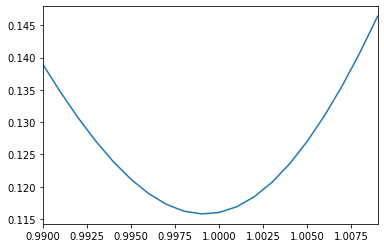

In [43]:
# 偏差整体校正优化
print("偏差整体校正优化")
W = [(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(y_valid), np.expm1(y_hat * w))
    print('RMSPE for {:.3f}:{:.5f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)

Score.plot()

BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [44]:
X_test = df_test[features]

In [45]:
#计算校正后数据的RMSPE得分
error = rmspe(np.expm1(y_valid), np.expm1(y_hat * 0.999))
print ('RMSPE for weight corretion {:5f}'.format(error))

RMSPE for weight corretion 0.115797


In [46]:
# 细致校正：以不同的店铺分组进行细致校正，每个店铺分别计算可以取得最佳RMSPE得分的校正系数
col_1 = ['Sales','Prediction']
s_dict = {}

L=range(1115)

for i in L:
    s1 = pd.DataFrame(valid_pred_res[valid_pred_res['Store'] == i+1],columns = col_1)
    
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction * w))
        S.append(error)
        
    Score = pd.Series(S,index = W1)
    s_dict[(i+1)] = Score.idxmin() 

In [48]:
temp = X_valid['Store']
temp.head()
temp_s = pd.Series(temp.values)
w_valid = []
for i, v in temp_s.items():
    a = 1.000
    if v in s_dict.keys():
        a = s_dict[v]

    w_valid.append(a)

In [49]:
#计算校正后数据的RMSPE得分
y_hat_new = y_hat * w_valid
error = rmspe(np.expm1(y_valid), np.expm1(y_hat_new))
print ('RMSPE for weight corretion {:5f}'.format(error))

RMSPE for weight corretion 0.107473


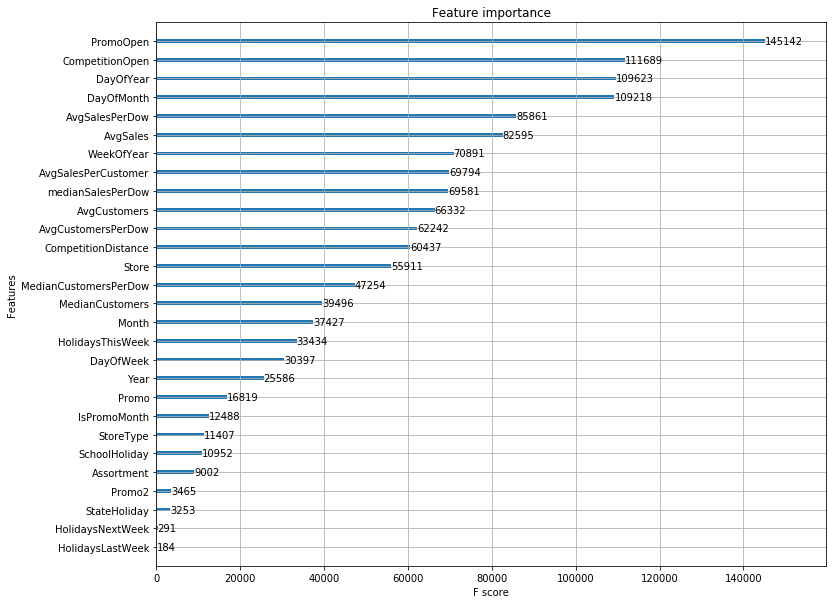

In [59]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
xgb.plot_importance(gbm)

In [50]:
temp = df_test['Store']
temp.head()
temp_s = pd.Series(temp.values)
w_test = []
for i, v in temp_s.items():
    a = 1.000
    if v in s_dict.keys():
        a = s_dict[v]

    w_test.append(a)

In [51]:
dmatrix_test = xgb.DMatrix(X_test)

In [52]:
# make prediction on test set
print("make prediction on test set")
y_test = gbm.predict(dmatrix_test)

make prediction on test set


In [53]:
#初始模型
submit_result_1 = pd.DataFrame({'Id': test['Id'], 'Sales': np.expm1(y_test)})
submit_result_1.to_csv('result1.csv', index=False)

In [54]:
#整体校正模型
submit_result_2 = pd.DataFrame({'Id': test['Id'], 'Sales': np.expm1(y_test * 0.999)})
submit_result_2.to_csv('result2.csv', index=False)

In [55]:
#单独校正模型
submit_result_3 = pd.DataFrame({'Id': test['Id'], 'Sales': np.expm1(y_test * w_test)})
submit_result_3.to_csv('result3.csv', index=False)

In [57]:
# 0.11350 0.10627

In [73]:
# 以下是最终提交数据结果==================================================================无需重复运行

In [23]:
# 开始训练融合模型
rounds = 10
blend_test_result = []
model_error = []
col = ['Sales','Prediction']

In [24]:
for r in range(rounds):
    colsample_bytree = 0.5
    # if r % 2 == 0:
    #    colsample_bytree = 0.7
        
    params = {'objective': 'reg:linear',
              'booster': 'gbtree',
              'eta': 0.03,
              'max_depth': 10,
              'subsample': 0.9,
              'colsample_bytree': colsample_bytree,
              'silent': 1,
              'seed': 909 + r
             }
    
    num_boost_round = 6000
    gbm = xgb.train(params, dmatrix_train, num_boost_round, evals=watch_list, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
    y_hat_valid = gbm.predict(xgb.DMatrix(X_valid[features]))
    
    error = rmspe(np.expm1(y_valid), np.expm1(y_hat_valid))
    model_error.append(error)
    
    valid_pred_res = pd.DataFrame(data = y_valid)
    valid_pred_res['Prediction'] = y_hat_valid
    valid_pred_res = pd.merge(X_valid[features],valid_pred_res, left_index= True, right_index=True)
    valid_pred_res['Ratio'] = valid_pred_res.Prediction/valid_pred_res.Sales
    valid_pred_res['Error'] =abs(valid_pred_res.Ratio - 1)
    valid_pred_res['Weight'] = valid_pred_res.Sales/valid_pred_res.Prediction

    # 细致校正：以不同的店铺分组进行细致校正，每个店铺分别计算可以取得最佳RMSPE得分的校正系数
    s_dict = {}

    L = range(1115)
    for i in L:
        s1 = pd.DataFrame(valid_pred_res[valid_pred_res['Store'] == i+1],columns = col)

        W1=[(0.990+(i/1000)) for i in range(20)]
        S =[]
        for w in W1:
            error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction * w))
            S.append(error)

        Score = pd.Series(S,index = W1)
        # BS = Score[Score.values == Score.values.min()]
        s_dict[(i+1)] = Score.idxmin() 
               
    # 计算test adjust param
    temp = df_test['Store']
    temp_s = pd.Series(temp.values)
    w_test = []
    for i, v in temp_s.items():
        a = 1.000
        if v in s_dict.keys():
            a = s_dict[v]

        w_test.append(a)
        
    y_test_once = gbm.predict(dmatrix_test)
    res = np.expm1(y_test_once * w_test)
    
    blend_test_result.append(res)

model_param = [1.0 - a for a in model_error]
sum = np.sum(model_param)
ratio = [a / sum for a in model_param]

final_result = [0] * len(blend_test_result[0])
for i in range(rounds):
    final_result = final_result + blend_test_result[i] * ratio[i]

[0]	train-rmse:8.01922	eval-rmse:8.04776	train-rmspe:0.999809	eval-rmspe:0.999816
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77886	eval-rmse:7.80748	train-rmspe:0.999713	eval-rmspe:0.999722
[2]	train-rmse:7.54567	eval-rmse:7.5741	train-rmspe:0.999594	eval-rmspe:0.999607
[3]	train-rmse:7.31947	eval-rmse:7.34828	train-rmspe:0.99945	eval-rmspe:0.999468
[4]	train-rmse:7.1001	eval-rmse:7.12881	train-rmspe:0.999275	eval-rmspe:0.999299
[5]	train-rmse:6.88724	eval-rmse:6.91573	train-rmspe:0.999066	eval-rmspe:0.999097
[6]	train-rmse:6.68076	eval-rmse:6.70932	train-rmspe:0.998817	eval-rmspe:0.998856
[7]	train-rmse:6.48053	eval-rmse:6.50942	train-rmspe:0.998522	eval-rmspe:0.99857
[8]	train-rmse:6.28633	eval-rmse:6.31539	train-rmspe:0.998173	eval-rmspe:0.998232
[9]	train-rmse:6.09795	eval-rmse:6.12693	train-rmspe:0.997765	eval-rmspe:0.997837
[10]	train-rmse:5.91515	eval-rmse:5.94

[97]	train-rmse:0.438294	eval-rmse:0.455672	train-rmspe:0.362008	eval-rmspe:0.357634
[98]	train-rmse:0.426249	eval-rmse:0.443642	train-rmspe:0.354895	eval-rmspe:0.349952
[99]	train-rmse:0.414605	eval-rmse:0.431782	train-rmspe:0.347961	eval-rmspe:0.342276
[100]	train-rmse:0.403207	eval-rmse:0.420307	train-rmspe:0.34114	eval-rmspe:0.334799
[101]	train-rmse:0.392303	eval-rmse:0.409404	train-rmspe:0.334497	eval-rmspe:0.327595
[102]	train-rmse:0.381687	eval-rmse:0.398837	train-rmspe:0.328088	eval-rmspe:0.320586
[103]	train-rmse:0.371468	eval-rmse:0.388361	train-rmspe:0.321901	eval-rmspe:0.31353
[104]	train-rmse:0.361476	eval-rmse:0.378437	train-rmspe:0.31586	eval-rmspe:0.306818
[105]	train-rmse:0.351874	eval-rmse:0.368888	train-rmspe:0.31	eval-rmspe:0.300297
[106]	train-rmse:0.342622	eval-rmse:0.359599	train-rmspe:0.304246	eval-rmspe:0.293883
[107]	train-rmse:0.333606	eval-rmse:0.350685	train-rmspe:0.29876	eval-rmspe:0.2877
[108]	train-rmse:0.324869	eval-rmse:0.342015	train-rmspe:0.293393	e

[193]	train-rmse:0.109706	eval-rmse:0.130084	train-rmspe:0.172262	eval-rmspe:0.129349
[194]	train-rmse:0.109396	eval-rmse:0.129819	train-rmspe:0.172188	eval-rmspe:0.129223
[195]	train-rmse:0.109141	eval-rmse:0.129569	train-rmspe:0.16817	eval-rmspe:0.12913
[196]	train-rmse:0.108848	eval-rmse:0.129296	train-rmspe:0.16781	eval-rmspe:0.128995
[197]	train-rmse:0.10857	eval-rmse:0.129056	train-rmspe:0.167561	eval-rmspe:0.128878
[198]	train-rmse:0.108341	eval-rmse:0.128844	train-rmspe:0.166687	eval-rmspe:0.128772
[199]	train-rmse:0.108146	eval-rmse:0.128677	train-rmspe:0.166681	eval-rmspe:0.128706
[200]	train-rmse:0.107887	eval-rmse:0.128491	train-rmspe:0.166593	eval-rmspe:0.128628
[201]	train-rmse:0.107656	eval-rmse:0.128298	train-rmspe:0.166505	eval-rmspe:0.128533
[202]	train-rmse:0.107449	eval-rmse:0.128074	train-rmspe:0.166135	eval-rmspe:0.12846
[203]	train-rmse:0.107207	eval-rmse:0.12783	train-rmspe:0.16606	eval-rmspe:0.128322
[204]	train-rmse:0.106976	eval-rmse:0.127643	train-rmspe:0.16

[289]	train-rmse:0.098087	eval-rmse:0.12073	train-rmspe:0.150491	eval-rmspe:0.124456
[290]	train-rmse:0.098045	eval-rmse:0.120699	train-rmspe:0.150436	eval-rmspe:0.12443
[291]	train-rmse:0.097978	eval-rmse:0.120643	train-rmspe:0.150389	eval-rmspe:0.124393
[292]	train-rmse:0.097926	eval-rmse:0.120595	train-rmspe:0.150341	eval-rmspe:0.124362
[293]	train-rmse:0.097864	eval-rmse:0.120573	train-rmspe:0.150195	eval-rmspe:0.12434
[294]	train-rmse:0.097809	eval-rmse:0.120498	train-rmspe:0.150154	eval-rmspe:0.124274
[295]	train-rmse:0.097719	eval-rmse:0.120537	train-rmspe:0.150068	eval-rmspe:0.124361
[296]	train-rmse:0.097662	eval-rmse:0.120496	train-rmspe:0.149288	eval-rmspe:0.124332
[297]	train-rmse:0.097569	eval-rmse:0.120366	train-rmspe:0.149223	eval-rmspe:0.124149
[298]	train-rmse:0.097493	eval-rmse:0.120361	train-rmspe:0.149133	eval-rmspe:0.12413
[299]	train-rmse:0.097415	eval-rmse:0.120311	train-rmspe:0.149058	eval-rmspe:0.124089
[300]	train-rmse:0.097341	eval-rmse:0.120249	train-rmspe:0

[385]	train-rmse:0.092875	eval-rmse:0.117921	train-rmspe:0.136192	eval-rmspe:0.121586
[386]	train-rmse:0.092833	eval-rmse:0.117863	train-rmspe:0.136145	eval-rmspe:0.12154
[387]	train-rmse:0.092794	eval-rmse:0.117828	train-rmspe:0.135661	eval-rmspe:0.121506
[388]	train-rmse:0.092755	eval-rmse:0.117798	train-rmspe:0.135424	eval-rmspe:0.12148
[389]	train-rmse:0.092699	eval-rmse:0.117795	train-rmspe:0.135379	eval-rmspe:0.121468
[390]	train-rmse:0.092676	eval-rmse:0.117784	train-rmspe:0.13535	eval-rmspe:0.121456
[391]	train-rmse:0.092629	eval-rmse:0.11776	train-rmspe:0.135305	eval-rmspe:0.121434
[392]	train-rmse:0.092581	eval-rmse:0.117703	train-rmspe:0.135226	eval-rmspe:0.121389
[393]	train-rmse:0.092554	eval-rmse:0.117701	train-rmspe:0.135194	eval-rmspe:0.121388
[394]	train-rmse:0.092513	eval-rmse:0.117687	train-rmspe:0.135135	eval-rmspe:0.121379
[395]	train-rmse:0.092475	eval-rmse:0.117654	train-rmspe:0.135109	eval-rmspe:0.12135
[396]	train-rmse:0.09242	eval-rmse:0.117638	train-rmspe:0.1

[481]	train-rmse:0.089564	eval-rmse:0.116442	train-rmspe:0.127739	eval-rmspe:0.120279
[482]	train-rmse:0.08953	eval-rmse:0.116423	train-rmspe:0.127709	eval-rmspe:0.120261
[483]	train-rmse:0.089499	eval-rmse:0.116398	train-rmspe:0.127686	eval-rmspe:0.120236
[484]	train-rmse:0.089473	eval-rmse:0.116378	train-rmspe:0.127665	eval-rmspe:0.120221
[485]	train-rmse:0.089449	eval-rmse:0.116366	train-rmspe:0.12764	eval-rmspe:0.120205
[486]	train-rmse:0.089424	eval-rmse:0.116328	train-rmspe:0.127616	eval-rmspe:0.120169
[487]	train-rmse:0.089417	eval-rmse:0.116321	train-rmspe:0.127612	eval-rmspe:0.120161
[488]	train-rmse:0.089377	eval-rmse:0.11634	train-rmspe:0.127469	eval-rmspe:0.120183
[489]	train-rmse:0.089359	eval-rmse:0.116343	train-rmspe:0.127424	eval-rmspe:0.120187
[490]	train-rmse:0.089332	eval-rmse:0.116313	train-rmspe:0.127411	eval-rmspe:0.120149
[491]	train-rmse:0.089298	eval-rmse:0.116285	train-rmspe:0.127352	eval-rmspe:0.120114
[492]	train-rmse:0.089281	eval-rmse:0.116282	train-rmspe:

[577]	train-rmse:0.087177	eval-rmse:0.115369	train-rmspe:0.119036	eval-rmspe:0.119181
[578]	train-rmse:0.087149	eval-rmse:0.115348	train-rmspe:0.11881	eval-rmspe:0.119166
[579]	train-rmse:0.087105	eval-rmse:0.115335	train-rmspe:0.118726	eval-rmspe:0.119145
[580]	train-rmse:0.087087	eval-rmse:0.115327	train-rmspe:0.11871	eval-rmspe:0.119138
[581]	train-rmse:0.087069	eval-rmse:0.115325	train-rmspe:0.118676	eval-rmspe:0.119135
[582]	train-rmse:0.087048	eval-rmse:0.115308	train-rmspe:0.118642	eval-rmspe:0.119116
[583]	train-rmse:0.087014	eval-rmse:0.115276	train-rmspe:0.118585	eval-rmspe:0.119093
[584]	train-rmse:0.086997	eval-rmse:0.115269	train-rmspe:0.11844	eval-rmspe:0.119086
[585]	train-rmse:0.086982	eval-rmse:0.115265	train-rmspe:0.118423	eval-rmspe:0.119081
[586]	train-rmse:0.086966	eval-rmse:0.115257	train-rmspe:0.118409	eval-rmspe:0.119077
[587]	train-rmse:0.086962	eval-rmse:0.115258	train-rmspe:0.118387	eval-rmspe:0.119078
[588]	train-rmse:0.086942	eval-rmse:0.11524	train-rmspe:0

[673]	train-rmse:0.08511	eval-rmse:0.114725	train-rmspe:0.111155	eval-rmspe:0.118453
[674]	train-rmse:0.08509	eval-rmse:0.114714	train-rmspe:0.111134	eval-rmspe:0.118443
[675]	train-rmse:0.08507	eval-rmse:0.114716	train-rmspe:0.111113	eval-rmspe:0.118443
[676]	train-rmse:0.085056	eval-rmse:0.114712	train-rmspe:0.111094	eval-rmspe:0.11844
[677]	train-rmse:0.085049	eval-rmse:0.114712	train-rmspe:0.111089	eval-rmspe:0.11844
[678]	train-rmse:0.08502	eval-rmse:0.114701	train-rmspe:0.111058	eval-rmspe:0.118429
[679]	train-rmse:0.085001	eval-rmse:0.114694	train-rmspe:0.111042	eval-rmspe:0.118423
[680]	train-rmse:0.084982	eval-rmse:0.11468	train-rmspe:0.111025	eval-rmspe:0.118404
[681]	train-rmse:0.08497	eval-rmse:0.114672	train-rmspe:0.111014	eval-rmspe:0.118397
[682]	train-rmse:0.084945	eval-rmse:0.11469	train-rmspe:0.110988	eval-rmspe:0.118411
[683]	train-rmse:0.084921	eval-rmse:0.114676	train-rmspe:0.110962	eval-rmspe:0.118399
[684]	train-rmse:0.084912	eval-rmse:0.114676	train-rmspe:0.1109

[769]	train-rmse:0.08339	eval-rmse:0.114279	train-rmspe:0.105939	eval-rmspe:0.118038
[770]	train-rmse:0.083376	eval-rmse:0.114277	train-rmspe:0.105908	eval-rmspe:0.118036
[771]	train-rmse:0.08335	eval-rmse:0.114266	train-rmspe:0.105882	eval-rmspe:0.118026
[772]	train-rmse:0.083333	eval-rmse:0.114259	train-rmspe:0.105891	eval-rmspe:0.118019
[773]	train-rmse:0.083309	eval-rmse:0.114253	train-rmspe:0.105865	eval-rmspe:0.118009
[774]	train-rmse:0.083289	eval-rmse:0.11425	train-rmspe:0.105834	eval-rmspe:0.118007
[775]	train-rmse:0.083269	eval-rmse:0.114222	train-rmspe:0.105772	eval-rmspe:0.117985
[776]	train-rmse:0.083255	eval-rmse:0.114218	train-rmspe:0.105742	eval-rmspe:0.117978
[777]	train-rmse:0.083238	eval-rmse:0.114213	train-rmspe:0.105725	eval-rmspe:0.117974
[778]	train-rmse:0.083227	eval-rmse:0.114212	train-rmspe:0.105711	eval-rmspe:0.117973
[779]	train-rmse:0.083205	eval-rmse:0.114197	train-rmspe:0.10566	eval-rmspe:0.117959
[780]	train-rmse:0.083166	eval-rmse:0.114185	train-rmspe:0

[865]	train-rmse:0.081751	eval-rmse:0.113847	train-rmspe:0.101059	eval-rmspe:0.117495
[866]	train-rmse:0.081735	eval-rmse:0.113841	train-rmspe:0.101043	eval-rmspe:0.11749
[867]	train-rmse:0.081721	eval-rmse:0.113835	train-rmspe:0.101025	eval-rmspe:0.117485
[868]	train-rmse:0.081695	eval-rmse:0.113819	train-rmspe:0.101	eval-rmspe:0.117472
[869]	train-rmse:0.081681	eval-rmse:0.113817	train-rmspe:0.100986	eval-rmspe:0.11747
[870]	train-rmse:0.081657	eval-rmse:0.113812	train-rmspe:0.100873	eval-rmspe:0.117468
[871]	train-rmse:0.081644	eval-rmse:0.113814	train-rmspe:0.100857	eval-rmspe:0.11747
[872]	train-rmse:0.08163	eval-rmse:0.113813	train-rmspe:0.099882	eval-rmspe:0.117469
[873]	train-rmse:0.081614	eval-rmse:0.11381	train-rmspe:0.09985	eval-rmspe:0.117465
[874]	train-rmse:0.08159	eval-rmse:0.113807	train-rmspe:0.099832	eval-rmspe:0.117459
[875]	train-rmse:0.081574	eval-rmse:0.113804	train-rmspe:0.099806	eval-rmspe:0.117457
[876]	train-rmse:0.081553	eval-rmse:0.113796	train-rmspe:0.09978

[961]	train-rmse:0.080153	eval-rmse:0.113637	train-rmspe:0.094907	eval-rmspe:0.117179
[962]	train-rmse:0.080149	eval-rmse:0.113636	train-rmspe:0.094901	eval-rmspe:0.117177
[963]	train-rmse:0.080137	eval-rmse:0.113631	train-rmspe:0.094888	eval-rmspe:0.117172
[964]	train-rmse:0.08012	eval-rmse:0.113623	train-rmspe:0.09487	eval-rmspe:0.117171
[965]	train-rmse:0.080109	eval-rmse:0.113598	train-rmspe:0.094839	eval-rmspe:0.117163
[966]	train-rmse:0.080096	eval-rmse:0.113595	train-rmspe:0.094819	eval-rmspe:0.117161
[967]	train-rmse:0.080083	eval-rmse:0.113591	train-rmspe:0.094806	eval-rmspe:0.117157
[968]	train-rmse:0.080066	eval-rmse:0.113598	train-rmspe:0.094786	eval-rmspe:0.117165
[969]	train-rmse:0.080054	eval-rmse:0.113594	train-rmspe:0.094774	eval-rmspe:0.117161
[970]	train-rmse:0.080046	eval-rmse:0.113579	train-rmspe:0.094767	eval-rmspe:0.117153
[971]	train-rmse:0.080033	eval-rmse:0.113577	train-rmspe:0.094751	eval-rmspe:0.117149
[972]	train-rmse:0.080012	eval-rmse:0.113575	train-rmspe

[1057]	train-rmse:0.078711	eval-rmse:0.113302	train-rmspe:0.090006	eval-rmspe:0.116855
[1058]	train-rmse:0.078698	eval-rmse:0.113297	train-rmspe:0.089981	eval-rmspe:0.11685
[1059]	train-rmse:0.078695	eval-rmse:0.113297	train-rmspe:0.089978	eval-rmspe:0.11685
[1060]	train-rmse:0.078683	eval-rmse:0.113295	train-rmspe:0.089967	eval-rmspe:0.116845
[1061]	train-rmse:0.07867	eval-rmse:0.113291	train-rmspe:0.089909	eval-rmspe:0.116842
[1062]	train-rmse:0.078659	eval-rmse:0.113292	train-rmspe:0.0899	eval-rmspe:0.116842
[1063]	train-rmse:0.078631	eval-rmse:0.113289	train-rmspe:0.089843	eval-rmspe:0.116841
[1064]	train-rmse:0.078616	eval-rmse:0.113288	train-rmspe:0.089814	eval-rmspe:0.116841
[1065]	train-rmse:0.078602	eval-rmse:0.113284	train-rmspe:0.089801	eval-rmspe:0.116835
[1066]	train-rmse:0.078596	eval-rmse:0.113283	train-rmspe:0.089793	eval-rmspe:0.116834
[1067]	train-rmse:0.078582	eval-rmse:0.113281	train-rmspe:0.089782	eval-rmspe:0.116831
[1068]	train-rmse:0.078569	eval-rmse:0.113271	tr

[1152]	train-rmse:0.077431	eval-rmse:0.113024	train-rmspe:0.087165	eval-rmspe:0.116645
[1153]	train-rmse:0.077428	eval-rmse:0.113023	train-rmspe:0.087161	eval-rmspe:0.116644
[1154]	train-rmse:0.077416	eval-rmse:0.113018	train-rmspe:0.087148	eval-rmspe:0.11664
[1155]	train-rmse:0.077405	eval-rmse:0.113013	train-rmspe:0.087134	eval-rmspe:0.116635
[1156]	train-rmse:0.077389	eval-rmse:0.113012	train-rmspe:0.087108	eval-rmspe:0.116634
[1157]	train-rmse:0.077375	eval-rmse:0.113007	train-rmspe:0.087095	eval-rmspe:0.116629
[1158]	train-rmse:0.077363	eval-rmse:0.113011	train-rmspe:0.087086	eval-rmspe:0.116631
[1159]	train-rmse:0.077331	eval-rmse:0.113002	train-rmspe:0.087009	eval-rmspe:0.116623
[1160]	train-rmse:0.077309	eval-rmse:0.112992	train-rmspe:0.086978	eval-rmspe:0.116613
[1161]	train-rmse:0.077292	eval-rmse:0.112992	train-rmspe:0.086962	eval-rmspe:0.116613
[1162]	train-rmse:0.077278	eval-rmse:0.112989	train-rmspe:0.086739	eval-rmspe:0.116611
[1163]	train-rmse:0.077254	eval-rmse:0.11298

[1247]	train-rmse:0.076257	eval-rmse:0.112959	train-rmspe:0.084772	eval-rmspe:0.116578
[1248]	train-rmse:0.076253	eval-rmse:0.112958	train-rmspe:0.084767	eval-rmspe:0.116578
[1249]	train-rmse:0.076237	eval-rmse:0.112954	train-rmspe:0.084736	eval-rmspe:0.116572
[1250]	train-rmse:0.076233	eval-rmse:0.112949	train-rmspe:0.084732	eval-rmspe:0.116569
[1251]	train-rmse:0.076229	eval-rmse:0.112948	train-rmspe:0.084729	eval-rmspe:0.116569
[1252]	train-rmse:0.076218	eval-rmse:0.112947	train-rmspe:0.084659	eval-rmspe:0.116567
[1253]	train-rmse:0.076208	eval-rmse:0.112942	train-rmspe:0.084648	eval-rmspe:0.116564
[1254]	train-rmse:0.076192	eval-rmse:0.112953	train-rmspe:0.084632	eval-rmspe:0.116575
[1255]	train-rmse:0.07618	eval-rmse:0.112951	train-rmspe:0.08462	eval-rmspe:0.116575
[1256]	train-rmse:0.076166	eval-rmse:0.112948	train-rmspe:0.084605	eval-rmspe:0.116572
[1257]	train-rmse:0.076156	eval-rmse:0.112948	train-rmspe:0.084595	eval-rmspe:0.116572
[1258]	train-rmse:0.076138	eval-rmse:0.112952

[1342]	train-rmse:0.07516	eval-rmse:0.112799	train-rmspe:0.08296	eval-rmspe:0.116386
[1343]	train-rmse:0.075152	eval-rmse:0.112794	train-rmspe:0.082952	eval-rmspe:0.116389
[1344]	train-rmse:0.075145	eval-rmse:0.112799	train-rmspe:0.082942	eval-rmspe:0.116391
[1345]	train-rmse:0.075127	eval-rmse:0.112789	train-rmspe:0.082787	eval-rmspe:0.116384
[1346]	train-rmse:0.075117	eval-rmse:0.112786	train-rmspe:0.082778	eval-rmspe:0.116384
[1347]	train-rmse:0.075108	eval-rmse:0.112783	train-rmspe:0.082769	eval-rmspe:0.116379
[1348]	train-rmse:0.075091	eval-rmse:0.112784	train-rmspe:0.082753	eval-rmspe:0.116378
[1349]	train-rmse:0.075076	eval-rmse:0.112783	train-rmspe:0.082737	eval-rmspe:0.116378
[1350]	train-rmse:0.075069	eval-rmse:0.112783	train-rmspe:0.082729	eval-rmspe:0.116378
[1351]	train-rmse:0.075055	eval-rmse:0.112781	train-rmspe:0.082714	eval-rmspe:0.116377
[1352]	train-rmse:0.075039	eval-rmse:0.112788	train-rmspe:0.082697	eval-rmspe:0.116379
[1353]	train-rmse:0.075031	eval-rmse:0.112785

[1437]	train-rmse:0.07405	eval-rmse:0.112687	train-rmspe:0.08079	eval-rmspe:0.116284
[1438]	train-rmse:0.07404	eval-rmse:0.112686	train-rmspe:0.080781	eval-rmspe:0.116283
[1439]	train-rmse:0.074032	eval-rmse:0.112683	train-rmspe:0.080772	eval-rmspe:0.11628
[1440]	train-rmse:0.074023	eval-rmse:0.112679	train-rmspe:0.080762	eval-rmspe:0.116273
[1441]	train-rmse:0.074012	eval-rmse:0.112678	train-rmspe:0.080751	eval-rmspe:0.116274
[1442]	train-rmse:0.074002	eval-rmse:0.112677	train-rmspe:0.080741	eval-rmspe:0.116273
[1443]	train-rmse:0.073998	eval-rmse:0.112679	train-rmspe:0.080736	eval-rmspe:0.116274
[1444]	train-rmse:0.073983	eval-rmse:0.112678	train-rmspe:0.080722	eval-rmspe:0.116268
[1445]	train-rmse:0.073978	eval-rmse:0.112676	train-rmspe:0.080712	eval-rmspe:0.116265
[1446]	train-rmse:0.073968	eval-rmse:0.112673	train-rmspe:0.080702	eval-rmspe:0.116263
[1447]	train-rmse:0.073957	eval-rmse:0.112674	train-rmspe:0.080689	eval-rmspe:0.116263
[1448]	train-rmse:0.073949	eval-rmse:0.112675	t

[1532]	train-rmse:0.073101	eval-rmse:0.112593	train-rmspe:0.079295	eval-rmspe:0.116191
[1533]	train-rmse:0.073095	eval-rmse:0.112592	train-rmspe:0.079289	eval-rmspe:0.116189
[1534]	train-rmse:0.073092	eval-rmse:0.112592	train-rmspe:0.079284	eval-rmspe:0.116189
[1535]	train-rmse:0.073081	eval-rmse:0.112592	train-rmspe:0.079222	eval-rmspe:0.116189
[1536]	train-rmse:0.073072	eval-rmse:0.112593	train-rmspe:0.079213	eval-rmspe:0.11618
[1537]	train-rmse:0.073066	eval-rmse:0.11259	train-rmspe:0.079207	eval-rmspe:0.116176
[1538]	train-rmse:0.073051	eval-rmse:0.112586	train-rmspe:0.079181	eval-rmspe:0.116175
[1539]	train-rmse:0.073045	eval-rmse:0.112585	train-rmspe:0.079175	eval-rmspe:0.116177
[1540]	train-rmse:0.07303	eval-rmse:0.112584	train-rmspe:0.07916	eval-rmspe:0.116175
[1541]	train-rmse:0.073025	eval-rmse:0.112583	train-rmspe:0.079154	eval-rmspe:0.116174
[1542]	train-rmse:0.073015	eval-rmse:0.112583	train-rmspe:0.079142	eval-rmspe:0.116174
[1543]	train-rmse:0.073001	eval-rmse:0.112582	t

[1627]	train-rmse:0.072149	eval-rmse:0.112529	train-rmspe:0.077903	eval-rmspe:0.116103
[1628]	train-rmse:0.07214	eval-rmse:0.112531	train-rmspe:0.077895	eval-rmspe:0.116106
[1629]	train-rmse:0.07213	eval-rmse:0.112527	train-rmspe:0.077867	eval-rmspe:0.116102
[1630]	train-rmse:0.072121	eval-rmse:0.112531	train-rmspe:0.077853	eval-rmspe:0.116114
[1631]	train-rmse:0.072113	eval-rmse:0.11253	train-rmspe:0.077841	eval-rmspe:0.116113
[1632]	train-rmse:0.072107	eval-rmse:0.112529	train-rmspe:0.077832	eval-rmspe:0.116112
[1633]	train-rmse:0.072094	eval-rmse:0.11253	train-rmspe:0.077818	eval-rmspe:0.116112
[1634]	train-rmse:0.072083	eval-rmse:0.112527	train-rmspe:0.077793	eval-rmspe:0.11611
[1635]	train-rmse:0.072076	eval-rmse:0.112537	train-rmspe:0.077781	eval-rmspe:0.116103
[1636]	train-rmse:0.072068	eval-rmse:0.112535	train-rmspe:0.077772	eval-rmspe:0.116102
[1637]	train-rmse:0.07206	eval-rmse:0.112534	train-rmspe:0.077725	eval-rmspe:0.1161
[1638]	train-rmse:0.072052	eval-rmse:0.112533	train

[1722]	train-rmse:0.071239	eval-rmse:0.112457	train-rmspe:0.076506	eval-rmspe:0.116045
[1723]	train-rmse:0.071223	eval-rmse:0.112456	train-rmspe:0.076484	eval-rmspe:0.116045
[1724]	train-rmse:0.071216	eval-rmse:0.112457	train-rmspe:0.076478	eval-rmspe:0.116048
[1725]	train-rmse:0.07121	eval-rmse:0.112454	train-rmspe:0.076472	eval-rmspe:0.116046
[1726]	train-rmse:0.071204	eval-rmse:0.112454	train-rmspe:0.076465	eval-rmspe:0.116046
[1727]	train-rmse:0.071197	eval-rmse:0.112454	train-rmspe:0.076458	eval-rmspe:0.116048
[1728]	train-rmse:0.071184	eval-rmse:0.112451	train-rmspe:0.07644	eval-rmspe:0.116045
[1729]	train-rmse:0.071172	eval-rmse:0.112447	train-rmspe:0.076428	eval-rmspe:0.116037
[1730]	train-rmse:0.071157	eval-rmse:0.112442	train-rmspe:0.076411	eval-rmspe:0.116032
[1731]	train-rmse:0.071147	eval-rmse:0.112443	train-rmspe:0.076401	eval-rmspe:0.116034
[1732]	train-rmse:0.071134	eval-rmse:0.112438	train-rmspe:0.076384	eval-rmspe:0.11603
[1733]	train-rmse:0.071125	eval-rmse:0.112447	

[1817]	train-rmse:0.070414	eval-rmse:0.11239	train-rmspe:0.075265	eval-rmspe:0.11603
[1818]	train-rmse:0.0704	eval-rmse:0.112375	train-rmspe:0.07525	eval-rmspe:0.116025
[1819]	train-rmse:0.070394	eval-rmse:0.112373	train-rmspe:0.075244	eval-rmspe:0.116024
[1820]	train-rmse:0.070381	eval-rmse:0.112373	train-rmspe:0.075214	eval-rmspe:0.116024
[1821]	train-rmse:0.070372	eval-rmse:0.112371	train-rmspe:0.075205	eval-rmspe:0.116022
[1822]	train-rmse:0.070362	eval-rmse:0.11237	train-rmspe:0.075195	eval-rmspe:0.116021
[1823]	train-rmse:0.070355	eval-rmse:0.112368	train-rmspe:0.075187	eval-rmspe:0.116019
[1824]	train-rmse:0.070344	eval-rmse:0.112367	train-rmspe:0.075173	eval-rmspe:0.116019
[1825]	train-rmse:0.070335	eval-rmse:0.112366	train-rmspe:0.075159	eval-rmspe:0.116018
[1826]	train-rmse:0.070326	eval-rmse:0.112364	train-rmspe:0.075146	eval-rmspe:0.116016
[1827]	train-rmse:0.070321	eval-rmse:0.112364	train-rmspe:0.075137	eval-rmspe:0.116016
[1828]	train-rmse:0.07031	eval-rmse:0.112359	trai

[36]	train-rmse:2.68399	eval-rmse:2.71209	train-rmspe:0.929817	eval-rmspe:0.931804
[37]	train-rmse:2.60373	eval-rmse:2.6308	train-rmspe:0.924008	eval-rmspe:0.926065
[38]	train-rmse:2.52594	eval-rmse:2.55307	train-rmspe:0.917907	eval-rmspe:0.920116
[39]	train-rmse:2.45043	eval-rmse:2.47754	train-rmspe:0.911533	eval-rmspe:0.913901
[40]	train-rmse:2.37719	eval-rmse:2.40431	train-rmspe:0.904879	eval-rmspe:0.907413
[41]	train-rmse:2.30623	eval-rmse:2.3332	train-rmspe:0.897933	eval-rmspe:0.900618
[42]	train-rmse:2.23732	eval-rmse:2.26442	train-rmspe:0.890731	eval-rmspe:0.893601
[43]	train-rmse:2.17053	eval-rmse:2.19755	train-rmspe:0.883247	eval-rmspe:0.886281
[44]	train-rmse:2.10571	eval-rmse:2.13261	train-rmspe:0.875514	eval-rmspe:0.878708
[45]	train-rmse:2.04293	eval-rmse:2.06937	train-rmspe:0.867503	eval-rmspe:0.87081
[46]	train-rmse:1.98197	eval-rmse:2.0081	train-rmspe:0.859261	eval-rmspe:0.862702
[47]	train-rmse:1.92282	eval-rmse:1.94854	train-rmspe:0.850787	eval-rmspe:0.854343
[48]	tra

[134]	train-rmse:0.179859	eval-rmse:0.197081	train-rmspe:0.202649	eval-rmspe:0.174638
[135]	train-rmse:0.176613	eval-rmse:0.194258	train-rmspe:0.198464	eval-rmspe:0.172513
[136]	train-rmse:0.173474	eval-rmse:0.191182	train-rmspe:0.196239	eval-rmspe:0.170211
[137]	train-rmse:0.17053	eval-rmse:0.188293	train-rmspe:0.1947	eval-rmspe:0.168035
[138]	train-rmse:0.167706	eval-rmse:0.185496	train-rmspe:0.192968	eval-rmspe:0.165939
[139]	train-rmse:0.165029	eval-rmse:0.182894	train-rmspe:0.191606	eval-rmspe:0.164003
[140]	train-rmse:0.162456	eval-rmse:0.180278	train-rmspe:0.190319	eval-rmspe:0.162066
[141]	train-rmse:0.159891	eval-rmse:0.177688	train-rmspe:0.188957	eval-rmspe:0.160144
[142]	train-rmse:0.157481	eval-rmse:0.175064	train-rmspe:0.187761	eval-rmspe:0.158243
[143]	train-rmse:0.15523	eval-rmse:0.172855	train-rmspe:0.186697	eval-rmspe:0.156637
[144]	train-rmse:0.153055	eval-rmse:0.170726	train-rmspe:0.185431	eval-rmspe:0.155103
[145]	train-rmse:0.151007	eval-rmse:0.168751	train-rmspe:0

[230]	train-rmse:0.103425	eval-rmse:0.124742	train-rmspe:0.151117	eval-rmspe:0.127168
[231]	train-rmse:0.103281	eval-rmse:0.1246	train-rmspe:0.15102	eval-rmspe:0.127082
[232]	train-rmse:0.103139	eval-rmse:0.124484	train-rmspe:0.150951	eval-rmspe:0.127008
[233]	train-rmse:0.103026	eval-rmse:0.124402	train-rmspe:0.149576	eval-rmspe:0.126986
[234]	train-rmse:0.102939	eval-rmse:0.124363	train-rmspe:0.149535	eval-rmspe:0.126991
[235]	train-rmse:0.102819	eval-rmse:0.124246	train-rmspe:0.149476	eval-rmspe:0.126905
[236]	train-rmse:0.102746	eval-rmse:0.124166	train-rmspe:0.149444	eval-rmspe:0.126869
[237]	train-rmse:0.102625	eval-rmse:0.124064	train-rmspe:0.149389	eval-rmspe:0.126799
[238]	train-rmse:0.102505	eval-rmse:0.12401	train-rmspe:0.149297	eval-rmspe:0.126758
[239]	train-rmse:0.10244	eval-rmse:0.123944	train-rmspe:0.149211	eval-rmspe:0.126737
[240]	train-rmse:0.102346	eval-rmse:0.123879	train-rmspe:0.14916	eval-rmspe:0.1267
[241]	train-rmse:0.102232	eval-rmse:0.123793	train-rmspe:0.149

[326]	train-rmse:0.096147	eval-rmse:0.119751	train-rmspe:0.137192	eval-rmspe:0.123427
[327]	train-rmse:0.096101	eval-rmse:0.119713	train-rmspe:0.137157	eval-rmspe:0.12339
[328]	train-rmse:0.096044	eval-rmse:0.119669	train-rmspe:0.13671	eval-rmspe:0.123341
[329]	train-rmse:0.095966	eval-rmse:0.119643	train-rmspe:0.136576	eval-rmspe:0.123322
[330]	train-rmse:0.095913	eval-rmse:0.119588	train-rmspe:0.136532	eval-rmspe:0.123281
[331]	train-rmse:0.095852	eval-rmse:0.119542	train-rmspe:0.136469	eval-rmspe:0.123235
[332]	train-rmse:0.095804	eval-rmse:0.11949	train-rmspe:0.136434	eval-rmspe:0.123193
[333]	train-rmse:0.095762	eval-rmse:0.119457	train-rmspe:0.136401	eval-rmspe:0.123156
[334]	train-rmse:0.095721	eval-rmse:0.119426	train-rmspe:0.136245	eval-rmspe:0.123131
[335]	train-rmse:0.095667	eval-rmse:0.119443	train-rmspe:0.136208	eval-rmspe:0.123134
[336]	train-rmse:0.095625	eval-rmse:0.119398	train-rmspe:0.136161	eval-rmspe:0.123095
[337]	train-rmse:0.095583	eval-rmse:0.119363	train-rmspe:

[422]	train-rmse:0.091935	eval-rmse:0.117927	train-rmspe:0.124896	eval-rmspe:0.121543
[423]	train-rmse:0.091877	eval-rmse:0.117925	train-rmspe:0.124789	eval-rmspe:0.121545
[424]	train-rmse:0.091861	eval-rmse:0.117915	train-rmspe:0.124773	eval-rmspe:0.12154
[425]	train-rmse:0.091823	eval-rmse:0.117894	train-rmspe:0.124729	eval-rmspe:0.121517
[426]	train-rmse:0.091809	eval-rmse:0.117891	train-rmspe:0.124717	eval-rmspe:0.121513
[427]	train-rmse:0.091746	eval-rmse:0.117862	train-rmspe:0.124418	eval-rmspe:0.121484
[428]	train-rmse:0.091716	eval-rmse:0.117844	train-rmspe:0.124387	eval-rmspe:0.121469
[429]	train-rmse:0.091688	eval-rmse:0.117822	train-rmspe:0.124285	eval-rmspe:0.121448
[430]	train-rmse:0.091638	eval-rmse:0.117812	train-rmspe:0.124208	eval-rmspe:0.121438
[431]	train-rmse:0.091599	eval-rmse:0.117792	train-rmspe:0.124172	eval-rmspe:0.121421
[432]	train-rmse:0.091571	eval-rmse:0.11779	train-rmspe:0.124101	eval-rmspe:0.121414
[433]	train-rmse:0.091544	eval-rmse:0.117779	train-rmspe

[518]	train-rmse:0.088822	eval-rmse:0.116567	train-rmspe:0.118311	eval-rmspe:0.120204
[519]	train-rmse:0.088788	eval-rmse:0.116547	train-rmspe:0.118277	eval-rmspe:0.120188
[520]	train-rmse:0.088764	eval-rmse:0.116532	train-rmspe:0.118157	eval-rmspe:0.120164
[521]	train-rmse:0.088746	eval-rmse:0.116526	train-rmspe:0.118134	eval-rmspe:0.120157
[522]	train-rmse:0.088725	eval-rmse:0.116513	train-rmspe:0.118079	eval-rmspe:0.120145
[523]	train-rmse:0.0887	eval-rmse:0.116494	train-rmspe:0.118058	eval-rmspe:0.120124
[524]	train-rmse:0.088663	eval-rmse:0.116471	train-rmspe:0.118023	eval-rmspe:0.120102
[525]	train-rmse:0.088628	eval-rmse:0.116457	train-rmspe:0.117992	eval-rmspe:0.120089
[526]	train-rmse:0.088622	eval-rmse:0.116452	train-rmspe:0.117987	eval-rmspe:0.120084
[527]	train-rmse:0.088612	eval-rmse:0.116442	train-rmspe:0.11798	eval-rmspe:0.120073
[528]	train-rmse:0.088576	eval-rmse:0.116427	train-rmspe:0.117573	eval-rmspe:0.120069
[529]	train-rmse:0.088559	eval-rmse:0.116423	train-rmspe:

[614]	train-rmse:0.086393	eval-rmse:0.115596	train-rmspe:0.108412	eval-rmspe:0.119191
[615]	train-rmse:0.086375	eval-rmse:0.115588	train-rmspe:0.108385	eval-rmspe:0.119181
[616]	train-rmse:0.086362	eval-rmse:0.115592	train-rmspe:0.108363	eval-rmspe:0.119184
[617]	train-rmse:0.086344	eval-rmse:0.115578	train-rmspe:0.108349	eval-rmspe:0.119169
[618]	train-rmse:0.086324	eval-rmse:0.11557	train-rmspe:0.108316	eval-rmspe:0.119163
[619]	train-rmse:0.086315	eval-rmse:0.11557	train-rmspe:0.108309	eval-rmspe:0.119163
[620]	train-rmse:0.086293	eval-rmse:0.115566	train-rmspe:0.107861	eval-rmspe:0.119161
[621]	train-rmse:0.086263	eval-rmse:0.115565	train-rmspe:0.10779	eval-rmspe:0.119157
[622]	train-rmse:0.086244	eval-rmse:0.115558	train-rmspe:0.107756	eval-rmspe:0.11915
[623]	train-rmse:0.086204	eval-rmse:0.115537	train-rmspe:0.10771	eval-rmspe:0.119127
[624]	train-rmse:0.086166	eval-rmse:0.115533	train-rmspe:0.107641	eval-rmspe:0.119125
[625]	train-rmse:0.086141	eval-rmse:0.115516	train-rmspe:0.

[710]	train-rmse:0.084287	eval-rmse:0.1152	train-rmspe:0.10252	eval-rmspe:0.118744
[711]	train-rmse:0.084274	eval-rmse:0.115196	train-rmspe:0.102507	eval-rmspe:0.118742
[712]	train-rmse:0.084254	eval-rmse:0.115188	train-rmspe:0.102487	eval-rmspe:0.118737
[713]	train-rmse:0.084236	eval-rmse:0.115183	train-rmspe:0.10246	eval-rmspe:0.11873
[714]	train-rmse:0.084197	eval-rmse:0.115174	train-rmspe:0.102399	eval-rmspe:0.118687
[715]	train-rmse:0.084185	eval-rmse:0.115167	train-rmspe:0.102296	eval-rmspe:0.11868
[716]	train-rmse:0.084167	eval-rmse:0.115159	train-rmspe:0.10226	eval-rmspe:0.118673
[717]	train-rmse:0.084148	eval-rmse:0.115159	train-rmspe:0.102204	eval-rmspe:0.118674
[718]	train-rmse:0.084135	eval-rmse:0.115156	train-rmspe:0.10219	eval-rmspe:0.118674
[719]	train-rmse:0.08412	eval-rmse:0.115153	train-rmspe:0.102169	eval-rmspe:0.118672
[720]	train-rmse:0.08409	eval-rmse:0.115148	train-rmspe:0.102138	eval-rmspe:0.118665
[721]	train-rmse:0.08408	eval-rmse:0.115148	train-rmspe:0.102123

[806]	train-rmse:0.082525	eval-rmse:0.114748	train-rmspe:0.097733	eval-rmspe:0.118073
[807]	train-rmse:0.082511	eval-rmse:0.114748	train-rmspe:0.097722	eval-rmspe:0.118074
[808]	train-rmse:0.082483	eval-rmse:0.114739	train-rmspe:0.097696	eval-rmspe:0.118066
[809]	train-rmse:0.082456	eval-rmse:0.114724	train-rmspe:0.097575	eval-rmspe:0.118053
[810]	train-rmse:0.082431	eval-rmse:0.114711	train-rmspe:0.097294	eval-rmspe:0.118041
[811]	train-rmse:0.08242	eval-rmse:0.114731	train-rmspe:0.097283	eval-rmspe:0.118056
[812]	train-rmse:0.082398	eval-rmse:0.114721	train-rmspe:0.097242	eval-rmspe:0.118049
[813]	train-rmse:0.082384	eval-rmse:0.114717	train-rmspe:0.097224	eval-rmspe:0.118043
[814]	train-rmse:0.08238	eval-rmse:0.114713	train-rmspe:0.097221	eval-rmspe:0.118041
[815]	train-rmse:0.082371	eval-rmse:0.114712	train-rmspe:0.097207	eval-rmspe:0.11804
[816]	train-rmse:0.082344	eval-rmse:0.114702	train-rmspe:0.097172	eval-rmspe:0.118031
[817]	train-rmse:0.082322	eval-rmse:0.114696	train-rmspe:

[902]	train-rmse:0.080914	eval-rmse:0.114367	train-rmspe:0.094639	eval-rmspe:0.117559
[903]	train-rmse:0.080893	eval-rmse:0.114375	train-rmspe:0.094178	eval-rmspe:0.117563
[904]	train-rmse:0.08088	eval-rmse:0.114376	train-rmspe:0.094159	eval-rmspe:0.117566
[905]	train-rmse:0.080857	eval-rmse:0.114365	train-rmspe:0.094137	eval-rmspe:0.117559
[906]	train-rmse:0.080835	eval-rmse:0.11436	train-rmspe:0.094114	eval-rmspe:0.117555
[907]	train-rmse:0.080818	eval-rmse:0.114356	train-rmspe:0.093912	eval-rmspe:0.117552
[908]	train-rmse:0.08081	eval-rmse:0.11435	train-rmspe:0.093905	eval-rmspe:0.117546
[909]	train-rmse:0.08079	eval-rmse:0.114379	train-rmspe:0.093884	eval-rmspe:0.117582
[910]	train-rmse:0.08077	eval-rmse:0.114371	train-rmspe:0.093854	eval-rmspe:0.117574
[911]	train-rmse:0.080758	eval-rmse:0.114353	train-rmspe:0.093842	eval-rmspe:0.11757
[912]	train-rmse:0.080751	eval-rmse:0.114352	train-rmspe:0.093835	eval-rmspe:0.11757
[913]	train-rmse:0.08073	eval-rmse:0.114408	train-rmspe:0.0938

[998]	train-rmse:0.07939	eval-rmse:0.113958	train-rmspe:0.090797	eval-rmspe:0.116988
[999]	train-rmse:0.079377	eval-rmse:0.113953	train-rmspe:0.090786	eval-rmspe:0.116985
[1000]	train-rmse:0.079364	eval-rmse:0.113947	train-rmspe:0.090773	eval-rmspe:0.116978
[1001]	train-rmse:0.079351	eval-rmse:0.113946	train-rmspe:0.090759	eval-rmspe:0.116977
[1002]	train-rmse:0.07933	eval-rmse:0.113975	train-rmspe:0.09073	eval-rmspe:0.116999
[1003]	train-rmse:0.079315	eval-rmse:0.113972	train-rmspe:0.090713	eval-rmspe:0.116997
[1004]	train-rmse:0.079303	eval-rmse:0.113966	train-rmspe:0.090696	eval-rmspe:0.11699
[1005]	train-rmse:0.079287	eval-rmse:0.113972	train-rmspe:0.090609	eval-rmspe:0.116996
[1006]	train-rmse:0.079278	eval-rmse:0.113969	train-rmspe:0.0906	eval-rmspe:0.116993
[1007]	train-rmse:0.079257	eval-rmse:0.113971	train-rmspe:0.090577	eval-rmspe:0.116992
[1008]	train-rmse:0.079242	eval-rmse:0.113969	train-rmspe:0.09054	eval-rmspe:0.116991
[1009]	train-rmse:0.079233	eval-rmse:0.113963	train-

[1093]	train-rmse:0.078007	eval-rmse:0.113741	train-rmspe:0.087908	eval-rmspe:0.116757
[1094]	train-rmse:0.077996	eval-rmse:0.113742	train-rmspe:0.087898	eval-rmspe:0.11676
[1095]	train-rmse:0.077979	eval-rmse:0.11374	train-rmspe:0.087878	eval-rmspe:0.116762
[1096]	train-rmse:0.077967	eval-rmse:0.113735	train-rmspe:0.087867	eval-rmspe:0.116757
[1097]	train-rmse:0.077947	eval-rmse:0.113739	train-rmspe:0.087848	eval-rmspe:0.116762
[1098]	train-rmse:0.077933	eval-rmse:0.113738	train-rmspe:0.087824	eval-rmspe:0.116762
[1099]	train-rmse:0.077916	eval-rmse:0.113742	train-rmspe:0.087807	eval-rmspe:0.116762
[1100]	train-rmse:0.077908	eval-rmse:0.113743	train-rmspe:0.087799	eval-rmspe:0.116763
[1101]	train-rmse:0.077904	eval-rmse:0.113743	train-rmspe:0.087795	eval-rmspe:0.116765
[1102]	train-rmse:0.077898	eval-rmse:0.113741	train-rmspe:0.08779	eval-rmspe:0.116764
[1103]	train-rmse:0.077881	eval-rmse:0.113736	train-rmspe:0.087769	eval-rmspe:0.11676
[1104]	train-rmse:0.077866	eval-rmse:0.113738	t

[1188]	train-rmse:0.076827	eval-rmse:0.113574	train-rmspe:0.085449	eval-rmspe:0.116641
[1189]	train-rmse:0.076817	eval-rmse:0.113574	train-rmspe:0.085438	eval-rmspe:0.116641
[1190]	train-rmse:0.076802	eval-rmse:0.113573	train-rmspe:0.08542	eval-rmspe:0.11664
[1191]	train-rmse:0.076792	eval-rmse:0.113571	train-rmspe:0.085393	eval-rmspe:0.116638
[1192]	train-rmse:0.076775	eval-rmse:0.113569	train-rmspe:0.085378	eval-rmspe:0.116629
[1193]	train-rmse:0.076761	eval-rmse:0.11356	train-rmspe:0.085363	eval-rmspe:0.116621
[1194]	train-rmse:0.07675	eval-rmse:0.113556	train-rmspe:0.085352	eval-rmspe:0.116618
[1195]	train-rmse:0.076738	eval-rmse:0.113556	train-rmspe:0.085338	eval-rmspe:0.116618
[1196]	train-rmse:0.076719	eval-rmse:0.11354	train-rmspe:0.085305	eval-rmspe:0.116606
[1197]	train-rmse:0.076703	eval-rmse:0.113538	train-rmspe:0.08529	eval-rmspe:0.116608
[1198]	train-rmse:0.076693	eval-rmse:0.113538	train-rmspe:0.085279	eval-rmspe:0.116609
[1199]	train-rmse:0.076672	eval-rmse:0.113546	tra

[1283]	train-rmse:0.075706	eval-rmse:0.113356	train-rmspe:0.083794	eval-rmspe:0.116369
[1284]	train-rmse:0.075697	eval-rmse:0.113353	train-rmspe:0.083783	eval-rmspe:0.116366
[1285]	train-rmse:0.075677	eval-rmse:0.113343	train-rmspe:0.083764	eval-rmspe:0.11636
[1286]	train-rmse:0.075668	eval-rmse:0.113345	train-rmspe:0.083734	eval-rmspe:0.116362
[1287]	train-rmse:0.075648	eval-rmse:0.113341	train-rmspe:0.08371	eval-rmspe:0.116364
[1288]	train-rmse:0.075635	eval-rmse:0.113342	train-rmspe:0.083698	eval-rmspe:0.116364
[1289]	train-rmse:0.07562	eval-rmse:0.11334	train-rmspe:0.083676	eval-rmspe:0.116362
[1290]	train-rmse:0.075608	eval-rmse:0.113334	train-rmspe:0.083663	eval-rmspe:0.116357
[1291]	train-rmse:0.075596	eval-rmse:0.113331	train-rmspe:0.083647	eval-rmspe:0.116355
[1292]	train-rmse:0.075589	eval-rmse:0.113331	train-rmspe:0.083641	eval-rmspe:0.116356
[1293]	train-rmse:0.075575	eval-rmse:0.113328	train-rmspe:0.083582	eval-rmspe:0.116353
[1294]	train-rmse:0.075565	eval-rmse:0.113329	t

[1378]	train-rmse:0.074635	eval-rmse:0.113263	train-rmspe:0.082102	eval-rmspe:0.116243
[1379]	train-rmse:0.074628	eval-rmse:0.113261	train-rmspe:0.082093	eval-rmspe:0.116241
[1380]	train-rmse:0.074624	eval-rmse:0.11326	train-rmspe:0.082089	eval-rmspe:0.11624
[1381]	train-rmse:0.074614	eval-rmse:0.11326	train-rmspe:0.082082	eval-rmspe:0.11624
[1382]	train-rmse:0.074602	eval-rmse:0.113261	train-rmspe:0.082069	eval-rmspe:0.11624
[1383]	train-rmse:0.074586	eval-rmse:0.11326	train-rmspe:0.082047	eval-rmspe:0.116239
[1384]	train-rmse:0.074577	eval-rmse:0.113261	train-rmspe:0.082038	eval-rmspe:0.116239
[1385]	train-rmse:0.074567	eval-rmse:0.113256	train-rmspe:0.082027	eval-rmspe:0.116237
[1386]	train-rmse:0.074556	eval-rmse:0.113252	train-rmspe:0.082012	eval-rmspe:0.11623
[1387]	train-rmse:0.074543	eval-rmse:0.113252	train-rmspe:0.081995	eval-rmspe:0.116227
[1388]	train-rmse:0.074538	eval-rmse:0.11325	train-rmspe:0.08199	eval-rmspe:0.116229
[1389]	train-rmse:0.074523	eval-rmse:0.113247	train-

[1473]	train-rmse:0.073646	eval-rmse:0.11318	train-rmspe:0.080609	eval-rmspe:0.116167
[1474]	train-rmse:0.073626	eval-rmse:0.113174	train-rmspe:0.080588	eval-rmspe:0.116163
[1475]	train-rmse:0.073613	eval-rmse:0.113169	train-rmspe:0.080576	eval-rmspe:0.116157
[1476]	train-rmse:0.073608	eval-rmse:0.113187	train-rmspe:0.080569	eval-rmspe:0.116156
[1477]	train-rmse:0.0736	eval-rmse:0.113184	train-rmspe:0.080553	eval-rmspe:0.116154
[1478]	train-rmse:0.073589	eval-rmse:0.113181	train-rmspe:0.08054	eval-rmspe:0.116151
[1479]	train-rmse:0.073578	eval-rmse:0.113182	train-rmspe:0.080528	eval-rmspe:0.116151
[1480]	train-rmse:0.073572	eval-rmse:0.113182	train-rmspe:0.08052	eval-rmspe:0.11615
[1481]	train-rmse:0.073562	eval-rmse:0.113181	train-rmspe:0.080492	eval-rmspe:0.116148
[1482]	train-rmse:0.07355	eval-rmse:0.113183	train-rmspe:0.080481	eval-rmspe:0.116149
[1483]	train-rmse:0.073538	eval-rmse:0.113183	train-rmspe:0.080469	eval-rmspe:0.116148
[1484]	train-rmse:0.073526	eval-rmse:0.113177	trai

[1568]	train-rmse:0.072677	eval-rmse:0.113107	train-rmspe:0.07917	eval-rmspe:0.116093
[1569]	train-rmse:0.072666	eval-rmse:0.113106	train-rmspe:0.079138	eval-rmspe:0.116092
[1570]	train-rmse:0.07266	eval-rmse:0.113107	train-rmspe:0.079132	eval-rmspe:0.116093
[1571]	train-rmse:0.072652	eval-rmse:0.113106	train-rmspe:0.079117	eval-rmspe:0.116091
[1572]	train-rmse:0.072644	eval-rmse:0.113105	train-rmspe:0.079027	eval-rmspe:0.11609
[1573]	train-rmse:0.072639	eval-rmse:0.113105	train-rmspe:0.079021	eval-rmspe:0.11609
[1574]	train-rmse:0.072632	eval-rmse:0.113103	train-rmspe:0.079012	eval-rmspe:0.116087
[1575]	train-rmse:0.072622	eval-rmse:0.113103	train-rmspe:0.079	eval-rmspe:0.116089
[1576]	train-rmse:0.072613	eval-rmse:0.113101	train-rmspe:0.078992	eval-rmspe:0.116088
[1577]	train-rmse:0.072603	eval-rmse:0.113097	train-rmspe:0.078971	eval-rmspe:0.116084
[1578]	train-rmse:0.072591	eval-rmse:0.113096	train-rmspe:0.07896	eval-rmspe:0.116083
[1579]	train-rmse:0.072585	eval-rmse:0.113091	train

[1663]	train-rmse:0.071792	eval-rmse:0.113113	train-rmspe:0.077797	eval-rmspe:0.116084
[1664]	train-rmse:0.071774	eval-rmse:0.113109	train-rmspe:0.077739	eval-rmspe:0.11608
[1665]	train-rmse:0.071765	eval-rmse:0.11311	train-rmspe:0.077728	eval-rmspe:0.116079
[1666]	train-rmse:0.071758	eval-rmse:0.113109	train-rmspe:0.07769	eval-rmspe:0.116078
[1667]	train-rmse:0.07175	eval-rmse:0.11311	train-rmspe:0.077683	eval-rmspe:0.116078
[1668]	train-rmse:0.071744	eval-rmse:0.113109	train-rmspe:0.077677	eval-rmspe:0.11608
[1669]	train-rmse:0.071726	eval-rmse:0.113104	train-rmspe:0.077661	eval-rmspe:0.116078
[1670]	train-rmse:0.071717	eval-rmse:0.1131	train-rmspe:0.077626	eval-rmspe:0.116078
[1671]	train-rmse:0.071706	eval-rmse:0.113099	train-rmspe:0.077612	eval-rmspe:0.116079
[1672]	train-rmse:0.071699	eval-rmse:0.113101	train-rmspe:0.077604	eval-rmspe:0.116083
[1673]	train-rmse:0.071694	eval-rmse:0.1131	train-rmspe:0.077598	eval-rmspe:0.116083
[1674]	train-rmse:0.071686	eval-rmse:0.113098	train-r

[1758]	train-rmse:0.070941	eval-rmse:0.11308	train-rmspe:0.076482	eval-rmspe:0.116068
[1759]	train-rmse:0.070933	eval-rmse:0.113084	train-rmspe:0.076472	eval-rmspe:0.11607
[1760]	train-rmse:0.070925	eval-rmse:0.113083	train-rmspe:0.076464	eval-rmspe:0.116068
[1761]	train-rmse:0.070911	eval-rmse:0.113076	train-rmspe:0.07645	eval-rmspe:0.116063
[1762]	train-rmse:0.070901	eval-rmse:0.113075	train-rmspe:0.07644	eval-rmspe:0.116063
[1763]	train-rmse:0.070885	eval-rmse:0.113071	train-rmspe:0.076424	eval-rmspe:0.116058
[1764]	train-rmse:0.070881	eval-rmse:0.11307	train-rmspe:0.07642	eval-rmspe:0.116058
[1765]	train-rmse:0.070873	eval-rmse:0.11307	train-rmspe:0.076403	eval-rmspe:0.116057
[1766]	train-rmse:0.070869	eval-rmse:0.11307	train-rmspe:0.076399	eval-rmspe:0.116057
[1767]	train-rmse:0.070861	eval-rmse:0.11307	train-rmspe:0.076354	eval-rmspe:0.116058
[1768]	train-rmse:0.070848	eval-rmse:0.113084	train-rmspe:0.076308	eval-rmspe:0.116071
[1769]	train-rmse:0.070841	eval-rmse:0.113082	train-

[1853]	train-rmse:0.070075	eval-rmse:0.113073	train-rmspe:0.07519	eval-rmspe:0.116067
[1854]	train-rmse:0.070068	eval-rmse:0.113071	train-rmspe:0.075182	eval-rmspe:0.116066
[1855]	train-rmse:0.070062	eval-rmse:0.113073	train-rmspe:0.075175	eval-rmspe:0.116068
[1856]	train-rmse:0.070042	eval-rmse:0.113072	train-rmspe:0.075145	eval-rmspe:0.116069
Stopping. Best iteration:
[1756]	train-rmse:0.070964	eval-rmse:0.113043	train-rmspe:0.076504	eval-rmspe:0.116031

[0]	train-rmse:8.01928	eval-rmse:8.04816	train-rmspe:0.999809	eval-rmspe:0.999816
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77891	eval-rmse:7.80793	train-rmspe:0.999712	eval-rmspe:0.999722
[2]	train-rmse:7.5457	eval-rmse:7.57454	train-rmspe:0.999594	eval-rmspe:0.999607
[3]	train-rmse:7.31944	eval-rmse:7.34839	train-rmspe:0.99945	eval-rmspe:0.999468
[4]	train-rmse:7.10002	eval-rmse:7.12906	train-rmspe:0.999276	eval-

[92]	train-rmse:0.504537	eval-rmse:0.526511	train-rmspe:0.400485	eval-rmspe:0.401259
[93]	train-rmse:0.490368	eval-rmse:0.512378	train-rmspe:0.392443	eval-rmspe:0.3928
[94]	train-rmse:0.476599	eval-rmse:0.498235	train-rmspe:0.384539	eval-rmspe:0.384254
[95]	train-rmse:0.463325	eval-rmse:0.484992	train-rmspe:0.376869	eval-rmspe:0.376124
[96]	train-rmse:0.450416	eval-rmse:0.472146	train-rmspe:0.36923	eval-rmspe:0.368148
[97]	train-rmse:0.437981	eval-rmse:0.459774	train-rmspe:0.361915	eval-rmspe:0.360363
[98]	train-rmse:0.425877	eval-rmse:0.447608	train-rmspe:0.354768	eval-rmspe:0.352644
[99]	train-rmse:0.414158	eval-rmse:0.435722	train-rmspe:0.347771	eval-rmspe:0.34502
[100]	train-rmse:0.402798	eval-rmse:0.424327	train-rmspe:0.340965	eval-rmspe:0.337629
[101]	train-rmse:0.39187	eval-rmse:0.413524	train-rmspe:0.334384	eval-rmspe:0.330525
[102]	train-rmse:0.381249	eval-rmse:0.402407	train-rmspe:0.327957	eval-rmspe:0.323139
[103]	train-rmse:0.37099	eval-rmse:0.392101	train-rmspe:0.321728	ev

[188]	train-rmse:0.110824	eval-rmse:0.131788	train-rmspe:0.164991	eval-rmspe:0.129745
[189]	train-rmse:0.110486	eval-rmse:0.131481	train-rmspe:0.164868	eval-rmspe:0.129512
[190]	train-rmse:0.110194	eval-rmse:0.131181	train-rmspe:0.164819	eval-rmspe:0.129372
[191]	train-rmse:0.109871	eval-rmse:0.130877	train-rmspe:0.164757	eval-rmspe:0.129205
[192]	train-rmse:0.109622	eval-rmse:0.130635	train-rmspe:0.161385	eval-rmspe:0.129119
[193]	train-rmse:0.10939	eval-rmse:0.130408	train-rmspe:0.161338	eval-rmspe:0.129038
[194]	train-rmse:0.10915	eval-rmse:0.130165	train-rmspe:0.161297	eval-rmspe:0.128914
[195]	train-rmse:0.108897	eval-rmse:0.12994	train-rmspe:0.161265	eval-rmspe:0.128808
[196]	train-rmse:0.108696	eval-rmse:0.129743	train-rmspe:0.161264	eval-rmspe:0.128737
[197]	train-rmse:0.108415	eval-rmse:0.129445	train-rmspe:0.161136	eval-rmspe:0.128569
[198]	train-rmse:0.108228	eval-rmse:0.1293	train-rmspe:0.161049	eval-rmspe:0.12851
[199]	train-rmse:0.108026	eval-rmse:0.129073	train-rmspe:0.1

[284]	train-rmse:0.098216	eval-rmse:0.121001	train-rmspe:0.147975	eval-rmspe:0.123896
[285]	train-rmse:0.098169	eval-rmse:0.120968	train-rmspe:0.147935	eval-rmspe:0.123865
[286]	train-rmse:0.098107	eval-rmse:0.120898	train-rmspe:0.147902	eval-rmspe:0.123801
[287]	train-rmse:0.098022	eval-rmse:0.120812	train-rmspe:0.147851	eval-rmspe:0.123718
[288]	train-rmse:0.097969	eval-rmse:0.120775	train-rmspe:0.147814	eval-rmspe:0.123692
[289]	train-rmse:0.097875	eval-rmse:0.120777	train-rmspe:0.14774	eval-rmspe:0.123692
[290]	train-rmse:0.097787	eval-rmse:0.120719	train-rmspe:0.147683	eval-rmspe:0.123638
[291]	train-rmse:0.09775	eval-rmse:0.120697	train-rmspe:0.147659	eval-rmspe:0.123624
[292]	train-rmse:0.0977	eval-rmse:0.120699	train-rmspe:0.147627	eval-rmspe:0.123642
[293]	train-rmse:0.097625	eval-rmse:0.120641	train-rmspe:0.147568	eval-rmspe:0.123588
[294]	train-rmse:0.097576	eval-rmse:0.120623	train-rmspe:0.147537	eval-rmspe:0.123549
[295]	train-rmse:0.09751	eval-rmse:0.120589	train-rmspe:0.

[380]	train-rmse:0.093149	eval-rmse:0.118053	train-rmspe:0.133196	eval-rmspe:0.121195
[381]	train-rmse:0.093109	eval-rmse:0.118018	train-rmspe:0.133169	eval-rmspe:0.121159
[382]	train-rmse:0.093084	eval-rmse:0.118	train-rmspe:0.133149	eval-rmspe:0.121139
[383]	train-rmse:0.09306	eval-rmse:0.117984	train-rmspe:0.133072	eval-rmspe:0.121119
[384]	train-rmse:0.093024	eval-rmse:0.117949	train-rmspe:0.133024	eval-rmspe:0.121091
[385]	train-rmse:0.092967	eval-rmse:0.118011	train-rmspe:0.13297	eval-rmspe:0.121165
[386]	train-rmse:0.092927	eval-rmse:0.117957	train-rmspe:0.132925	eval-rmspe:0.121107
[387]	train-rmse:0.092896	eval-rmse:0.117968	train-rmspe:0.132856	eval-rmspe:0.12113
[388]	train-rmse:0.092856	eval-rmse:0.11797	train-rmspe:0.132758	eval-rmspe:0.121135
[389]	train-rmse:0.092809	eval-rmse:0.117936	train-rmspe:0.132715	eval-rmspe:0.121106
[390]	train-rmse:0.092765	eval-rmse:0.117897	train-rmspe:0.132667	eval-rmspe:0.121061
[391]	train-rmse:0.092725	eval-rmse:0.117883	train-rmspe:0.13

[476]	train-rmse:0.089872	eval-rmse:0.116601	train-rmspe:0.120592	eval-rmspe:0.119726
[477]	train-rmse:0.089847	eval-rmse:0.116583	train-rmspe:0.120571	eval-rmspe:0.119705
[478]	train-rmse:0.089805	eval-rmse:0.116574	train-rmspe:0.12053	eval-rmspe:0.119705
[479]	train-rmse:0.089784	eval-rmse:0.11658	train-rmspe:0.12051	eval-rmspe:0.119714
[480]	train-rmse:0.089757	eval-rmse:0.116533	train-rmspe:0.120489	eval-rmspe:0.119684
[481]	train-rmse:0.089735	eval-rmse:0.116524	train-rmspe:0.120469	eval-rmspe:0.119676
[482]	train-rmse:0.089708	eval-rmse:0.116559	train-rmspe:0.120436	eval-rmspe:0.119643
[483]	train-rmse:0.089666	eval-rmse:0.116536	train-rmspe:0.120347	eval-rmspe:0.119621
[484]	train-rmse:0.089656	eval-rmse:0.116533	train-rmspe:0.120338	eval-rmspe:0.119618
[485]	train-rmse:0.08962	eval-rmse:0.116504	train-rmspe:0.120308	eval-rmspe:0.119581
[486]	train-rmse:0.089608	eval-rmse:0.116494	train-rmspe:0.120296	eval-rmspe:0.11957
[487]	train-rmse:0.089588	eval-rmse:0.116445	train-rmspe:0.

[572]	train-rmse:0.087346	eval-rmse:0.115868	train-rmspe:0.109406	eval-rmspe:0.118837
[573]	train-rmse:0.087312	eval-rmse:0.115849	train-rmspe:0.108904	eval-rmspe:0.118827
[574]	train-rmse:0.087281	eval-rmse:0.115808	train-rmspe:0.108877	eval-rmspe:0.11879
[575]	train-rmse:0.087275	eval-rmse:0.115816	train-rmspe:0.108871	eval-rmspe:0.118798
[576]	train-rmse:0.087254	eval-rmse:0.11581	train-rmspe:0.108566	eval-rmspe:0.118792
[577]	train-rmse:0.087214	eval-rmse:0.115782	train-rmspe:0.108503	eval-rmspe:0.11876
[578]	train-rmse:0.087193	eval-rmse:0.115769	train-rmspe:0.108484	eval-rmspe:0.118746
[579]	train-rmse:0.087171	eval-rmse:0.115751	train-rmspe:0.108459	eval-rmspe:0.118729
[580]	train-rmse:0.087141	eval-rmse:0.115724	train-rmspe:0.108428	eval-rmspe:0.118693
[581]	train-rmse:0.087129	eval-rmse:0.115722	train-rmspe:0.108416	eval-rmspe:0.11869
[582]	train-rmse:0.087095	eval-rmse:0.115719	train-rmspe:0.108316	eval-rmspe:0.118687
[583]	train-rmse:0.087082	eval-rmse:0.115719	train-rmspe:0

[668]	train-rmse:0.085222	eval-rmse:0.115073	train-rmspe:0.103351	eval-rmspe:0.118082
[669]	train-rmse:0.085212	eval-rmse:0.115069	train-rmspe:0.103342	eval-rmspe:0.11808
[670]	train-rmse:0.085186	eval-rmse:0.11508	train-rmspe:0.103315	eval-rmspe:0.118095
[671]	train-rmse:0.085175	eval-rmse:0.115077	train-rmspe:0.103304	eval-rmspe:0.118093
[672]	train-rmse:0.085149	eval-rmse:0.115061	train-rmspe:0.103242	eval-rmspe:0.11808
[673]	train-rmse:0.085125	eval-rmse:0.115055	train-rmspe:0.103083	eval-rmspe:0.118074
[674]	train-rmse:0.085093	eval-rmse:0.115044	train-rmspe:0.103043	eval-rmspe:0.118065
[675]	train-rmse:0.085063	eval-rmse:0.115031	train-rmspe:0.10299	eval-rmspe:0.118051
[676]	train-rmse:0.085033	eval-rmse:0.115042	train-rmspe:0.102932	eval-rmspe:0.118061
[677]	train-rmse:0.085019	eval-rmse:0.115038	train-rmspe:0.102917	eval-rmspe:0.118057
[678]	train-rmse:0.084991	eval-rmse:0.115007	train-rmspe:0.102889	eval-rmspe:0.118034
[679]	train-rmse:0.084979	eval-rmse:0.114998	train-rmspe:0

[764]	train-rmse:0.083327	eval-rmse:0.114457	train-rmspe:0.099369	eval-rmspe:0.117491
[765]	train-rmse:0.083308	eval-rmse:0.11447	train-rmspe:0.099346	eval-rmspe:0.117501
[766]	train-rmse:0.083283	eval-rmse:0.114462	train-rmspe:0.099324	eval-rmspe:0.117496
[767]	train-rmse:0.083255	eval-rmse:0.11445	train-rmspe:0.099285	eval-rmspe:0.117485
[768]	train-rmse:0.08324	eval-rmse:0.114446	train-rmspe:0.099266	eval-rmspe:0.117484
[769]	train-rmse:0.083214	eval-rmse:0.114438	train-rmspe:0.09923	eval-rmspe:0.117476
[770]	train-rmse:0.083197	eval-rmse:0.114448	train-rmspe:0.099198	eval-rmspe:0.117486
[771]	train-rmse:0.083191	eval-rmse:0.114448	train-rmspe:0.099193	eval-rmspe:0.117486
[772]	train-rmse:0.083168	eval-rmse:0.114468	train-rmspe:0.099166	eval-rmspe:0.117505
[773]	train-rmse:0.083156	eval-rmse:0.114469	train-rmspe:0.099155	eval-rmspe:0.117505
[774]	train-rmse:0.083135	eval-rmse:0.114468	train-rmspe:0.099135	eval-rmspe:0.117503
[775]	train-rmse:0.083104	eval-rmse:0.114455	train-rmspe:0

[860]	train-rmse:0.081554	eval-rmse:0.113945	train-rmspe:0.094958	eval-rmspe:0.116971
[861]	train-rmse:0.081547	eval-rmse:0.113939	train-rmspe:0.094943	eval-rmspe:0.116966
[862]	train-rmse:0.081525	eval-rmse:0.113926	train-rmspe:0.094826	eval-rmspe:0.116953
[863]	train-rmse:0.081509	eval-rmse:0.113915	train-rmspe:0.094807	eval-rmspe:0.116946
[864]	train-rmse:0.081495	eval-rmse:0.113916	train-rmspe:0.094795	eval-rmspe:0.116947
[865]	train-rmse:0.081479	eval-rmse:0.113931	train-rmspe:0.094768	eval-rmspe:0.11693
[866]	train-rmse:0.081452	eval-rmse:0.113926	train-rmspe:0.094744	eval-rmspe:0.116927
[867]	train-rmse:0.081434	eval-rmse:0.113921	train-rmspe:0.094728	eval-rmspe:0.116922
[868]	train-rmse:0.081422	eval-rmse:0.113919	train-rmspe:0.094716	eval-rmspe:0.116921
[869]	train-rmse:0.081402	eval-rmse:0.113909	train-rmspe:0.0947	eval-rmspe:0.116913
[870]	train-rmse:0.081395	eval-rmse:0.113908	train-rmspe:0.094693	eval-rmspe:0.116909
[871]	train-rmse:0.081372	eval-rmse:0.1139	train-rmspe:0.

[956]	train-rmse:0.08002	eval-rmse:0.113681	train-rmspe:0.092113	eval-rmspe:0.116662
[957]	train-rmse:0.080003	eval-rmse:0.113674	train-rmspe:0.091978	eval-rmspe:0.116656
[958]	train-rmse:0.079993	eval-rmse:0.113667	train-rmspe:0.091969	eval-rmspe:0.116647
[959]	train-rmse:0.079981	eval-rmse:0.113663	train-rmspe:0.091955	eval-rmspe:0.116644
[960]	train-rmse:0.079959	eval-rmse:0.113657	train-rmspe:0.091923	eval-rmspe:0.116637
[961]	train-rmse:0.079941	eval-rmse:0.113676	train-rmspe:0.091903	eval-rmspe:0.116661
[962]	train-rmse:0.079923	eval-rmse:0.113662	train-rmspe:0.091866	eval-rmspe:0.116648
[963]	train-rmse:0.079907	eval-rmse:0.113656	train-rmspe:0.091851	eval-rmspe:0.11664
[964]	train-rmse:0.079897	eval-rmse:0.113655	train-rmspe:0.091838	eval-rmspe:0.116639
[965]	train-rmse:0.079877	eval-rmse:0.113658	train-rmspe:0.091806	eval-rmspe:0.11664
[966]	train-rmse:0.079845	eval-rmse:0.113649	train-rmspe:0.091768	eval-rmspe:0.116633
[967]	train-rmse:0.079839	eval-rmse:0.113646	train-rmspe:

[1052]	train-rmse:0.078595	eval-rmse:0.113437	train-rmspe:0.089438	eval-rmspe:0.116431
[1053]	train-rmse:0.07859	eval-rmse:0.113436	train-rmspe:0.089433	eval-rmspe:0.116429
[1054]	train-rmse:0.078572	eval-rmse:0.113434	train-rmspe:0.089346	eval-rmspe:0.116427
[1055]	train-rmse:0.078555	eval-rmse:0.113435	train-rmspe:0.089283	eval-rmspe:0.116428
[1056]	train-rmse:0.07855	eval-rmse:0.113436	train-rmspe:0.089279	eval-rmspe:0.116428
[1057]	train-rmse:0.078542	eval-rmse:0.113433	train-rmspe:0.089267	eval-rmspe:0.116427
[1058]	train-rmse:0.078529	eval-rmse:0.113429	train-rmspe:0.089251	eval-rmspe:0.116422
[1059]	train-rmse:0.078518	eval-rmse:0.113422	train-rmspe:0.089234	eval-rmspe:0.116403
[1060]	train-rmse:0.078503	eval-rmse:0.113426	train-rmspe:0.089214	eval-rmspe:0.116408
[1061]	train-rmse:0.078479	eval-rmse:0.113428	train-rmspe:0.089129	eval-rmspe:0.11641
[1062]	train-rmse:0.078465	eval-rmse:0.113426	train-rmspe:0.089106	eval-rmspe:0.116408
[1063]	train-rmse:0.078453	eval-rmse:0.113422	

[1147]	train-rmse:0.077333	eval-rmse:0.113207	train-rmspe:0.086712	eval-rmspe:0.116219
[1148]	train-rmse:0.077317	eval-rmse:0.113199	train-rmspe:0.086697	eval-rmspe:0.116212
[1149]	train-rmse:0.077308	eval-rmse:0.113195	train-rmspe:0.086686	eval-rmspe:0.116208
[1150]	train-rmse:0.077297	eval-rmse:0.113192	train-rmspe:0.086673	eval-rmspe:0.116205
[1151]	train-rmse:0.077286	eval-rmse:0.113192	train-rmspe:0.086663	eval-rmspe:0.116205
[1152]	train-rmse:0.077264	eval-rmse:0.113192	train-rmspe:0.086576	eval-rmspe:0.116204
[1153]	train-rmse:0.077256	eval-rmse:0.11319	train-rmspe:0.086474	eval-rmspe:0.116203
[1154]	train-rmse:0.077242	eval-rmse:0.113196	train-rmspe:0.086459	eval-rmspe:0.116211
[1155]	train-rmse:0.07723	eval-rmse:0.113196	train-rmspe:0.086448	eval-rmspe:0.116212
[1156]	train-rmse:0.07722	eval-rmse:0.113196	train-rmspe:0.086382	eval-rmspe:0.116211
[1157]	train-rmse:0.077204	eval-rmse:0.113186	train-rmspe:0.086356	eval-rmspe:0.116198
[1158]	train-rmse:0.077193	eval-rmse:0.113182	

[1242]	train-rmse:0.076178	eval-rmse:0.113123	train-rmspe:0.084784	eval-rmspe:0.11598
[1243]	train-rmse:0.076166	eval-rmse:0.113122	train-rmspe:0.084772	eval-rmspe:0.11598
[1244]	train-rmse:0.076155	eval-rmse:0.113122	train-rmspe:0.084755	eval-rmspe:0.11598
[1245]	train-rmse:0.076145	eval-rmse:0.113124	train-rmspe:0.084744	eval-rmspe:0.115985
[1246]	train-rmse:0.07614	eval-rmse:0.113125	train-rmspe:0.084737	eval-rmspe:0.115985
[1247]	train-rmse:0.076123	eval-rmse:0.113121	train-rmspe:0.084702	eval-rmspe:0.115981
[1248]	train-rmse:0.076109	eval-rmse:0.113125	train-rmspe:0.084689	eval-rmspe:0.115987
[1249]	train-rmse:0.076092	eval-rmse:0.113123	train-rmspe:0.084671	eval-rmspe:0.115981
[1250]	train-rmse:0.076076	eval-rmse:0.113117	train-rmspe:0.084657	eval-rmspe:0.115978
[1251]	train-rmse:0.076063	eval-rmse:0.113117	train-rmspe:0.084642	eval-rmspe:0.115979
[1252]	train-rmse:0.076046	eval-rmse:0.113116	train-rmspe:0.084557	eval-rmspe:0.115977
[1253]	train-rmse:0.076029	eval-rmse:0.113115	t

[1337]	train-rmse:0.075087	eval-rmse:0.113047	train-rmspe:0.082738	eval-rmspe:0.115872
[1338]	train-rmse:0.075069	eval-rmse:0.113046	train-rmspe:0.082682	eval-rmspe:0.115871
[1339]	train-rmse:0.075063	eval-rmse:0.113045	train-rmspe:0.082676	eval-rmspe:0.11587
[1340]	train-rmse:0.075054	eval-rmse:0.113048	train-rmspe:0.082666	eval-rmspe:0.115874
[1341]	train-rmse:0.075042	eval-rmse:0.113044	train-rmspe:0.082598	eval-rmspe:0.11587
[1342]	train-rmse:0.075029	eval-rmse:0.113044	train-rmspe:0.082586	eval-rmspe:0.115869
[1343]	train-rmse:0.075024	eval-rmse:0.113044	train-rmspe:0.082578	eval-rmspe:0.115869
[1344]	train-rmse:0.075013	eval-rmse:0.11302	train-rmspe:0.082564	eval-rmspe:0.115829
[1345]	train-rmse:0.075001	eval-rmse:0.113018	train-rmspe:0.082547	eval-rmspe:0.115827
[1346]	train-rmse:0.074997	eval-rmse:0.113016	train-rmspe:0.082544	eval-rmspe:0.115825
[1347]	train-rmse:0.07498	eval-rmse:0.11302	train-rmspe:0.082515	eval-rmspe:0.115828
[1348]	train-rmse:0.074973	eval-rmse:0.113017	tr

[1432]	train-rmse:0.074074	eval-rmse:0.112901	train-rmspe:0.081196	eval-rmspe:0.115729
[1433]	train-rmse:0.074066	eval-rmse:0.1129	train-rmspe:0.081189	eval-rmspe:0.11573
[1434]	train-rmse:0.074051	eval-rmse:0.112902	train-rmspe:0.081172	eval-rmspe:0.115728
[1435]	train-rmse:0.074045	eval-rmse:0.112898	train-rmspe:0.081158	eval-rmspe:0.115725
[1436]	train-rmse:0.074035	eval-rmse:0.112897	train-rmspe:0.081146	eval-rmspe:0.115725
[1437]	train-rmse:0.074026	eval-rmse:0.112896	train-rmspe:0.081137	eval-rmspe:0.115726
[1438]	train-rmse:0.074009	eval-rmse:0.112899	train-rmspe:0.08112	eval-rmspe:0.11573
[1439]	train-rmse:0.074002	eval-rmse:0.112899	train-rmspe:0.081114	eval-rmspe:0.11573
[1440]	train-rmse:0.07399	eval-rmse:0.112896	train-rmspe:0.081101	eval-rmspe:0.115727
[1441]	train-rmse:0.073976	eval-rmse:0.112892	train-rmspe:0.081087	eval-rmspe:0.115724
[1442]	train-rmse:0.073967	eval-rmse:0.112917	train-rmspe:0.081078	eval-rmspe:0.115754
[1443]	train-rmse:0.073948	eval-rmse:0.112917	trai

[1527]	train-rmse:0.073028	eval-rmse:0.11276	train-rmspe:0.07958	eval-rmspe:0.115611
[1528]	train-rmse:0.073016	eval-rmse:0.112759	train-rmspe:0.079568	eval-rmspe:0.115611
[1529]	train-rmse:0.073	eval-rmse:0.112742	train-rmspe:0.079547	eval-rmspe:0.115588
[1530]	train-rmse:0.072985	eval-rmse:0.112741	train-rmspe:0.079528	eval-rmspe:0.115587
[1531]	train-rmse:0.072976	eval-rmse:0.11274	train-rmspe:0.079517	eval-rmspe:0.115586
[1532]	train-rmse:0.072964	eval-rmse:0.112735	train-rmspe:0.079503	eval-rmspe:0.11558
[1533]	train-rmse:0.07295	eval-rmse:0.11273	train-rmspe:0.079484	eval-rmspe:0.115578
[1534]	train-rmse:0.072944	eval-rmse:0.11273	train-rmspe:0.079479	eval-rmspe:0.115578
[1535]	train-rmse:0.072934	eval-rmse:0.11273	train-rmspe:0.079466	eval-rmspe:0.115579
[1536]	train-rmse:0.072923	eval-rmse:0.112753	train-rmspe:0.079456	eval-rmspe:0.115605
[1537]	train-rmse:0.072911	eval-rmse:0.11276	train-rmspe:0.079445	eval-rmspe:0.11561
[1538]	train-rmse:0.072894	eval-rmse:0.112768	train-rmsp

[1622]	train-rmse:0.072082	eval-rmse:0.112626	train-rmspe:0.077967	eval-rmspe:0.115481
[1623]	train-rmse:0.072071	eval-rmse:0.112625	train-rmspe:0.077951	eval-rmspe:0.11548
[1624]	train-rmse:0.072052	eval-rmse:0.112617	train-rmspe:0.077932	eval-rmspe:0.115469
[1625]	train-rmse:0.072042	eval-rmse:0.112613	train-rmspe:0.077921	eval-rmspe:0.115466
[1626]	train-rmse:0.072031	eval-rmse:0.112647	train-rmspe:0.07791	eval-rmspe:0.115498
[1627]	train-rmse:0.072025	eval-rmse:0.112647	train-rmspe:0.077905	eval-rmspe:0.115499
[1628]	train-rmse:0.072017	eval-rmse:0.112647	train-rmspe:0.07789	eval-rmspe:0.115498
[1629]	train-rmse:0.072008	eval-rmse:0.112646	train-rmspe:0.077882	eval-rmspe:0.115498
[1630]	train-rmse:0.071996	eval-rmse:0.112651	train-rmspe:0.077869	eval-rmspe:0.115508
[1631]	train-rmse:0.071989	eval-rmse:0.112649	train-rmspe:0.07786	eval-rmspe:0.115507
[1632]	train-rmse:0.071982	eval-rmse:0.112654	train-rmspe:0.077848	eval-rmspe:0.115509
[1633]	train-rmse:0.071975	eval-rmse:0.112654	t

[1717]	train-rmse:0.071199	eval-rmse:0.11261	train-rmspe:0.076634	eval-rmspe:0.115504
[1718]	train-rmse:0.071195	eval-rmse:0.112613	train-rmspe:0.076629	eval-rmspe:0.115508
[1719]	train-rmse:0.071186	eval-rmse:0.112613	train-rmspe:0.076618	eval-rmspe:0.115509
[1720]	train-rmse:0.071174	eval-rmse:0.112613	train-rmspe:0.07659	eval-rmspe:0.115509
[1721]	train-rmse:0.071161	eval-rmse:0.112608	train-rmspe:0.07656	eval-rmspe:0.115506
[1722]	train-rmse:0.071151	eval-rmse:0.112607	train-rmspe:0.076546	eval-rmspe:0.115505
[1723]	train-rmse:0.071134	eval-rmse:0.112601	train-rmspe:0.076504	eval-rmspe:0.115497
[1724]	train-rmse:0.071125	eval-rmse:0.112607	train-rmspe:0.076486	eval-rmspe:0.115507
[1725]	train-rmse:0.071113	eval-rmse:0.112604	train-rmspe:0.076467	eval-rmspe:0.1155
Stopping. Best iteration:
[1625]	train-rmse:0.072042	eval-rmse:0.112613	train-rmspe:0.077921	eval-rmspe:0.115466

[0]	train-rmse:8.01922	eval-rmse:8.04742	train-rmspe:0.999809	eval-rmspe:0.999816
Multiple eval metrics have

[87]	train-rmse:0.58252	eval-rmse:0.601647	train-rmspe:0.443041	eval-rmspe:0.444382
[88]	train-rmse:0.56587	eval-rmse:0.585077	train-rmspe:0.433757	eval-rmspe:0.435184
[89]	train-rmse:0.549725	eval-rmse:0.569143	train-rmspe:0.424976	eval-rmspe:0.426199
[90]	train-rmse:0.534156	eval-rmse:0.553233	train-rmspe:0.41636	eval-rmspe:0.417065
[91]	train-rmse:0.518971	eval-rmse:0.538012	train-rmspe:0.407903	eval-rmspe:0.40823
[92]	train-rmse:0.504314	eval-rmse:0.52331	train-rmspe:0.399633	eval-rmspe:0.399548
[93]	train-rmse:0.490154	eval-rmse:0.508981	train-rmspe:0.391565	eval-rmspe:0.39095
[94]	train-rmse:0.476465	eval-rmse:0.494967	train-rmspe:0.383646	eval-rmspe:0.382422
[95]	train-rmse:0.46316	eval-rmse:0.48172	train-rmspe:0.375918	eval-rmspe:0.374279
[96]	train-rmse:0.450264	eval-rmse:0.468975	train-rmspe:0.368369	eval-rmspe:0.366336
[97]	train-rmse:0.437796	eval-rmse:0.456185	train-rmspe:0.360984	eval-rmspe:0.35826
[98]	train-rmse:0.425754	eval-rmse:0.444092	train-rmspe:0.353811	eval-rmsp

[183]	train-rmse:0.112843	eval-rmse:0.132627	train-rmspe:0.17537	eval-rmspe:0.130097
[184]	train-rmse:0.112466	eval-rmse:0.132218	train-rmspe:0.175297	eval-rmspe:0.129864
[185]	train-rmse:0.112089	eval-rmse:0.131886	train-rmspe:0.175235	eval-rmspe:0.129684
[186]	train-rmse:0.111689	eval-rmse:0.131534	train-rmspe:0.175086	eval-rmspe:0.129445
[187]	train-rmse:0.111389	eval-rmse:0.131175	train-rmspe:0.175072	eval-rmspe:0.129265
[188]	train-rmse:0.110988	eval-rmse:0.13083	train-rmspe:0.174961	eval-rmspe:0.129085
[189]	train-rmse:0.110642	eval-rmse:0.130532	train-rmspe:0.174871	eval-rmspe:0.12892
[190]	train-rmse:0.110358	eval-rmse:0.130236	train-rmspe:0.174834	eval-rmspe:0.12877
[191]	train-rmse:0.110083	eval-rmse:0.129923	train-rmspe:0.170761	eval-rmspe:0.128611
[192]	train-rmse:0.109837	eval-rmse:0.129609	train-rmspe:0.170754	eval-rmspe:0.128477
[193]	train-rmse:0.10961	eval-rmse:0.129386	train-rmspe:0.170747	eval-rmspe:0.128389
[194]	train-rmse:0.109328	eval-rmse:0.129042	train-rmspe:0.

[279]	train-rmse:0.098782	eval-rmse:0.120541	train-rmspe:0.142584	eval-rmspe:0.123784
[280]	train-rmse:0.098706	eval-rmse:0.120454	train-rmspe:0.142529	eval-rmspe:0.123671
[281]	train-rmse:0.098612	eval-rmse:0.120379	train-rmspe:0.142462	eval-rmspe:0.123609
[282]	train-rmse:0.098515	eval-rmse:0.120307	train-rmspe:0.142382	eval-rmspe:0.123549
[283]	train-rmse:0.098481	eval-rmse:0.120288	train-rmspe:0.142362	eval-rmspe:0.123546
[284]	train-rmse:0.098436	eval-rmse:0.120266	train-rmspe:0.14232	eval-rmspe:0.12353
[285]	train-rmse:0.098335	eval-rmse:0.120182	train-rmspe:0.142213	eval-rmspe:0.123459
[286]	train-rmse:0.098259	eval-rmse:0.12013	train-rmspe:0.142128	eval-rmspe:0.123378
[287]	train-rmse:0.098181	eval-rmse:0.12006	train-rmspe:0.14191	eval-rmspe:0.123319
[288]	train-rmse:0.098108	eval-rmse:0.119996	train-rmspe:0.140943	eval-rmspe:0.123268
[289]	train-rmse:0.098062	eval-rmse:0.119971	train-rmspe:0.140909	eval-rmspe:0.123235
[290]	train-rmse:0.097977	eval-rmse:0.11993	train-rmspe:0.1

[375]	train-rmse:0.09327	eval-rmse:0.11729	train-rmspe:0.126284	eval-rmspe:0.120977
[376]	train-rmse:0.093204	eval-rmse:0.117239	train-rmspe:0.12622	eval-rmspe:0.120896
[377]	train-rmse:0.093165	eval-rmse:0.117227	train-rmspe:0.126165	eval-rmspe:0.120873
[378]	train-rmse:0.093132	eval-rmse:0.117196	train-rmspe:0.126141	eval-rmspe:0.120848
[379]	train-rmse:0.093082	eval-rmse:0.117163	train-rmspe:0.126102	eval-rmspe:0.120815
[380]	train-rmse:0.093045	eval-rmse:0.117171	train-rmspe:0.126065	eval-rmspe:0.12083
[381]	train-rmse:0.093009	eval-rmse:0.117128	train-rmspe:0.126017	eval-rmspe:0.120801
[382]	train-rmse:0.092945	eval-rmse:0.117095	train-rmspe:0.125948	eval-rmspe:0.120752
[383]	train-rmse:0.092886	eval-rmse:0.117082	train-rmspe:0.125846	eval-rmspe:0.120739
[384]	train-rmse:0.092824	eval-rmse:0.117064	train-rmspe:0.125722	eval-rmspe:0.120726
[385]	train-rmse:0.092786	eval-rmse:0.117054	train-rmspe:0.125673	eval-rmspe:0.120718
[386]	train-rmse:0.092736	eval-rmse:0.117024	train-rmspe:0

[471]	train-rmse:0.089856	eval-rmse:0.115692	train-rmspe:0.118694	eval-rmspe:0.119185
[472]	train-rmse:0.089844	eval-rmse:0.115684	train-rmspe:0.118681	eval-rmspe:0.119164
[473]	train-rmse:0.089825	eval-rmse:0.115673	train-rmspe:0.118656	eval-rmspe:0.119154
[474]	train-rmse:0.089797	eval-rmse:0.115671	train-rmspe:0.11863	eval-rmspe:0.119154
[475]	train-rmse:0.089769	eval-rmse:0.115655	train-rmspe:0.118604	eval-rmspe:0.119144
[476]	train-rmse:0.089744	eval-rmse:0.11566	train-rmspe:0.118567	eval-rmspe:0.119152
[477]	train-rmse:0.089713	eval-rmse:0.115656	train-rmspe:0.118515	eval-rmspe:0.119144
[478]	train-rmse:0.089682	eval-rmse:0.115646	train-rmspe:0.118479	eval-rmspe:0.119135
[479]	train-rmse:0.089654	eval-rmse:0.11565	train-rmspe:0.118431	eval-rmspe:0.119078
[480]	train-rmse:0.08963	eval-rmse:0.115636	train-rmspe:0.118404	eval-rmspe:0.119066
[481]	train-rmse:0.089616	eval-rmse:0.115611	train-rmspe:0.118388	eval-rmspe:0.119041
[482]	train-rmse:0.0896	eval-rmse:0.115606	train-rmspe:0.1

[567]	train-rmse:0.087232	eval-rmse:0.114719	train-rmspe:0.11105	eval-rmspe:0.118138
[568]	train-rmse:0.087203	eval-rmse:0.114714	train-rmspe:0.110991	eval-rmspe:0.118131
[569]	train-rmse:0.087178	eval-rmse:0.114699	train-rmspe:0.110701	eval-rmspe:0.118118
[570]	train-rmse:0.087154	eval-rmse:0.114691	train-rmspe:0.110664	eval-rmspe:0.118112
[571]	train-rmse:0.087124	eval-rmse:0.114684	train-rmspe:0.110629	eval-rmspe:0.118098
[572]	train-rmse:0.087094	eval-rmse:0.11467	train-rmspe:0.110576	eval-rmspe:0.118091
[573]	train-rmse:0.087074	eval-rmse:0.114662	train-rmspe:0.110553	eval-rmspe:0.118082
[574]	train-rmse:0.087045	eval-rmse:0.114657	train-rmspe:0.110509	eval-rmspe:0.11807
[575]	train-rmse:0.087031	eval-rmse:0.114642	train-rmspe:0.11049	eval-rmspe:0.118032
[576]	train-rmse:0.087017	eval-rmse:0.114644	train-rmspe:0.110471	eval-rmspe:0.118033
[577]	train-rmse:0.087005	eval-rmse:0.114635	train-rmspe:0.11046	eval-rmspe:0.118025
[578]	train-rmse:0.086989	eval-rmse:0.114635	train-rmspe:0.

[663]	train-rmse:0.085107	eval-rmse:0.114064	train-rmspe:0.104747	eval-rmspe:0.117321
[664]	train-rmse:0.085094	eval-rmse:0.114067	train-rmspe:0.10473	eval-rmspe:0.117325
[665]	train-rmse:0.085072	eval-rmse:0.114068	train-rmspe:0.104685	eval-rmspe:0.117326
[666]	train-rmse:0.085051	eval-rmse:0.114053	train-rmspe:0.104662	eval-rmspe:0.117312
[667]	train-rmse:0.08503	eval-rmse:0.11405	train-rmspe:0.104644	eval-rmspe:0.117311
[668]	train-rmse:0.084997	eval-rmse:0.114016	train-rmspe:0.104576	eval-rmspe:0.117261
[669]	train-rmse:0.084965	eval-rmse:0.113999	train-rmspe:0.104534	eval-rmspe:0.117246
[670]	train-rmse:0.084955	eval-rmse:0.113997	train-rmspe:0.104522	eval-rmspe:0.117243
[671]	train-rmse:0.084931	eval-rmse:0.113987	train-rmspe:0.104489	eval-rmspe:0.117235
[672]	train-rmse:0.084919	eval-rmse:0.113986	train-rmspe:0.104469	eval-rmspe:0.117231
[673]	train-rmse:0.0849	eval-rmse:0.113982	train-rmspe:0.104445	eval-rmspe:0.117226
[674]	train-rmse:0.084866	eval-rmse:0.113929	train-rmspe:0.

[759]	train-rmse:0.083215	eval-rmse:0.113373	train-rmspe:0.101287	eval-rmspe:0.116628
[760]	train-rmse:0.083188	eval-rmse:0.113368	train-rmspe:0.101253	eval-rmspe:0.116625
[761]	train-rmse:0.083181	eval-rmse:0.113368	train-rmspe:0.101247	eval-rmspe:0.116625
[762]	train-rmse:0.08315	eval-rmse:0.113315	train-rmspe:0.101213	eval-rmspe:0.116575
[763]	train-rmse:0.083132	eval-rmse:0.113306	train-rmspe:0.101185	eval-rmspe:0.116567
[764]	train-rmse:0.083122	eval-rmse:0.113297	train-rmspe:0.101155	eval-rmspe:0.11656
[765]	train-rmse:0.083099	eval-rmse:0.113326	train-rmspe:0.101136	eval-rmspe:0.116581
[766]	train-rmse:0.083075	eval-rmse:0.11331	train-rmspe:0.101111	eval-rmspe:0.116567
[767]	train-rmse:0.083068	eval-rmse:0.113306	train-rmspe:0.101105	eval-rmspe:0.116563
[768]	train-rmse:0.083039	eval-rmse:0.113303	train-rmspe:0.101079	eval-rmspe:0.116557
[769]	train-rmse:0.083009	eval-rmse:0.113281	train-rmspe:0.10105	eval-rmspe:0.116539
[770]	train-rmse:0.082992	eval-rmse:0.113267	train-rmspe:0

[855]	train-rmse:0.081501	eval-rmse:0.112803	train-rmspe:0.097547	eval-rmspe:0.116113
[856]	train-rmse:0.081474	eval-rmse:0.112795	train-rmspe:0.097521	eval-rmspe:0.116111
[857]	train-rmse:0.081466	eval-rmse:0.112795	train-rmspe:0.097514	eval-rmspe:0.11611
[858]	train-rmse:0.081448	eval-rmse:0.112793	train-rmspe:0.097496	eval-rmspe:0.116107
[859]	train-rmse:0.081437	eval-rmse:0.112793	train-rmspe:0.097486	eval-rmspe:0.116106
[860]	train-rmse:0.081417	eval-rmse:0.112782	train-rmspe:0.097397	eval-rmspe:0.116094
[861]	train-rmse:0.081393	eval-rmse:0.112787	train-rmspe:0.097371	eval-rmspe:0.116101
[862]	train-rmse:0.081362	eval-rmse:0.11278	train-rmspe:0.097307	eval-rmspe:0.116098
[863]	train-rmse:0.081345	eval-rmse:0.112775	train-rmspe:0.097291	eval-rmspe:0.116092
[864]	train-rmse:0.081335	eval-rmse:0.112769	train-rmspe:0.097281	eval-rmspe:0.116088
[865]	train-rmse:0.081321	eval-rmse:0.112776	train-rmspe:0.097257	eval-rmspe:0.116095
[866]	train-rmse:0.0813	eval-rmse:0.112775	train-rmspe:0

[951]	train-rmse:0.079954	eval-rmse:0.112377	train-rmspe:0.092504	eval-rmspe:0.115707
[952]	train-rmse:0.079945	eval-rmse:0.112375	train-rmspe:0.092487	eval-rmspe:0.115705
[953]	train-rmse:0.079933	eval-rmse:0.112367	train-rmspe:0.092475	eval-rmspe:0.115697
[954]	train-rmse:0.079926	eval-rmse:0.112366	train-rmspe:0.092469	eval-rmspe:0.115697
[955]	train-rmse:0.079911	eval-rmse:0.112367	train-rmspe:0.092456	eval-rmspe:0.115696
[956]	train-rmse:0.079895	eval-rmse:0.112362	train-rmspe:0.092439	eval-rmspe:0.115691
[957]	train-rmse:0.079888	eval-rmse:0.112362	train-rmspe:0.092433	eval-rmspe:0.115691
[958]	train-rmse:0.079873	eval-rmse:0.112361	train-rmspe:0.092418	eval-rmspe:0.115691
[959]	train-rmse:0.079855	eval-rmse:0.112353	train-rmspe:0.092364	eval-rmspe:0.115685
[960]	train-rmse:0.079846	eval-rmse:0.112355	train-rmspe:0.092356	eval-rmspe:0.115686
[961]	train-rmse:0.079832	eval-rmse:0.112335	train-rmspe:0.09234	eval-rmspe:0.115664
[962]	train-rmse:0.079826	eval-rmse:0.112331	train-rmsp

[1047]	train-rmse:0.078589	eval-rmse:0.112095	train-rmspe:0.090051	eval-rmspe:0.115416
[1048]	train-rmse:0.078571	eval-rmse:0.112087	train-rmspe:0.090035	eval-rmspe:0.115409
[1049]	train-rmse:0.078556	eval-rmse:0.112082	train-rmspe:0.090021	eval-rmspe:0.115404
[1050]	train-rmse:0.078544	eval-rmse:0.112079	train-rmspe:0.090008	eval-rmspe:0.115401
[1051]	train-rmse:0.078533	eval-rmse:0.112074	train-rmspe:0.089994	eval-rmspe:0.115397
[1052]	train-rmse:0.078522	eval-rmse:0.112074	train-rmspe:0.089976	eval-rmspe:0.115397
[1053]	train-rmse:0.078509	eval-rmse:0.112078	train-rmspe:0.089964	eval-rmspe:0.115398
[1054]	train-rmse:0.078498	eval-rmse:0.112055	train-rmspe:0.089952	eval-rmspe:0.115354
[1055]	train-rmse:0.078489	eval-rmse:0.112053	train-rmspe:0.089871	eval-rmspe:0.11535
[1056]	train-rmse:0.078475	eval-rmse:0.112048	train-rmspe:0.089857	eval-rmspe:0.115345
[1057]	train-rmse:0.078454	eval-rmse:0.112048	train-rmspe:0.089835	eval-rmspe:0.115344
[1058]	train-rmse:0.078434	eval-rmse:0.11206

[1142]	train-rmse:0.077321	eval-rmse:0.11181	train-rmspe:0.087009	eval-rmspe:0.11513
[1143]	train-rmse:0.077309	eval-rmse:0.111812	train-rmspe:0.086996	eval-rmspe:0.115131
[1144]	train-rmse:0.077297	eval-rmse:0.111811	train-rmspe:0.086983	eval-rmspe:0.115133
[1145]	train-rmse:0.077285	eval-rmse:0.111808	train-rmspe:0.086967	eval-rmspe:0.11513
[1146]	train-rmse:0.077273	eval-rmse:0.111802	train-rmspe:0.086934	eval-rmspe:0.115124
[1147]	train-rmse:0.077265	eval-rmse:0.111801	train-rmspe:0.086927	eval-rmspe:0.115124
[1148]	train-rmse:0.077247	eval-rmse:0.111793	train-rmspe:0.086909	eval-rmspe:0.115116
[1149]	train-rmse:0.077244	eval-rmse:0.11179	train-rmspe:0.086905	eval-rmspe:0.115115
[1150]	train-rmse:0.077227	eval-rmse:0.111788	train-rmspe:0.086886	eval-rmspe:0.115111
[1151]	train-rmse:0.077209	eval-rmse:0.111784	train-rmspe:0.086871	eval-rmspe:0.115106
[1152]	train-rmse:0.077202	eval-rmse:0.111784	train-rmspe:0.086854	eval-rmspe:0.115107
[1153]	train-rmse:0.077195	eval-rmse:0.111787	t

[1237]	train-rmse:0.076132	eval-rmse:0.111665	train-rmspe:0.084236	eval-rmspe:0.11495
[1238]	train-rmse:0.076123	eval-rmse:0.111663	train-rmspe:0.084226	eval-rmspe:0.114948
[1239]	train-rmse:0.076111	eval-rmse:0.11166	train-rmspe:0.084213	eval-rmspe:0.114945
[1240]	train-rmse:0.076103	eval-rmse:0.111674	train-rmspe:0.084204	eval-rmspe:0.114963
[1241]	train-rmse:0.076098	eval-rmse:0.111673	train-rmspe:0.084199	eval-rmspe:0.114962
[1242]	train-rmse:0.076084	eval-rmse:0.111675	train-rmspe:0.084184	eval-rmspe:0.114963
[1243]	train-rmse:0.076064	eval-rmse:0.111676	train-rmspe:0.084147	eval-rmspe:0.114964
[1244]	train-rmse:0.076042	eval-rmse:0.11167	train-rmspe:0.084124	eval-rmspe:0.11496
[1245]	train-rmse:0.076036	eval-rmse:0.11167	train-rmspe:0.084118	eval-rmspe:0.114959
[1246]	train-rmse:0.076016	eval-rmse:0.111694	train-rmspe:0.084092	eval-rmspe:0.114994
[1247]	train-rmse:0.076015	eval-rmse:0.111693	train-rmspe:0.08409	eval-rmspe:0.114993
[1248]	train-rmse:0.075999	eval-rmse:0.111688	tra

[1332]	train-rmse:0.075002	eval-rmse:0.111654	train-rmspe:0.082283	eval-rmspe:0.114936
[1333]	train-rmse:0.074994	eval-rmse:0.111649	train-rmspe:0.082259	eval-rmspe:0.114931
[1334]	train-rmse:0.074986	eval-rmse:0.111658	train-rmspe:0.082247	eval-rmspe:0.11494
[1335]	train-rmse:0.074972	eval-rmse:0.111657	train-rmspe:0.082221	eval-rmspe:0.114939
[1336]	train-rmse:0.074953	eval-rmse:0.111651	train-rmspe:0.082201	eval-rmspe:0.114938
[1337]	train-rmse:0.074927	eval-rmse:0.11168	train-rmspe:0.082172	eval-rmspe:0.114965
[1338]	train-rmse:0.074915	eval-rmse:0.111677	train-rmspe:0.082156	eval-rmspe:0.114961
[1339]	train-rmse:0.074905	eval-rmse:0.111677	train-rmspe:0.082144	eval-rmspe:0.11496
[1340]	train-rmse:0.074897	eval-rmse:0.111676	train-rmspe:0.082137	eval-rmspe:0.114959
[1341]	train-rmse:0.074887	eval-rmse:0.111677	train-rmspe:0.082128	eval-rmspe:0.11496
[1342]	train-rmse:0.07488	eval-rmse:0.111676	train-rmspe:0.082114	eval-rmspe:0.114959
[1343]	train-rmse:0.074872	eval-rmse:0.111677	tr

[1427]	train-rmse:0.074001	eval-rmse:0.111541	train-rmspe:0.080592	eval-rmspe:0.114776
[1428]	train-rmse:0.073991	eval-rmse:0.111536	train-rmspe:0.080581	eval-rmspe:0.114771
[1429]	train-rmse:0.073982	eval-rmse:0.111536	train-rmspe:0.080563	eval-rmspe:0.11477
[1430]	train-rmse:0.073972	eval-rmse:0.111533	train-rmspe:0.080539	eval-rmspe:0.114767
[1431]	train-rmse:0.073961	eval-rmse:0.11153	train-rmspe:0.08052	eval-rmspe:0.114764
[1432]	train-rmse:0.073956	eval-rmse:0.111528	train-rmspe:0.080515	eval-rmspe:0.114767
[1433]	train-rmse:0.073946	eval-rmse:0.111526	train-rmspe:0.080505	eval-rmspe:0.114764
[1434]	train-rmse:0.073933	eval-rmse:0.111526	train-rmspe:0.080492	eval-rmspe:0.114765
[1435]	train-rmse:0.073916	eval-rmse:0.111523	train-rmspe:0.080471	eval-rmspe:0.114763
[1436]	train-rmse:0.0739	eval-rmse:0.111524	train-rmspe:0.080456	eval-rmspe:0.114769
[1437]	train-rmse:0.073891	eval-rmse:0.111517	train-rmspe:0.080444	eval-rmspe:0.114762
[1438]	train-rmse:0.073884	eval-rmse:0.111516	tr

[1522]	train-rmse:0.072996	eval-rmse:0.111439	train-rmspe:0.078943	eval-rmspe:0.114678
[1523]	train-rmse:0.072985	eval-rmse:0.111439	train-rmspe:0.07892	eval-rmspe:0.114678
[1524]	train-rmse:0.072974	eval-rmse:0.111435	train-rmspe:0.078908	eval-rmspe:0.114675
[1525]	train-rmse:0.072967	eval-rmse:0.111431	train-rmspe:0.078901	eval-rmspe:0.11467
[1526]	train-rmse:0.072964	eval-rmse:0.111429	train-rmspe:0.078898	eval-rmspe:0.114669
[1527]	train-rmse:0.07295	eval-rmse:0.111432	train-rmspe:0.07888	eval-rmspe:0.114672
[1528]	train-rmse:0.072941	eval-rmse:0.111434	train-rmspe:0.078871	eval-rmspe:0.114674
[1529]	train-rmse:0.072931	eval-rmse:0.111433	train-rmspe:0.078833	eval-rmspe:0.114673
[1530]	train-rmse:0.072922	eval-rmse:0.111433	train-rmspe:0.078825	eval-rmspe:0.114673
[1531]	train-rmse:0.072913	eval-rmse:0.111429	train-rmspe:0.078816	eval-rmspe:0.11467
[1532]	train-rmse:0.0729	eval-rmse:0.111425	train-rmspe:0.078798	eval-rmspe:0.114666
[1533]	train-rmse:0.072888	eval-rmse:0.111427	trai

[1617]	train-rmse:0.07206	eval-rmse:0.111431	train-rmspe:0.077526	eval-rmspe:0.11469
[1618]	train-rmse:0.072048	eval-rmse:0.111432	train-rmspe:0.077511	eval-rmspe:0.11469
[1619]	train-rmse:0.072037	eval-rmse:0.111428	train-rmspe:0.0775	eval-rmspe:0.114686
[1620]	train-rmse:0.072024	eval-rmse:0.111433	train-rmspe:0.077484	eval-rmspe:0.114692
[1621]	train-rmse:0.072012	eval-rmse:0.111428	train-rmspe:0.07747	eval-rmspe:0.114689
[1622]	train-rmse:0.071998	eval-rmse:0.111419	train-rmspe:0.077453	eval-rmspe:0.114683
[1623]	train-rmse:0.071987	eval-rmse:0.111414	train-rmspe:0.0774	eval-rmspe:0.114679
[1624]	train-rmse:0.071982	eval-rmse:0.111411	train-rmspe:0.077395	eval-rmspe:0.114675
[1625]	train-rmse:0.071973	eval-rmse:0.111409	train-rmspe:0.077385	eval-rmspe:0.114673
[1626]	train-rmse:0.071965	eval-rmse:0.111409	train-rmspe:0.077379	eval-rmspe:0.114675
[1627]	train-rmse:0.071951	eval-rmse:0.111408	train-rmspe:0.077359	eval-rmspe:0.114672
[1628]	train-rmse:0.071945	eval-rmse:0.111407	train

[74]	train-rmse:0.853633	eval-rmse:0.872329	train-rmspe:0.571848	eval-rmspe:0.575433
[75]	train-rmse:0.828586	eval-rmse:0.847124	train-rmspe:0.561103	eval-rmspe:0.564667
[76]	train-rmse:0.804323	eval-rmse:0.822486	train-rmspe:0.55061	eval-rmspe:0.553876
[77]	train-rmse:0.780792	eval-rmse:0.798598	train-rmspe:0.540201	eval-rmspe:0.543166
[78]	train-rmse:0.758008	eval-rmse:0.775746	train-rmspe:0.529891	eval-rmspe:0.532679
[79]	train-rmse:0.735947	eval-rmse:0.753684	train-rmspe:0.519694	eval-rmspe:0.522312
[80]	train-rmse:0.714598	eval-rmse:0.732463	train-rmspe:0.509623	eval-rmspe:0.512109
[81]	train-rmse:0.69387	eval-rmse:0.711398	train-rmspe:0.499662	eval-rmspe:0.501801
[82]	train-rmse:0.673789	eval-rmse:0.691168	train-rmspe:0.489842	eval-rmspe:0.491677
[83]	train-rmse:0.654343	eval-rmse:0.67171	train-rmspe:0.480148	eval-rmspe:0.481743
[84]	train-rmse:0.635494	eval-rmse:0.652624	train-rmspe:0.470595	eval-rmspe:0.471816
[85]	train-rmse:0.61715	eval-rmse:0.634089	train-rmspe:0.461186	eval

[170]	train-rmse:0.119714	eval-rmse:0.137979	train-rmspe:0.177701	eval-rmspe:0.132918
[171]	train-rmse:0.119077	eval-rmse:0.137378	train-rmspe:0.177542	eval-rmspe:0.132593
[172]	train-rmse:0.118466	eval-rmse:0.13681	train-rmspe:0.177399	eval-rmspe:0.132282
[173]	train-rmse:0.117861	eval-rmse:0.136348	train-rmspe:0.177251	eval-rmspe:0.132099
[174]	train-rmse:0.11727	eval-rmse:0.135831	train-rmspe:0.177064	eval-rmspe:0.131833
[175]	train-rmse:0.11679	eval-rmse:0.135384	train-rmspe:0.176983	eval-rmspe:0.131615
[176]	train-rmse:0.116299	eval-rmse:0.134945	train-rmspe:0.176915	eval-rmspe:0.131397
[177]	train-rmse:0.115776	eval-rmse:0.134417	train-rmspe:0.176809	eval-rmspe:0.131089
[178]	train-rmse:0.115336	eval-rmse:0.13412	train-rmspe:0.176747	eval-rmspe:0.130958
[179]	train-rmse:0.114833	eval-rmse:0.133659	train-rmspe:0.176602	eval-rmspe:0.130703
[180]	train-rmse:0.114411	eval-rmse:0.133355	train-rmspe:0.17652	eval-rmspe:0.130566
[181]	train-rmse:0.113977	eval-rmse:0.132941	train-rmspe:0.

[266]	train-rmse:0.100078	eval-rmse:0.122037	train-rmspe:0.148249	eval-rmspe:0.125386
[267]	train-rmse:0.099995	eval-rmse:0.12199	train-rmspe:0.148125	eval-rmspe:0.125357
[268]	train-rmse:0.099917	eval-rmse:0.121949	train-rmspe:0.148041	eval-rmspe:0.125329
[269]	train-rmse:0.099846	eval-rmse:0.12193	train-rmspe:0.147928	eval-rmspe:0.125323
[270]	train-rmse:0.099796	eval-rmse:0.121904	train-rmspe:0.147905	eval-rmspe:0.125315
[271]	train-rmse:0.099726	eval-rmse:0.121839	train-rmspe:0.147825	eval-rmspe:0.125259
[272]	train-rmse:0.099647	eval-rmse:0.121763	train-rmspe:0.147683	eval-rmspe:0.1252
[273]	train-rmse:0.099602	eval-rmse:0.121731	train-rmspe:0.14762	eval-rmspe:0.125181
[274]	train-rmse:0.099489	eval-rmse:0.121668	train-rmspe:0.147514	eval-rmspe:0.125146
[275]	train-rmse:0.099416	eval-rmse:0.121712	train-rmspe:0.147458	eval-rmspe:0.125221
[276]	train-rmse:0.099349	eval-rmse:0.121682	train-rmspe:0.147414	eval-rmspe:0.125204
[277]	train-rmse:0.099287	eval-rmse:0.121645	train-rmspe:0.

[362]	train-rmse:0.094123	eval-rmse:0.118418	train-rmspe:0.133224	eval-rmspe:0.122456
[363]	train-rmse:0.094075	eval-rmse:0.1184	train-rmspe:0.1324	eval-rmspe:0.122426
[364]	train-rmse:0.094045	eval-rmse:0.118385	train-rmspe:0.132378	eval-rmspe:0.122411
[365]	train-rmse:0.093995	eval-rmse:0.118363	train-rmspe:0.132326	eval-rmspe:0.122393
[366]	train-rmse:0.093937	eval-rmse:0.118321	train-rmspe:0.132195	eval-rmspe:0.122355
[367]	train-rmse:0.093886	eval-rmse:0.118255	train-rmspe:0.132159	eval-rmspe:0.122289
[368]	train-rmse:0.093837	eval-rmse:0.118164	train-rmspe:0.132127	eval-rmspe:0.122202
[369]	train-rmse:0.093804	eval-rmse:0.118134	train-rmspe:0.132094	eval-rmspe:0.122175
[370]	train-rmse:0.093773	eval-rmse:0.118115	train-rmspe:0.132063	eval-rmspe:0.122152
[371]	train-rmse:0.093736	eval-rmse:0.118086	train-rmspe:0.132015	eval-rmspe:0.122126
[372]	train-rmse:0.093686	eval-rmse:0.118044	train-rmspe:0.131962	eval-rmspe:0.12206
[373]	train-rmse:0.093647	eval-rmse:0.118026	train-rmspe:0.

[459]	train-rmse:0.090585	eval-rmse:0.116743	train-rmspe:0.117695	eval-rmspe:0.120762
[460]	train-rmse:0.090525	eval-rmse:0.116733	train-rmspe:0.117328	eval-rmspe:0.120754
[461]	train-rmse:0.090468	eval-rmse:0.116691	train-rmspe:0.117205	eval-rmspe:0.120706
[462]	train-rmse:0.090448	eval-rmse:0.116667	train-rmspe:0.117186	eval-rmspe:0.120685
[463]	train-rmse:0.090416	eval-rmse:0.11663	train-rmspe:0.117154	eval-rmspe:0.120658
[464]	train-rmse:0.09036	eval-rmse:0.116586	train-rmspe:0.117006	eval-rmspe:0.120614
[465]	train-rmse:0.09035	eval-rmse:0.116584	train-rmspe:0.117	eval-rmspe:0.120612
[466]	train-rmse:0.090311	eval-rmse:0.116631	train-rmspe:0.116875	eval-rmspe:0.12065
[467]	train-rmse:0.09028	eval-rmse:0.116578	train-rmspe:0.116836	eval-rmspe:0.120598
[468]	train-rmse:0.090241	eval-rmse:0.116547	train-rmspe:0.116793	eval-rmspe:0.120568
[469]	train-rmse:0.090208	eval-rmse:0.116526	train-rmspe:0.116351	eval-rmspe:0.120548
[470]	train-rmse:0.090192	eval-rmse:0.116523	train-rmspe:0.116

[555]	train-rmse:0.08772	eval-rmse:0.115783	train-rmspe:0.107783	eval-rmspe:0.119732
[556]	train-rmse:0.087697	eval-rmse:0.11577	train-rmspe:0.107761	eval-rmspe:0.119723
[557]	train-rmse:0.087661	eval-rmse:0.115755	train-rmspe:0.107718	eval-rmspe:0.119712
[558]	train-rmse:0.087643	eval-rmse:0.115742	train-rmspe:0.1077	eval-rmspe:0.119704
[559]	train-rmse:0.087602	eval-rmse:0.115724	train-rmspe:0.107668	eval-rmspe:0.11969
[560]	train-rmse:0.087571	eval-rmse:0.115715	train-rmspe:0.107614	eval-rmspe:0.119679
[561]	train-rmse:0.087535	eval-rmse:0.115707	train-rmspe:0.107496	eval-rmspe:0.119672
[562]	train-rmse:0.087502	eval-rmse:0.115693	train-rmspe:0.107453	eval-rmspe:0.119659
[563]	train-rmse:0.087479	eval-rmse:0.115705	train-rmspe:0.107434	eval-rmspe:0.11966
[564]	train-rmse:0.087451	eval-rmse:0.115684	train-rmspe:0.10741	eval-rmspe:0.119643
[565]	train-rmse:0.087434	eval-rmse:0.115671	train-rmspe:0.107396	eval-rmspe:0.119626
[566]	train-rmse:0.087406	eval-rmse:0.115666	train-rmspe:0.10

[651]	train-rmse:0.085523	eval-rmse:0.114824	train-rmspe:0.104319	eval-rmspe:0.118836
[652]	train-rmse:0.085501	eval-rmse:0.114815	train-rmspe:0.104297	eval-rmspe:0.118827
[653]	train-rmse:0.085483	eval-rmse:0.114813	train-rmspe:0.104276	eval-rmspe:0.118824
[654]	train-rmse:0.085457	eval-rmse:0.114803	train-rmspe:0.104202	eval-rmspe:0.118815
[655]	train-rmse:0.085441	eval-rmse:0.114798	train-rmspe:0.10417	eval-rmspe:0.11881
[656]	train-rmse:0.085416	eval-rmse:0.114796	train-rmspe:0.10415	eval-rmspe:0.118801
[657]	train-rmse:0.085398	eval-rmse:0.114788	train-rmspe:0.104133	eval-rmspe:0.118793
[658]	train-rmse:0.085386	eval-rmse:0.11478	train-rmspe:0.104123	eval-rmspe:0.118786
[659]	train-rmse:0.085366	eval-rmse:0.114784	train-rmspe:0.104101	eval-rmspe:0.118794
[660]	train-rmse:0.085322	eval-rmse:0.114761	train-rmspe:0.104033	eval-rmspe:0.118774
[661]	train-rmse:0.085297	eval-rmse:0.114742	train-rmspe:0.104001	eval-rmspe:0.11876
[662]	train-rmse:0.085273	eval-rmse:0.114731	train-rmspe:0.

[747]	train-rmse:0.083538	eval-rmse:0.114164	train-rmspe:0.099978	eval-rmspe:0.118268
[748]	train-rmse:0.083528	eval-rmse:0.114169	train-rmspe:0.099968	eval-rmspe:0.118275
[749]	train-rmse:0.083502	eval-rmse:0.114165	train-rmspe:0.09993	eval-rmspe:0.118275
[750]	train-rmse:0.083477	eval-rmse:0.114159	train-rmspe:0.099902	eval-rmspe:0.118269
[751]	train-rmse:0.083459	eval-rmse:0.114151	train-rmspe:0.099884	eval-rmspe:0.118259
[752]	train-rmse:0.08344	eval-rmse:0.114148	train-rmspe:0.099865	eval-rmspe:0.118256
[753]	train-rmse:0.08342	eval-rmse:0.114141	train-rmspe:0.099843	eval-rmspe:0.118251
[754]	train-rmse:0.083395	eval-rmse:0.114125	train-rmspe:0.099813	eval-rmspe:0.118236
[755]	train-rmse:0.083369	eval-rmse:0.114112	train-rmspe:0.099673	eval-rmspe:0.118231
[756]	train-rmse:0.083358	eval-rmse:0.114112	train-rmspe:0.09966	eval-rmspe:0.118232
[757]	train-rmse:0.083342	eval-rmse:0.114109	train-rmspe:0.099642	eval-rmspe:0.11823
[758]	train-rmse:0.083324	eval-rmse:0.114109	train-rmspe:0.

[843]	train-rmse:0.081793	eval-rmse:0.113954	train-rmspe:0.095275	eval-rmspe:0.118013
[844]	train-rmse:0.081775	eval-rmse:0.113954	train-rmspe:0.095245	eval-rmspe:0.118013
[845]	train-rmse:0.081763	eval-rmse:0.113961	train-rmspe:0.095233	eval-rmspe:0.118024
[846]	train-rmse:0.08175	eval-rmse:0.113957	train-rmspe:0.095217	eval-rmspe:0.118019
[847]	train-rmse:0.081734	eval-rmse:0.113961	train-rmspe:0.095202	eval-rmspe:0.118022
[848]	train-rmse:0.081722	eval-rmse:0.113959	train-rmspe:0.095185	eval-rmspe:0.11802
[849]	train-rmse:0.081709	eval-rmse:0.113953	train-rmspe:0.095164	eval-rmspe:0.118014
[850]	train-rmse:0.081701	eval-rmse:0.113946	train-rmspe:0.095158	eval-rmspe:0.118008
[851]	train-rmse:0.081685	eval-rmse:0.113941	train-rmspe:0.09514	eval-rmspe:0.118008
[852]	train-rmse:0.081674	eval-rmse:0.113931	train-rmspe:0.095124	eval-rmspe:0.117998
[853]	train-rmse:0.081652	eval-rmse:0.113937	train-rmspe:0.0951	eval-rmspe:0.118012
[854]	train-rmse:0.081631	eval-rmse:0.113946	train-rmspe:0.

[939]	train-rmse:0.080199	eval-rmse:0.113554	train-rmspe:0.091654	eval-rmspe:0.117593
[940]	train-rmse:0.080176	eval-rmse:0.113547	train-rmspe:0.091606	eval-rmspe:0.117595
[941]	train-rmse:0.080155	eval-rmse:0.113546	train-rmspe:0.091569	eval-rmspe:0.117603
[942]	train-rmse:0.08014	eval-rmse:0.113543	train-rmspe:0.091552	eval-rmspe:0.117606
[943]	train-rmse:0.080137	eval-rmse:0.113549	train-rmspe:0.091548	eval-rmspe:0.117611
[944]	train-rmse:0.080124	eval-rmse:0.113548	train-rmspe:0.091536	eval-rmspe:0.11761
[945]	train-rmse:0.080115	eval-rmse:0.113544	train-rmspe:0.091525	eval-rmspe:0.117607
[946]	train-rmse:0.080098	eval-rmse:0.113544	train-rmspe:0.091398	eval-rmspe:0.117605
[947]	train-rmse:0.080083	eval-rmse:0.11355	train-rmspe:0.091386	eval-rmspe:0.11761
[948]	train-rmse:0.080069	eval-rmse:0.113552	train-rmspe:0.091113	eval-rmspe:0.117608
[949]	train-rmse:0.080058	eval-rmse:0.113553	train-rmspe:0.091103	eval-rmspe:0.117609
[950]	train-rmse:0.080044	eval-rmse:0.113556	train-rmspe:0

[1035]	train-rmse:0.078856	eval-rmse:0.113381	train-rmspe:0.089065	eval-rmspe:0.117366
[1036]	train-rmse:0.078844	eval-rmse:0.113378	train-rmspe:0.08905	eval-rmspe:0.117363
[1037]	train-rmse:0.078832	eval-rmse:0.113371	train-rmspe:0.089039	eval-rmspe:0.117369
[1038]	train-rmse:0.078823	eval-rmse:0.113364	train-rmspe:0.089031	eval-rmspe:0.117358
[1039]	train-rmse:0.078815	eval-rmse:0.113363	train-rmspe:0.089022	eval-rmspe:0.117356
[1040]	train-rmse:0.078802	eval-rmse:0.113364	train-rmspe:0.089009	eval-rmspe:0.11736
[1041]	train-rmse:0.078792	eval-rmse:0.113361	train-rmspe:0.088996	eval-rmspe:0.117358
[1042]	train-rmse:0.07877	eval-rmse:0.113351	train-rmspe:0.088949	eval-rmspe:0.117348
[1043]	train-rmse:0.078762	eval-rmse:0.113349	train-rmspe:0.088935	eval-rmspe:0.117346
[1044]	train-rmse:0.078734	eval-rmse:0.113353	train-rmspe:0.088864	eval-rmspe:0.117318
[1045]	train-rmse:0.078718	eval-rmse:0.113354	train-rmspe:0.088844	eval-rmspe:0.117319
[1046]	train-rmse:0.078711	eval-rmse:0.113351	

[1130]	train-rmse:0.07754	eval-rmse:0.113167	train-rmspe:0.086769	eval-rmspe:0.117071
[1131]	train-rmse:0.077531	eval-rmse:0.113159	train-rmspe:0.086757	eval-rmspe:0.117063
[1132]	train-rmse:0.077515	eval-rmse:0.113157	train-rmspe:0.086735	eval-rmspe:0.117061
[1133]	train-rmse:0.077505	eval-rmse:0.113156	train-rmspe:0.086723	eval-rmspe:0.11706
[1134]	train-rmse:0.077494	eval-rmse:0.113156	train-rmspe:0.086656	eval-rmspe:0.117061
[1135]	train-rmse:0.077483	eval-rmse:0.113156	train-rmspe:0.086645	eval-rmspe:0.117061
[1136]	train-rmse:0.077475	eval-rmse:0.113162	train-rmspe:0.086636	eval-rmspe:0.117065
[1137]	train-rmse:0.077454	eval-rmse:0.113158	train-rmspe:0.086615	eval-rmspe:0.117065
[1138]	train-rmse:0.077437	eval-rmse:0.113152	train-rmspe:0.086593	eval-rmspe:0.117058
[1139]	train-rmse:0.077422	eval-rmse:0.113147	train-rmspe:0.086578	eval-rmspe:0.117054
[1140]	train-rmse:0.077408	eval-rmse:0.113143	train-rmspe:0.086553	eval-rmspe:0.11705
[1141]	train-rmse:0.0774	eval-rmse:0.113145	tr

[1225]	train-rmse:0.076348	eval-rmse:0.11286	train-rmspe:0.084821	eval-rmspe:0.116715
[1226]	train-rmse:0.076342	eval-rmse:0.112859	train-rmspe:0.0848	eval-rmspe:0.116713
[1227]	train-rmse:0.076332	eval-rmse:0.112855	train-rmspe:0.084788	eval-rmspe:0.116709
[1228]	train-rmse:0.076315	eval-rmse:0.112849	train-rmspe:0.084766	eval-rmspe:0.116704
[1229]	train-rmse:0.076299	eval-rmse:0.112848	train-rmspe:0.08475	eval-rmspe:0.116703
[1230]	train-rmse:0.076282	eval-rmse:0.112847	train-rmspe:0.084717	eval-rmspe:0.1167
[1231]	train-rmse:0.076274	eval-rmse:0.112847	train-rmspe:0.084699	eval-rmspe:0.1167
[1232]	train-rmse:0.076265	eval-rmse:0.112847	train-rmspe:0.08469	eval-rmspe:0.116702
[1233]	train-rmse:0.076252	eval-rmse:0.112848	train-rmspe:0.084578	eval-rmspe:0.116702
[1234]	train-rmse:0.076239	eval-rmse:0.112848	train-rmspe:0.084562	eval-rmspe:0.116702
[1235]	train-rmse:0.076228	eval-rmse:0.112849	train-rmspe:0.084509	eval-rmspe:0.116703
[1236]	train-rmse:0.076217	eval-rmse:0.112846	train-

[1320]	train-rmse:0.075231	eval-rmse:0.112682	train-rmspe:0.082957	eval-rmspe:0.116482
[1321]	train-rmse:0.075219	eval-rmse:0.112679	train-rmspe:0.082944	eval-rmspe:0.11648
[1322]	train-rmse:0.07521	eval-rmse:0.112675	train-rmspe:0.082933	eval-rmspe:0.116456
[1323]	train-rmse:0.075205	eval-rmse:0.112668	train-rmspe:0.082927	eval-rmspe:0.116451
[1324]	train-rmse:0.075191	eval-rmse:0.112664	train-rmspe:0.082915	eval-rmspe:0.116448
[1325]	train-rmse:0.075185	eval-rmse:0.11266	train-rmspe:0.082909	eval-rmspe:0.116442
[1326]	train-rmse:0.075178	eval-rmse:0.112662	train-rmspe:0.082902	eval-rmspe:0.116443
[1327]	train-rmse:0.075171	eval-rmse:0.112661	train-rmspe:0.082895	eval-rmspe:0.116443
[1328]	train-rmse:0.075161	eval-rmse:0.112656	train-rmspe:0.082883	eval-rmspe:0.116439
[1329]	train-rmse:0.075145	eval-rmse:0.112644	train-rmspe:0.082867	eval-rmspe:0.116416
[1330]	train-rmse:0.075136	eval-rmse:0.112643	train-rmspe:0.082857	eval-rmspe:0.116414
[1331]	train-rmse:0.075124	eval-rmse:0.112643	

[1415]	train-rmse:0.07415	eval-rmse:0.112552	train-rmspe:0.08157	eval-rmspe:0.116275
[1416]	train-rmse:0.074135	eval-rmse:0.112552	train-rmspe:0.081541	eval-rmspe:0.116274
[1417]	train-rmse:0.074125	eval-rmse:0.112548	train-rmspe:0.081523	eval-rmspe:0.116271
[1418]	train-rmse:0.074108	eval-rmse:0.112543	train-rmspe:0.081505	eval-rmspe:0.116267
[1419]	train-rmse:0.074097	eval-rmse:0.112544	train-rmspe:0.081494	eval-rmspe:0.116269
[1420]	train-rmse:0.074085	eval-rmse:0.11254	train-rmspe:0.081467	eval-rmspe:0.116265
[1421]	train-rmse:0.07407	eval-rmse:0.11255	train-rmspe:0.081448	eval-rmspe:0.116277
[1422]	train-rmse:0.07406	eval-rmse:0.112547	train-rmspe:0.081438	eval-rmspe:0.116276
[1423]	train-rmse:0.074047	eval-rmse:0.112544	train-rmspe:0.081424	eval-rmspe:0.116276
[1424]	train-rmse:0.074034	eval-rmse:0.112541	train-rmspe:0.081401	eval-rmspe:0.116274
[1425]	train-rmse:0.074024	eval-rmse:0.112539	train-rmspe:0.08139	eval-rmspe:0.116272
[1426]	train-rmse:0.074011	eval-rmse:0.112536	trai

[1510]	train-rmse:0.073147	eval-rmse:0.112449	train-rmspe:0.079987	eval-rmspe:0.116154
[1511]	train-rmse:0.073138	eval-rmse:0.112448	train-rmspe:0.079978	eval-rmspe:0.116152
[1512]	train-rmse:0.073131	eval-rmse:0.112447	train-rmspe:0.07997	eval-rmspe:0.116151
[1513]	train-rmse:0.073124	eval-rmse:0.112446	train-rmspe:0.079885	eval-rmspe:0.116151
[1514]	train-rmse:0.073108	eval-rmse:0.112442	train-rmspe:0.07987	eval-rmspe:0.116148
[1515]	train-rmse:0.073086	eval-rmse:0.112438	train-rmspe:0.079811	eval-rmspe:0.116146
[1516]	train-rmse:0.073081	eval-rmse:0.112438	train-rmspe:0.079805	eval-rmspe:0.116145
[1517]	train-rmse:0.073069	eval-rmse:0.112436	train-rmspe:0.079719	eval-rmspe:0.116146
[1518]	train-rmse:0.073061	eval-rmse:0.112432	train-rmspe:0.079709	eval-rmspe:0.116147
[1519]	train-rmse:0.073051	eval-rmse:0.112431	train-rmspe:0.079697	eval-rmspe:0.116146
[1520]	train-rmse:0.073041	eval-rmse:0.112431	train-rmspe:0.079687	eval-rmspe:0.116147
[1521]	train-rmse:0.073031	eval-rmse:0.112433

[1605]	train-rmse:0.072229	eval-rmse:0.112328	train-rmspe:0.078426	eval-rmspe:0.116042
[1606]	train-rmse:0.072219	eval-rmse:0.112334	train-rmspe:0.078416	eval-rmspe:0.116034
[1607]	train-rmse:0.072216	eval-rmse:0.112333	train-rmspe:0.078413	eval-rmspe:0.116032
[1608]	train-rmse:0.072202	eval-rmse:0.112329	train-rmspe:0.078395	eval-rmspe:0.116029
[1609]	train-rmse:0.072199	eval-rmse:0.112328	train-rmspe:0.078391	eval-rmspe:0.116028
[1610]	train-rmse:0.072185	eval-rmse:0.112328	train-rmspe:0.078377	eval-rmspe:0.116029
[1611]	train-rmse:0.072177	eval-rmse:0.112328	train-rmspe:0.078367	eval-rmspe:0.116029
[1612]	train-rmse:0.072166	eval-rmse:0.112326	train-rmspe:0.078355	eval-rmspe:0.116026
[1613]	train-rmse:0.072161	eval-rmse:0.112326	train-rmspe:0.078351	eval-rmspe:0.116026
[1614]	train-rmse:0.072149	eval-rmse:0.112318	train-rmspe:0.078336	eval-rmspe:0.116021
[1615]	train-rmse:0.072136	eval-rmse:0.112316	train-rmspe:0.078269	eval-rmspe:0.116018
[1616]	train-rmse:0.072126	eval-rmse:0.1123

[1700]	train-rmse:0.071351	eval-rmse:0.112206	train-rmspe:0.077107	eval-rmspe:0.115895
[1701]	train-rmse:0.071339	eval-rmse:0.112204	train-rmspe:0.077094	eval-rmspe:0.115893
[1702]	train-rmse:0.071334	eval-rmse:0.112203	train-rmspe:0.077089	eval-rmspe:0.115892
[1703]	train-rmse:0.071331	eval-rmse:0.112203	train-rmspe:0.077086	eval-rmspe:0.115891
[1704]	train-rmse:0.07132	eval-rmse:0.112202	train-rmspe:0.077072	eval-rmspe:0.115891
[1705]	train-rmse:0.071318	eval-rmse:0.1122	train-rmspe:0.07707	eval-rmspe:0.115888
[1706]	train-rmse:0.07131	eval-rmse:0.112199	train-rmspe:0.077061	eval-rmspe:0.115888
[1707]	train-rmse:0.071299	eval-rmse:0.112199	train-rmspe:0.07705	eval-rmspe:0.115891
[1708]	train-rmse:0.071287	eval-rmse:0.112191	train-rmspe:0.077037	eval-rmspe:0.115883
[1709]	train-rmse:0.071277	eval-rmse:0.112189	train-rmspe:0.077025	eval-rmspe:0.115882
[1710]	train-rmse:0.071268	eval-rmse:0.112194	train-rmspe:0.077016	eval-rmspe:0.115888
[1711]	train-rmse:0.071262	eval-rmse:0.112193	tra

[1795]	train-rmse:0.070512	eval-rmse:0.112126	train-rmspe:0.075981	eval-rmspe:0.115822
[1796]	train-rmse:0.070502	eval-rmse:0.112127	train-rmspe:0.075964	eval-rmspe:0.115824
[1797]	train-rmse:0.070496	eval-rmse:0.112126	train-rmspe:0.075958	eval-rmspe:0.115822
[1798]	train-rmse:0.070489	eval-rmse:0.112126	train-rmspe:0.075949	eval-rmspe:0.115823
[1799]	train-rmse:0.07048	eval-rmse:0.112124	train-rmspe:0.075936	eval-rmspe:0.115821
[1800]	train-rmse:0.070475	eval-rmse:0.112124	train-rmspe:0.075931	eval-rmspe:0.115821
[1801]	train-rmse:0.070466	eval-rmse:0.112125	train-rmspe:0.075885	eval-rmspe:0.115822
[1802]	train-rmse:0.070456	eval-rmse:0.112124	train-rmspe:0.075874	eval-rmspe:0.115821
[1803]	train-rmse:0.070447	eval-rmse:0.112126	train-rmspe:0.075865	eval-rmspe:0.115824
[1804]	train-rmse:0.07044	eval-rmse:0.112126	train-rmspe:0.075838	eval-rmspe:0.115824
[1805]	train-rmse:0.070427	eval-rmse:0.112124	train-rmspe:0.075823	eval-rmspe:0.115823
[1806]	train-rmse:0.070421	eval-rmse:0.112123

[1890]	train-rmse:0.069699	eval-rmse:0.112113	train-rmspe:0.074839	eval-rmspe:0.11587
[1891]	train-rmse:0.06969	eval-rmse:0.112111	train-rmspe:0.074827	eval-rmspe:0.115868
[1892]	train-rmse:0.069682	eval-rmse:0.112109	train-rmspe:0.074792	eval-rmspe:0.115865
[1893]	train-rmse:0.069674	eval-rmse:0.112108	train-rmspe:0.074783	eval-rmspe:0.115864
[1894]	train-rmse:0.069665	eval-rmse:0.112109	train-rmspe:0.074755	eval-rmspe:0.115865
[1895]	train-rmse:0.069657	eval-rmse:0.112122	train-rmspe:0.074747	eval-rmspe:0.115878
[1896]	train-rmse:0.069648	eval-rmse:0.11212	train-rmspe:0.074738	eval-rmspe:0.115875
[1897]	train-rmse:0.069641	eval-rmse:0.112121	train-rmspe:0.074729	eval-rmspe:0.115876
[1898]	train-rmse:0.069636	eval-rmse:0.11212	train-rmspe:0.074724	eval-rmspe:0.115875
[1899]	train-rmse:0.069621	eval-rmse:0.112121	train-rmspe:0.074687	eval-rmspe:0.115868
[1900]	train-rmse:0.069612	eval-rmse:0.112121	train-rmspe:0.074672	eval-rmspe:0.115868
[1901]	train-rmse:0.069603	eval-rmse:0.112121	t

[71]	train-rmse:0.93377	eval-rmse:0.956614	train-rmspe:0.603956	eval-rmspe:0.609518
[72]	train-rmse:0.906292	eval-rmse:0.928746	train-rmspe:0.593114	eval-rmspe:0.598561
[73]	train-rmse:0.87972	eval-rmse:0.901996	train-rmspe:0.58239	eval-rmspe:0.58773
[74]	train-rmse:0.853913	eval-rmse:0.875929	train-rmspe:0.571735	eval-rmspe:0.576929
[75]	train-rmse:0.828939	eval-rmse:0.851157	train-rmspe:0.561161	eval-rmspe:0.566373
[76]	train-rmse:0.804731	eval-rmse:0.82655	train-rmspe:0.550661	eval-rmspe:0.555614
[77]	train-rmse:0.781195	eval-rmse:0.802654	train-rmspe:0.540265	eval-rmspe:0.544952
[78]	train-rmse:0.758412	eval-rmse:0.779902	train-rmspe:0.529969	eval-rmspe:0.53456
[79]	train-rmse:0.736318	eval-rmse:0.757006	train-rmspe:0.519779	eval-rmspe:0.523845
[80]	train-rmse:0.71497	eval-rmse:0.735307	train-rmspe:0.509648	eval-rmspe:0.513464
[81]	train-rmse:0.694181	eval-rmse:0.714457	train-rmspe:0.499689	eval-rmspe:0.503309
[82]	train-rmse:0.674076	eval-rmse:0.694173	train-rmspe:0.489872	eval-rm

[168]	train-rmse:0.120941	eval-rmse:0.139188	train-rmspe:0.175525	eval-rmspe:0.132953
[169]	train-rmse:0.120272	eval-rmse:0.13837	train-rmspe:0.175363	eval-rmspe:0.132447
[170]	train-rmse:0.11958	eval-rmse:0.137666	train-rmspe:0.173163	eval-rmspe:0.132007
[171]	train-rmse:0.118896	eval-rmse:0.13691	train-rmspe:0.172927	eval-rmspe:0.131511
[172]	train-rmse:0.118262	eval-rmse:0.13641	train-rmspe:0.172607	eval-rmspe:0.131253
[173]	train-rmse:0.11759	eval-rmse:0.135762	train-rmspe:0.172321	eval-rmspe:0.130853
[174]	train-rmse:0.11703	eval-rmse:0.135184	train-rmspe:0.170907	eval-rmspe:0.130545
[175]	train-rmse:0.116397	eval-rmse:0.134696	train-rmspe:0.167328	eval-rmspe:0.130287
[176]	train-rmse:0.115911	eval-rmse:0.134136	train-rmspe:0.167225	eval-rmspe:0.129967
[177]	train-rmse:0.115393	eval-rmse:0.133631	train-rmspe:0.167074	eval-rmspe:0.129703
[178]	train-rmse:0.114898	eval-rmse:0.133124	train-rmspe:0.166929	eval-rmspe:0.12941
[179]	train-rmse:0.114373	eval-rmse:0.132749	train-rmspe:0.16

[264]	train-rmse:0.099695	eval-rmse:0.120084	train-rmspe:0.144217	eval-rmspe:0.123046
[265]	train-rmse:0.099627	eval-rmse:0.120073	train-rmspe:0.144164	eval-rmspe:0.123055
[266]	train-rmse:0.099528	eval-rmse:0.119979	train-rmspe:0.144069	eval-rmspe:0.122962
[267]	train-rmse:0.099454	eval-rmse:0.119939	train-rmspe:0.144011	eval-rmspe:0.122934
[268]	train-rmse:0.099395	eval-rmse:0.119855	train-rmspe:0.143978	eval-rmspe:0.122887
[269]	train-rmse:0.099324	eval-rmse:0.119831	train-rmspe:0.14388	eval-rmspe:0.122876
[270]	train-rmse:0.099248	eval-rmse:0.119782	train-rmspe:0.143797	eval-rmspe:0.122842
[271]	train-rmse:0.099166	eval-rmse:0.119721	train-rmspe:0.143746	eval-rmspe:0.122797
[272]	train-rmse:0.099095	eval-rmse:0.119659	train-rmspe:0.143699	eval-rmspe:0.122729
[273]	train-rmse:0.099019	eval-rmse:0.119642	train-rmspe:0.143491	eval-rmspe:0.122659
[274]	train-rmse:0.098962	eval-rmse:0.119555	train-rmspe:0.143454	eval-rmspe:0.122566
[275]	train-rmse:0.098905	eval-rmse:0.119535	train-rmsp

[360]	train-rmse:0.094049	eval-rmse:0.116842	train-rmspe:0.132689	eval-rmspe:0.120255
[361]	train-rmse:0.094003	eval-rmse:0.116806	train-rmspe:0.132655	eval-rmspe:0.120224
[362]	train-rmse:0.093955	eval-rmse:0.116803	train-rmspe:0.132221	eval-rmspe:0.120226
[363]	train-rmse:0.093925	eval-rmse:0.116843	train-rmspe:0.132192	eval-rmspe:0.120179
[364]	train-rmse:0.093902	eval-rmse:0.116849	train-rmspe:0.132175	eval-rmspe:0.120133
[365]	train-rmse:0.093847	eval-rmse:0.116913	train-rmspe:0.132134	eval-rmspe:0.120191
[366]	train-rmse:0.09383	eval-rmse:0.116906	train-rmspe:0.132119	eval-rmspe:0.120187
[367]	train-rmse:0.093773	eval-rmse:0.116868	train-rmspe:0.132046	eval-rmspe:0.120148
[368]	train-rmse:0.093743	eval-rmse:0.116847	train-rmspe:0.132023	eval-rmspe:0.120132
[369]	train-rmse:0.093693	eval-rmse:0.116813	train-rmspe:0.131887	eval-rmspe:0.120103
[370]	train-rmse:0.093665	eval-rmse:0.11681	train-rmspe:0.131861	eval-rmspe:0.120074
[371]	train-rmse:0.093647	eval-rmse:0.116801	train-rmspe

[456]	train-rmse:0.090744	eval-rmse:0.115223	train-rmspe:0.123564	eval-rmspe:0.118474
[457]	train-rmse:0.090729	eval-rmse:0.115238	train-rmspe:0.123551	eval-rmspe:0.118486
[458]	train-rmse:0.090683	eval-rmse:0.115292	train-rmspe:0.123508	eval-rmspe:0.118543
[459]	train-rmse:0.090647	eval-rmse:0.115266	train-rmspe:0.123417	eval-rmspe:0.118522
[460]	train-rmse:0.090611	eval-rmse:0.115242	train-rmspe:0.123385	eval-rmspe:0.1185
[461]	train-rmse:0.09057	eval-rmse:0.115254	train-rmspe:0.123342	eval-rmspe:0.118493
[462]	train-rmse:0.090529	eval-rmse:0.115243	train-rmspe:0.123308	eval-rmspe:0.118474
[463]	train-rmse:0.0905	eval-rmse:0.115221	train-rmspe:0.12328	eval-rmspe:0.118461
[464]	train-rmse:0.090486	eval-rmse:0.115209	train-rmspe:0.123269	eval-rmspe:0.118449
[465]	train-rmse:0.090451	eval-rmse:0.115196	train-rmspe:0.123235	eval-rmspe:0.118434
[466]	train-rmse:0.090404	eval-rmse:0.115184	train-rmspe:0.123189	eval-rmspe:0.118421
[467]	train-rmse:0.090374	eval-rmse:0.115179	train-rmspe:0.1

[552]	train-rmse:0.088118	eval-rmse:0.114255	train-rmspe:0.116135	eval-rmspe:0.117555
[553]	train-rmse:0.08808	eval-rmse:0.114222	train-rmspe:0.116103	eval-rmspe:0.11753
[554]	train-rmse:0.088051	eval-rmse:0.114209	train-rmspe:0.116076	eval-rmspe:0.117517
[555]	train-rmse:0.088022	eval-rmse:0.114183	train-rmspe:0.116048	eval-rmspe:0.117507
[556]	train-rmse:0.087981	eval-rmse:0.114158	train-rmspe:0.116037	eval-rmspe:0.117483
[557]	train-rmse:0.087967	eval-rmse:0.114156	train-rmspe:0.116019	eval-rmspe:0.117471
[558]	train-rmse:0.087922	eval-rmse:0.114137	train-rmspe:0.115954	eval-rmspe:0.117452
[559]	train-rmse:0.087908	eval-rmse:0.114135	train-rmspe:0.11594	eval-rmspe:0.117446
[560]	train-rmse:0.087881	eval-rmse:0.11415	train-rmspe:0.115905	eval-rmspe:0.117464
[561]	train-rmse:0.087847	eval-rmse:0.11415	train-rmspe:0.115865	eval-rmspe:0.117464
[562]	train-rmse:0.087834	eval-rmse:0.114145	train-rmspe:0.115845	eval-rmspe:0.117459
[563]	train-rmse:0.087819	eval-rmse:0.114139	train-rmspe:0.

[648]	train-rmse:0.085981	eval-rmse:0.113694	train-rmspe:0.110095	eval-rmspe:0.116886
[649]	train-rmse:0.085947	eval-rmse:0.113672	train-rmspe:0.109937	eval-rmspe:0.116869
[650]	train-rmse:0.085929	eval-rmse:0.113653	train-rmspe:0.109922	eval-rmspe:0.116855
[651]	train-rmse:0.085902	eval-rmse:0.113661	train-rmspe:0.109887	eval-rmspe:0.116849
[652]	train-rmse:0.085875	eval-rmse:0.113657	train-rmspe:0.10863	eval-rmspe:0.116843
[653]	train-rmse:0.085869	eval-rmse:0.113653	train-rmspe:0.108625	eval-rmspe:0.11684
[654]	train-rmse:0.08584	eval-rmse:0.113643	train-rmspe:0.108593	eval-rmspe:0.116833
[655]	train-rmse:0.085812	eval-rmse:0.113629	train-rmspe:0.108549	eval-rmspe:0.116821
[656]	train-rmse:0.085799	eval-rmse:0.113615	train-rmspe:0.108538	eval-rmspe:0.116807
[657]	train-rmse:0.085767	eval-rmse:0.113611	train-rmspe:0.108508	eval-rmspe:0.116802
[658]	train-rmse:0.085744	eval-rmse:0.113604	train-rmspe:0.10739	eval-rmspe:0.116798
[659]	train-rmse:0.085723	eval-rmse:0.113598	train-rmspe:0

[744]	train-rmse:0.083976	eval-rmse:0.113074	train-rmspe:0.102398	eval-rmspe:0.116246
[745]	train-rmse:0.083963	eval-rmse:0.113073	train-rmspe:0.102381	eval-rmspe:0.116245
[746]	train-rmse:0.08395	eval-rmse:0.113072	train-rmspe:0.102364	eval-rmspe:0.116244
[747]	train-rmse:0.083933	eval-rmse:0.113062	train-rmspe:0.102343	eval-rmspe:0.116233
[748]	train-rmse:0.083928	eval-rmse:0.11306	train-rmspe:0.102339	eval-rmspe:0.116232
[749]	train-rmse:0.083917	eval-rmse:0.113068	train-rmspe:0.10233	eval-rmspe:0.116214
[750]	train-rmse:0.083902	eval-rmse:0.113057	train-rmspe:0.102319	eval-rmspe:0.116204
[751]	train-rmse:0.083891	eval-rmse:0.113049	train-rmspe:0.102308	eval-rmspe:0.116211
[752]	train-rmse:0.083877	eval-rmse:0.113081	train-rmspe:0.102292	eval-rmspe:0.116232
[753]	train-rmse:0.083856	eval-rmse:0.113073	train-rmspe:0.101915	eval-rmspe:0.116226
[754]	train-rmse:0.083837	eval-rmse:0.11307	train-rmspe:0.101897	eval-rmspe:0.116224
[755]	train-rmse:0.083829	eval-rmse:0.113067	train-rmspe:0

[840]	train-rmse:0.082406	eval-rmse:0.112931	train-rmspe:0.099007	eval-rmspe:0.116028
[841]	train-rmse:0.08239	eval-rmse:0.11293	train-rmspe:0.09899	eval-rmspe:0.116026
[842]	train-rmse:0.082379	eval-rmse:0.112949	train-rmspe:0.098978	eval-rmspe:0.116042
[843]	train-rmse:0.082364	eval-rmse:0.112943	train-rmspe:0.098957	eval-rmspe:0.116037
[844]	train-rmse:0.082329	eval-rmse:0.112912	train-rmspe:0.09891	eval-rmspe:0.115982
[845]	train-rmse:0.08232	eval-rmse:0.112909	train-rmspe:0.09889	eval-rmspe:0.115979
[846]	train-rmse:0.082291	eval-rmse:0.112899	train-rmspe:0.098821	eval-rmspe:0.11597
[847]	train-rmse:0.082272	eval-rmse:0.112894	train-rmspe:0.098805	eval-rmspe:0.115969
[848]	train-rmse:0.08226	eval-rmse:0.112915	train-rmspe:0.098793	eval-rmspe:0.115985
[849]	train-rmse:0.082228	eval-rmse:0.112899	train-rmspe:0.098753	eval-rmspe:0.115974
[850]	train-rmse:0.08222	eval-rmse:0.112896	train-rmspe:0.098747	eval-rmspe:0.115973
[851]	train-rmse:0.082206	eval-rmse:0.112909	train-rmspe:0.0987

[936]	train-rmse:0.080945	eval-rmse:0.112654	train-rmspe:0.09612	eval-rmspe:0.115726
[937]	train-rmse:0.080917	eval-rmse:0.112654	train-rmspe:0.096075	eval-rmspe:0.115724
[938]	train-rmse:0.080896	eval-rmse:0.112645	train-rmspe:0.096049	eval-rmspe:0.115714
[939]	train-rmse:0.080883	eval-rmse:0.112643	train-rmspe:0.096014	eval-rmspe:0.115711
[940]	train-rmse:0.080871	eval-rmse:0.112643	train-rmspe:0.09599	eval-rmspe:0.115711
[941]	train-rmse:0.080854	eval-rmse:0.112639	train-rmspe:0.095974	eval-rmspe:0.11571
[942]	train-rmse:0.080839	eval-rmse:0.112635	train-rmspe:0.095949	eval-rmspe:0.115708
[943]	train-rmse:0.080822	eval-rmse:0.112626	train-rmspe:0.095925	eval-rmspe:0.1157
[944]	train-rmse:0.080806	eval-rmse:0.112614	train-rmspe:0.095909	eval-rmspe:0.115689
[945]	train-rmse:0.080789	eval-rmse:0.112614	train-rmspe:0.09589	eval-rmspe:0.115691
[946]	train-rmse:0.080762	eval-rmse:0.1126	train-rmspe:0.095869	eval-rmspe:0.115679
[947]	train-rmse:0.080749	eval-rmse:0.1126	train-rmspe:0.09581

[1032]	train-rmse:0.079391	eval-rmse:0.112388	train-rmspe:0.093224	eval-rmspe:0.115426
[1033]	train-rmse:0.079372	eval-rmse:0.11239	train-rmspe:0.093154	eval-rmspe:0.11543
[1034]	train-rmse:0.079353	eval-rmse:0.112387	train-rmspe:0.093113	eval-rmspe:0.115429
[1035]	train-rmse:0.079335	eval-rmse:0.112381	train-rmspe:0.093093	eval-rmspe:0.115425
[1036]	train-rmse:0.07932	eval-rmse:0.112384	train-rmspe:0.093077	eval-rmspe:0.115433
[1037]	train-rmse:0.079312	eval-rmse:0.112399	train-rmspe:0.093069	eval-rmspe:0.115454
[1038]	train-rmse:0.079298	eval-rmse:0.112399	train-rmspe:0.093015	eval-rmspe:0.115455
[1039]	train-rmse:0.079284	eval-rmse:0.112408	train-rmspe:0.092988	eval-rmspe:0.115464
[1040]	train-rmse:0.079269	eval-rmse:0.112419	train-rmspe:0.092976	eval-rmspe:0.115469
[1041]	train-rmse:0.079255	eval-rmse:0.112419	train-rmspe:0.092962	eval-rmspe:0.115468
[1042]	train-rmse:0.07924	eval-rmse:0.11241	train-rmspe:0.092942	eval-rmspe:0.115456
[1043]	train-rmse:0.079228	eval-rmse:0.112408	tr

[1127]	train-rmse:0.078087	eval-rmse:0.112226	train-rmspe:0.089871	eval-rmspe:0.11525
[1128]	train-rmse:0.078074	eval-rmse:0.112224	train-rmspe:0.089856	eval-rmspe:0.115249
[1129]	train-rmse:0.078068	eval-rmse:0.112223	train-rmspe:0.089847	eval-rmspe:0.115248
[1130]	train-rmse:0.078058	eval-rmse:0.112221	train-rmspe:0.089837	eval-rmspe:0.115247
[1131]	train-rmse:0.078043	eval-rmse:0.112219	train-rmspe:0.089798	eval-rmspe:0.115246
[1132]	train-rmse:0.07802	eval-rmse:0.11221	train-rmspe:0.089775	eval-rmspe:0.115237
[1133]	train-rmse:0.078019	eval-rmse:0.11221	train-rmspe:0.089773	eval-rmspe:0.115237
[1134]	train-rmse:0.07801	eval-rmse:0.11221	train-rmspe:0.089765	eval-rmspe:0.115236
[1135]	train-rmse:0.077992	eval-rmse:0.112204	train-rmspe:0.089747	eval-rmspe:0.115232
[1136]	train-rmse:0.077975	eval-rmse:0.1122	train-rmspe:0.089731	eval-rmspe:0.115228
[1137]	train-rmse:0.077956	eval-rmse:0.112197	train-rmspe:0.089679	eval-rmspe:0.115222
[1138]	train-rmse:0.077951	eval-rmse:0.112194	train

[1222]	train-rmse:0.076837	eval-rmse:0.111945	train-rmspe:0.088184	eval-rmspe:0.114917
[1223]	train-rmse:0.076833	eval-rmse:0.111945	train-rmspe:0.08818	eval-rmspe:0.114916
[1224]	train-rmse:0.076823	eval-rmse:0.111943	train-rmspe:0.088169	eval-rmspe:0.114915
[1225]	train-rmse:0.076806	eval-rmse:0.111942	train-rmspe:0.088154	eval-rmspe:0.114914
[1226]	train-rmse:0.076797	eval-rmse:0.111944	train-rmspe:0.088145	eval-rmspe:0.114913
[1227]	train-rmse:0.076787	eval-rmse:0.111941	train-rmspe:0.088136	eval-rmspe:0.11491
[1228]	train-rmse:0.076775	eval-rmse:0.111936	train-rmspe:0.088114	eval-rmspe:0.114907
[1229]	train-rmse:0.076765	eval-rmse:0.111944	train-rmspe:0.088104	eval-rmspe:0.114912
[1230]	train-rmse:0.07675	eval-rmse:0.111944	train-rmspe:0.088078	eval-rmspe:0.114912
[1231]	train-rmse:0.07674	eval-rmse:0.111938	train-rmspe:0.088066	eval-rmspe:0.114908
[1232]	train-rmse:0.076722	eval-rmse:0.111932	train-rmspe:0.088047	eval-rmspe:0.114903
[1233]	train-rmse:0.076711	eval-rmse:0.111929	t

[1317]	train-rmse:0.075715	eval-rmse:0.111742	train-rmspe:0.08629	eval-rmspe:0.114724
[1318]	train-rmse:0.075702	eval-rmse:0.11174	train-rmspe:0.086278	eval-rmspe:0.114722
[1319]	train-rmse:0.075689	eval-rmse:0.111737	train-rmspe:0.086253	eval-rmspe:0.114719
[1320]	train-rmse:0.075678	eval-rmse:0.111736	train-rmspe:0.086237	eval-rmspe:0.114717
[1321]	train-rmse:0.075658	eval-rmse:0.111738	train-rmspe:0.086208	eval-rmspe:0.114695
[1322]	train-rmse:0.075644	eval-rmse:0.111737	train-rmspe:0.08619	eval-rmspe:0.114693
[1323]	train-rmse:0.075633	eval-rmse:0.111737	train-rmspe:0.08618	eval-rmspe:0.114693
[1324]	train-rmse:0.075629	eval-rmse:0.111738	train-rmspe:0.086176	eval-rmspe:0.114694
[1325]	train-rmse:0.075618	eval-rmse:0.111735	train-rmspe:0.086163	eval-rmspe:0.114692
[1326]	train-rmse:0.075607	eval-rmse:0.111725	train-rmspe:0.086152	eval-rmspe:0.114683
[1327]	train-rmse:0.07559	eval-rmse:0.111718	train-rmspe:0.08613	eval-rmspe:0.114676
[1328]	train-rmse:0.075577	eval-rmse:0.111716	tra

[1412]	train-rmse:0.074667	eval-rmse:0.111569	train-rmspe:0.083887	eval-rmspe:0.114401
[1413]	train-rmse:0.074658	eval-rmse:0.111568	train-rmspe:0.083877	eval-rmspe:0.1144
[1414]	train-rmse:0.074644	eval-rmse:0.111561	train-rmspe:0.083858	eval-rmspe:0.114389
[1415]	train-rmse:0.074634	eval-rmse:0.11156	train-rmspe:0.083847	eval-rmspe:0.114389
[1416]	train-rmse:0.074627	eval-rmse:0.111556	train-rmspe:0.083825	eval-rmspe:0.114396
[1417]	train-rmse:0.07462	eval-rmse:0.111555	train-rmspe:0.083818	eval-rmspe:0.114395
[1418]	train-rmse:0.074608	eval-rmse:0.111551	train-rmspe:0.083784	eval-rmspe:0.114391
[1419]	train-rmse:0.074596	eval-rmse:0.111553	train-rmspe:0.083765	eval-rmspe:0.114392
[1420]	train-rmse:0.074585	eval-rmse:0.111549	train-rmspe:0.083754	eval-rmspe:0.114387
[1421]	train-rmse:0.074573	eval-rmse:0.111546	train-rmspe:0.08374	eval-rmspe:0.114387
[1422]	train-rmse:0.074562	eval-rmse:0.111544	train-rmspe:0.083728	eval-rmspe:0.114388
[1423]	train-rmse:0.074557	eval-rmse:0.111545	tr

[1507]	train-rmse:0.07368	eval-rmse:0.111432	train-rmspe:0.081841	eval-rmspe:0.114183
[1508]	train-rmse:0.073668	eval-rmse:0.111435	train-rmspe:0.081821	eval-rmspe:0.114194
[1509]	train-rmse:0.073658	eval-rmse:0.111433	train-rmspe:0.081811	eval-rmspe:0.114192
[1510]	train-rmse:0.073645	eval-rmse:0.111433	train-rmspe:0.081783	eval-rmspe:0.114192
[1511]	train-rmse:0.073636	eval-rmse:0.111427	train-rmspe:0.081775	eval-rmspe:0.114187
[1512]	train-rmse:0.073625	eval-rmse:0.111424	train-rmspe:0.081755	eval-rmspe:0.114185
[1513]	train-rmse:0.073615	eval-rmse:0.111422	train-rmspe:0.081741	eval-rmspe:0.114183
[1514]	train-rmse:0.073592	eval-rmse:0.111421	train-rmspe:0.081695	eval-rmspe:0.114184
[1515]	train-rmse:0.07358	eval-rmse:0.111421	train-rmspe:0.081624	eval-rmspe:0.114184
[1516]	train-rmse:0.073566	eval-rmse:0.11142	train-rmspe:0.081596	eval-rmspe:0.114167
[1517]	train-rmse:0.073559	eval-rmse:0.111418	train-rmspe:0.08159	eval-rmspe:0.114164
[1518]	train-rmse:0.073552	eval-rmse:0.111418	t

[1602]	train-rmse:0.072694	eval-rmse:0.111338	train-rmspe:0.07999	eval-rmspe:0.114067
[1603]	train-rmse:0.07268	eval-rmse:0.111341	train-rmspe:0.079936	eval-rmspe:0.114069
[1604]	train-rmse:0.072674	eval-rmse:0.11134	train-rmspe:0.079928	eval-rmspe:0.114069
[1605]	train-rmse:0.07266	eval-rmse:0.111328	train-rmspe:0.079912	eval-rmspe:0.11405
[1606]	train-rmse:0.072643	eval-rmse:0.111324	train-rmspe:0.079889	eval-rmspe:0.114046
[1607]	train-rmse:0.07263	eval-rmse:0.111332	train-rmspe:0.079876	eval-rmspe:0.114061
[1608]	train-rmse:0.072621	eval-rmse:0.111329	train-rmspe:0.079867	eval-rmspe:0.114058
[1609]	train-rmse:0.072611	eval-rmse:0.111328	train-rmspe:0.079856	eval-rmspe:0.114058
[1610]	train-rmse:0.072602	eval-rmse:0.11133	train-rmspe:0.079848	eval-rmspe:0.11406
[1611]	train-rmse:0.072591	eval-rmse:0.111326	train-rmspe:0.079836	eval-rmspe:0.114058
[1612]	train-rmse:0.07258	eval-rmse:0.111323	train-rmspe:0.079825	eval-rmspe:0.114054
[1613]	train-rmse:0.072574	eval-rmse:0.111321	train-

[1697]	train-rmse:0.071708	eval-rmse:0.111239	train-rmspe:0.078476	eval-rmspe:0.113969
[1698]	train-rmse:0.071703	eval-rmse:0.111238	train-rmspe:0.078471	eval-rmspe:0.113969
[1699]	train-rmse:0.071694	eval-rmse:0.111237	train-rmspe:0.078457	eval-rmspe:0.113968
[1700]	train-rmse:0.07169	eval-rmse:0.111237	train-rmspe:0.078453	eval-rmspe:0.113968
[1701]	train-rmse:0.07168	eval-rmse:0.111233	train-rmspe:0.078443	eval-rmspe:0.113964
[1702]	train-rmse:0.071671	eval-rmse:0.111236	train-rmspe:0.078431	eval-rmspe:0.113969
[1703]	train-rmse:0.071667	eval-rmse:0.111236	train-rmspe:0.078426	eval-rmspe:0.113969
[1704]	train-rmse:0.071661	eval-rmse:0.111236	train-rmspe:0.078421	eval-rmspe:0.113968
[1705]	train-rmse:0.07165	eval-rmse:0.111234	train-rmspe:0.078379	eval-rmspe:0.113968
[1706]	train-rmse:0.071638	eval-rmse:0.111222	train-rmspe:0.078363	eval-rmspe:0.113943
[1707]	train-rmse:0.071628	eval-rmse:0.111221	train-rmspe:0.078352	eval-rmspe:0.113943
[1708]	train-rmse:0.071622	eval-rmse:0.111205	

[1792]	train-rmse:0.070816	eval-rmse:0.111139	train-rmspe:0.076766	eval-rmspe:0.113861
[1793]	train-rmse:0.070801	eval-rmse:0.11114	train-rmspe:0.076749	eval-rmspe:0.11386
[1794]	train-rmse:0.070789	eval-rmse:0.111135	train-rmspe:0.076735	eval-rmspe:0.113855
[1795]	train-rmse:0.070784	eval-rmse:0.111134	train-rmspe:0.076731	eval-rmspe:0.113854
[1796]	train-rmse:0.070777	eval-rmse:0.111133	train-rmspe:0.076722	eval-rmspe:0.113853
[1797]	train-rmse:0.070765	eval-rmse:0.111132	train-rmspe:0.076708	eval-rmspe:0.113852
[1798]	train-rmse:0.070756	eval-rmse:0.111132	train-rmspe:0.076699	eval-rmspe:0.113852
[1799]	train-rmse:0.070748	eval-rmse:0.111136	train-rmspe:0.076689	eval-rmspe:0.11386
[1800]	train-rmse:0.07074	eval-rmse:0.111133	train-rmspe:0.07668	eval-rmspe:0.113857
[1801]	train-rmse:0.070725	eval-rmse:0.111145	train-rmspe:0.076655	eval-rmspe:0.113856
[1802]	train-rmse:0.070716	eval-rmse:0.111143	train-rmspe:0.076645	eval-rmspe:0.113853
[1803]	train-rmse:0.070707	eval-rmse:0.111142	tr

[1887]	train-rmse:0.069974	eval-rmse:0.111114	train-rmspe:0.075259	eval-rmspe:0.113831
[1888]	train-rmse:0.069961	eval-rmse:0.111115	train-rmspe:0.075241	eval-rmspe:0.113831
[1889]	train-rmse:0.069953	eval-rmse:0.111112	train-rmspe:0.075233	eval-rmspe:0.113829
[1890]	train-rmse:0.069942	eval-rmse:0.11111	train-rmspe:0.075219	eval-rmspe:0.113827
[1891]	train-rmse:0.069932	eval-rmse:0.11111	train-rmspe:0.075207	eval-rmspe:0.113827
[1892]	train-rmse:0.069926	eval-rmse:0.11111	train-rmspe:0.075201	eval-rmspe:0.113828
[1893]	train-rmse:0.069915	eval-rmse:0.111109	train-rmspe:0.075188	eval-rmspe:0.113827
[1894]	train-rmse:0.069904	eval-rmse:0.111107	train-rmspe:0.07517	eval-rmspe:0.113825
[1895]	train-rmse:0.069895	eval-rmse:0.111107	train-rmspe:0.07516	eval-rmspe:0.113824
[1896]	train-rmse:0.069884	eval-rmse:0.111106	train-rmspe:0.075147	eval-rmspe:0.113823
[1897]	train-rmse:0.069873	eval-rmse:0.111106	train-rmspe:0.075136	eval-rmspe:0.113823
[1898]	train-rmse:0.069864	eval-rmse:0.111106	tr

[1982]	train-rmse:0.069175	eval-rmse:0.111122	train-rmspe:0.074077	eval-rmspe:0.113826
[1983]	train-rmse:0.069171	eval-rmse:0.111126	train-rmspe:0.074074	eval-rmspe:0.113829
[1984]	train-rmse:0.069157	eval-rmse:0.111129	train-rmspe:0.074059	eval-rmspe:0.11383
[1985]	train-rmse:0.069153	eval-rmse:0.111129	train-rmspe:0.074055	eval-rmspe:0.11383
[1986]	train-rmse:0.069148	eval-rmse:0.111129	train-rmspe:0.074047	eval-rmspe:0.113831
[1987]	train-rmse:0.069142	eval-rmse:0.111128	train-rmspe:0.074039	eval-rmspe:0.11383
[1988]	train-rmse:0.069132	eval-rmse:0.11113	train-rmspe:0.074028	eval-rmspe:0.11383
[1989]	train-rmse:0.069125	eval-rmse:0.111129	train-rmspe:0.074019	eval-rmspe:0.113829
[1990]	train-rmse:0.069117	eval-rmse:0.111121	train-rmspe:0.074012	eval-rmspe:0.113821
[1991]	train-rmse:0.069112	eval-rmse:0.11112	train-rmspe:0.074006	eval-rmspe:0.11382
[1992]	train-rmse:0.069102	eval-rmse:0.111127	train-rmspe:0.073994	eval-rmspe:0.113834
[1993]	train-rmse:0.069093	eval-rmse:0.111126	trai

[2077]	train-rmse:0.068385	eval-rmse:0.111123	train-rmspe:0.072945	eval-rmspe:0.113835
[2078]	train-rmse:0.068377	eval-rmse:0.111104	train-rmspe:0.072935	eval-rmspe:0.113834
[2079]	train-rmse:0.06837	eval-rmse:0.1111	train-rmspe:0.072927	eval-rmspe:0.113832
[2080]	train-rmse:0.068362	eval-rmse:0.111103	train-rmspe:0.072919	eval-rmspe:0.113837
[2081]	train-rmse:0.068352	eval-rmse:0.111103	train-rmspe:0.072908	eval-rmspe:0.113838
[2082]	train-rmse:0.068341	eval-rmse:0.111104	train-rmspe:0.072896	eval-rmspe:0.113844
[2083]	train-rmse:0.068336	eval-rmse:0.111104	train-rmspe:0.07289	eval-rmspe:0.113843
[2084]	train-rmse:0.068331	eval-rmse:0.111106	train-rmspe:0.072883	eval-rmspe:0.113845
[2085]	train-rmse:0.068324	eval-rmse:0.111107	train-rmspe:0.072876	eval-rmspe:0.113846
[2086]	train-rmse:0.068316	eval-rmse:0.111116	train-rmspe:0.072868	eval-rmspe:0.113849
[2087]	train-rmse:0.068311	eval-rmse:0.111115	train-rmspe:0.072864	eval-rmspe:0.113854
[2088]	train-rmse:0.068302	eval-rmse:0.111115	t

[81]	train-rmse:0.694441	eval-rmse:0.714475	train-rmspe:0.499705	eval-rmspe:0.503084
[82]	train-rmse:0.674377	eval-rmse:0.693941	train-rmspe:0.489881	eval-rmspe:0.492827
[83]	train-rmse:0.654837	eval-rmse:0.674231	train-rmspe:0.480197	eval-rmspe:0.48283
[84]	train-rmse:0.635925	eval-rmse:0.655222	train-rmspe:0.47065	eval-rmspe:0.473008
[85]	train-rmse:0.61765	eval-rmse:0.636738	train-rmspe:0.461247	eval-rmspe:0.463254
[86]	train-rmse:0.599875	eval-rmse:0.61897	train-rmspe:0.451996	eval-rmspe:0.453743
[87]	train-rmse:0.582721	eval-rmse:0.601678	train-rmspe:0.442906	eval-rmspe:0.444283
[88]	train-rmse:0.566029	eval-rmse:0.58485	train-rmspe:0.433982	eval-rmspe:0.434952
[89]	train-rmse:0.549923	eval-rmse:0.568412	train-rmspe:0.424915	eval-rmspe:0.425665
[90]	train-rmse:0.534318	eval-rmse:0.552698	train-rmspe:0.4163	eval-rmspe:0.416638
[91]	train-rmse:0.51922	eval-rmse:0.537373	train-rmspe:0.407855	eval-rmspe:0.407698
[92]	train-rmse:0.504516	eval-rmse:0.522542	train-rmspe:0.399405	eval-rms

[177]	train-rmse:0.115481	eval-rmse:0.135653	train-rmspe:0.158813	eval-rmspe:0.132101
[178]	train-rmse:0.115007	eval-rmse:0.135162	train-rmspe:0.158555	eval-rmspe:0.131815
[179]	train-rmse:0.114586	eval-rmse:0.134736	train-rmspe:0.158452	eval-rmspe:0.131617
[180]	train-rmse:0.114106	eval-rmse:0.134287	train-rmspe:0.158296	eval-rmspe:0.131373
[181]	train-rmse:0.113699	eval-rmse:0.133983	train-rmspe:0.158192	eval-rmspe:0.131294
[182]	train-rmse:0.113303	eval-rmse:0.133489	train-rmspe:0.15806	eval-rmspe:0.130977
[183]	train-rmse:0.112875	eval-rmse:0.132997	train-rmspe:0.157217	eval-rmspe:0.130668
[184]	train-rmse:0.112518	eval-rmse:0.132588	train-rmspe:0.156924	eval-rmspe:0.130473
[185]	train-rmse:0.112101	eval-rmse:0.132248	train-rmspe:0.156718	eval-rmspe:0.13029
[186]	train-rmse:0.111774	eval-rmse:0.131929	train-rmspe:0.156642	eval-rmspe:0.130142
[187]	train-rmse:0.111427	eval-rmse:0.131615	train-rmspe:0.156551	eval-rmspe:0.12999
[188]	train-rmse:0.111061	eval-rmse:0.131269	train-rmspe:

[273]	train-rmse:0.099258	eval-rmse:0.121373	train-rmspe:0.141893	eval-rmspe:0.124314
[274]	train-rmse:0.099158	eval-rmse:0.121294	train-rmspe:0.141811	eval-rmspe:0.124233
[275]	train-rmse:0.099081	eval-rmse:0.121261	train-rmspe:0.141667	eval-rmspe:0.12417
[276]	train-rmse:0.099016	eval-rmse:0.121215	train-rmspe:0.141595	eval-rmspe:0.124137
[277]	train-rmse:0.098936	eval-rmse:0.121177	train-rmspe:0.14153	eval-rmspe:0.124101
[278]	train-rmse:0.098854	eval-rmse:0.121111	train-rmspe:0.141456	eval-rmspe:0.124055
[279]	train-rmse:0.09879	eval-rmse:0.121091	train-rmspe:0.141187	eval-rmspe:0.124047
[280]	train-rmse:0.098705	eval-rmse:0.121004	train-rmspe:0.141112	eval-rmspe:0.123902
[281]	train-rmse:0.09862	eval-rmse:0.121037	train-rmspe:0.140975	eval-rmspe:0.123926
[282]	train-rmse:0.098546	eval-rmse:0.120985	train-rmspe:0.140929	eval-rmspe:0.123889
[283]	train-rmse:0.098465	eval-rmse:0.120872	train-rmspe:0.140858	eval-rmspe:0.123762
[284]	train-rmse:0.098383	eval-rmse:0.120832	train-rmspe:0

[369]	train-rmse:0.093811	eval-rmse:0.118106	train-rmspe:0.132648	eval-rmspe:0.121107
[370]	train-rmse:0.093781	eval-rmse:0.118102	train-rmspe:0.132609	eval-rmspe:0.121106
[371]	train-rmse:0.093743	eval-rmse:0.118064	train-rmspe:0.132571	eval-rmspe:0.121064
[372]	train-rmse:0.093704	eval-rmse:0.118031	train-rmspe:0.132533	eval-rmspe:0.121033
[373]	train-rmse:0.093628	eval-rmse:0.11798	train-rmspe:0.132458	eval-rmspe:0.120998
[374]	train-rmse:0.0936	eval-rmse:0.117953	train-rmspe:0.132434	eval-rmspe:0.120979
[375]	train-rmse:0.093569	eval-rmse:0.117923	train-rmspe:0.132412	eval-rmspe:0.120953
[376]	train-rmse:0.093543	eval-rmse:0.11791	train-rmspe:0.132391	eval-rmspe:0.120939
[377]	train-rmse:0.093502	eval-rmse:0.117896	train-rmspe:0.132358	eval-rmspe:0.120882
[378]	train-rmse:0.093465	eval-rmse:0.117945	train-rmspe:0.132334	eval-rmspe:0.120927
[379]	train-rmse:0.093434	eval-rmse:0.117907	train-rmspe:0.13231	eval-rmspe:0.120886
[380]	train-rmse:0.093396	eval-rmse:0.117877	train-rmspe:0.

[465]	train-rmse:0.090259	eval-rmse:0.116474	train-rmspe:0.120815	eval-rmspe:0.119458
[466]	train-rmse:0.090229	eval-rmse:0.116456	train-rmspe:0.120769	eval-rmspe:0.119441
[467]	train-rmse:0.090206	eval-rmse:0.116449	train-rmspe:0.120743	eval-rmspe:0.119436
[468]	train-rmse:0.090172	eval-rmse:0.116456	train-rmspe:0.120715	eval-rmspe:0.119432
[469]	train-rmse:0.090146	eval-rmse:0.116446	train-rmspe:0.120681	eval-rmspe:0.119423
[470]	train-rmse:0.090113	eval-rmse:0.116434	train-rmspe:0.120468	eval-rmspe:0.119414
[471]	train-rmse:0.090074	eval-rmse:0.116419	train-rmspe:0.120362	eval-rmspe:0.119404
[472]	train-rmse:0.090043	eval-rmse:0.116378	train-rmspe:0.120307	eval-rmspe:0.119379
[473]	train-rmse:0.090023	eval-rmse:0.116368	train-rmspe:0.120269	eval-rmspe:0.11937
[474]	train-rmse:0.089988	eval-rmse:0.116344	train-rmspe:0.120233	eval-rmspe:0.119351
[475]	train-rmse:0.089971	eval-rmse:0.116283	train-rmspe:0.120217	eval-rmspe:0.119294
[476]	train-rmse:0.089952	eval-rmse:0.116268	train-rmsp

[561]	train-rmse:0.087686	eval-rmse:0.11558	train-rmspe:0.113711	eval-rmspe:0.118667
[562]	train-rmse:0.087647	eval-rmse:0.115567	train-rmspe:0.11368	eval-rmspe:0.118652
[563]	train-rmse:0.087632	eval-rmse:0.115561	train-rmspe:0.113655	eval-rmspe:0.118646
[564]	train-rmse:0.087597	eval-rmse:0.115531	train-rmspe:0.113616	eval-rmspe:0.118624
[565]	train-rmse:0.087583	eval-rmse:0.115529	train-rmspe:0.113603	eval-rmspe:0.118625
[566]	train-rmse:0.087572	eval-rmse:0.115527	train-rmspe:0.113586	eval-rmspe:0.118623
[567]	train-rmse:0.087554	eval-rmse:0.115523	train-rmspe:0.11357	eval-rmspe:0.118618
[568]	train-rmse:0.087542	eval-rmse:0.115503	train-rmspe:0.113559	eval-rmspe:0.118595
[569]	train-rmse:0.087506	eval-rmse:0.115477	train-rmspe:0.113528	eval-rmspe:0.118568
[570]	train-rmse:0.087463	eval-rmse:0.115468	train-rmspe:0.113288	eval-rmspe:0.11856
[571]	train-rmse:0.087441	eval-rmse:0.115463	train-rmspe:0.113261	eval-rmspe:0.118557
[572]	train-rmse:0.08742	eval-rmse:0.115443	train-rmspe:0.

[657]	train-rmse:0.085497	eval-rmse:0.114753	train-rmspe:0.107255	eval-rmspe:0.117806
[658]	train-rmse:0.085474	eval-rmse:0.114742	train-rmspe:0.107188	eval-rmspe:0.117796
[659]	train-rmse:0.085458	eval-rmse:0.114738	train-rmspe:0.107171	eval-rmspe:0.117792
[660]	train-rmse:0.08543	eval-rmse:0.114723	train-rmspe:0.107144	eval-rmspe:0.117778
[661]	train-rmse:0.085414	eval-rmse:0.114724	train-rmspe:0.107126	eval-rmspe:0.117778
[662]	train-rmse:0.085396	eval-rmse:0.114712	train-rmspe:0.107112	eval-rmspe:0.117764
[663]	train-rmse:0.085362	eval-rmse:0.114708	train-rmspe:0.107051	eval-rmspe:0.117762
[664]	train-rmse:0.085352	eval-rmse:0.114712	train-rmspe:0.107039	eval-rmspe:0.117759
[665]	train-rmse:0.085335	eval-rmse:0.114742	train-rmspe:0.10702	eval-rmspe:0.117777
[666]	train-rmse:0.085311	eval-rmse:0.114734	train-rmspe:0.107002	eval-rmspe:0.117769
[667]	train-rmse:0.08529	eval-rmse:0.114721	train-rmspe:0.106963	eval-rmspe:0.117754
[668]	train-rmse:0.085267	eval-rmse:0.11473	train-rmspe:0

[753]	train-rmse:0.083574	eval-rmse:0.114458	train-rmspe:0.101936	eval-rmspe:0.117391
[754]	train-rmse:0.083561	eval-rmse:0.114458	train-rmspe:0.101913	eval-rmspe:0.117391
[755]	train-rmse:0.083533	eval-rmse:0.11445	train-rmspe:0.101885	eval-rmspe:0.117384
[756]	train-rmse:0.083515	eval-rmse:0.114435	train-rmspe:0.101862	eval-rmspe:0.11737
[757]	train-rmse:0.083492	eval-rmse:0.114429	train-rmspe:0.101842	eval-rmspe:0.117366
[758]	train-rmse:0.083473	eval-rmse:0.114424	train-rmspe:0.101822	eval-rmspe:0.11736
[759]	train-rmse:0.083452	eval-rmse:0.114423	train-rmspe:0.1018	eval-rmspe:0.11736
[760]	train-rmse:0.083439	eval-rmse:0.114394	train-rmspe:0.10178	eval-rmspe:0.117331
[761]	train-rmse:0.083427	eval-rmse:0.11439	train-rmspe:0.101769	eval-rmspe:0.117326
[762]	train-rmse:0.083412	eval-rmse:0.114389	train-rmspe:0.101754	eval-rmspe:0.117325
[763]	train-rmse:0.08339	eval-rmse:0.114389	train-rmspe:0.101714	eval-rmspe:0.117325
[764]	train-rmse:0.083367	eval-rmse:0.114409	train-rmspe:0.1016

[849]	train-rmse:0.081874	eval-rmse:0.1141	train-rmspe:0.098559	eval-rmspe:0.116886
[850]	train-rmse:0.081852	eval-rmse:0.114118	train-rmspe:0.09852	eval-rmspe:0.116905
[851]	train-rmse:0.081833	eval-rmse:0.11411	train-rmspe:0.09849	eval-rmspe:0.116898
[852]	train-rmse:0.081815	eval-rmse:0.114098	train-rmspe:0.098475	eval-rmspe:0.116889
[853]	train-rmse:0.081804	eval-rmse:0.114097	train-rmspe:0.098465	eval-rmspe:0.116889
[854]	train-rmse:0.081792	eval-rmse:0.114092	train-rmspe:0.098452	eval-rmspe:0.116883
[855]	train-rmse:0.081767	eval-rmse:0.114091	train-rmspe:0.098407	eval-rmspe:0.116886
[856]	train-rmse:0.081745	eval-rmse:0.114077	train-rmspe:0.098388	eval-rmspe:0.116878
[857]	train-rmse:0.081718	eval-rmse:0.11408	train-rmspe:0.098214	eval-rmspe:0.116883
[858]	train-rmse:0.081705	eval-rmse:0.114076	train-rmspe:0.098203	eval-rmspe:0.116843
[859]	train-rmse:0.081686	eval-rmse:0.114096	train-rmspe:0.098178	eval-rmspe:0.116826
[860]	train-rmse:0.081667	eval-rmse:0.11409	train-rmspe:0.09

[945]	train-rmse:0.080326	eval-rmse:0.113753	train-rmspe:0.095254	eval-rmspe:0.116341
[946]	train-rmse:0.080308	eval-rmse:0.113755	train-rmspe:0.09523	eval-rmspe:0.116335
[947]	train-rmse:0.080302	eval-rmse:0.113756	train-rmspe:0.095225	eval-rmspe:0.11634
[948]	train-rmse:0.080287	eval-rmse:0.113756	train-rmspe:0.095212	eval-rmspe:0.11634
[949]	train-rmse:0.080279	eval-rmse:0.113751	train-rmspe:0.095202	eval-rmspe:0.116333
[950]	train-rmse:0.080262	eval-rmse:0.11374	train-rmspe:0.095167	eval-rmspe:0.116321
[951]	train-rmse:0.080253	eval-rmse:0.11374	train-rmspe:0.095154	eval-rmspe:0.116323
[952]	train-rmse:0.080237	eval-rmse:0.113739	train-rmspe:0.095133	eval-rmspe:0.116328
[953]	train-rmse:0.080228	eval-rmse:0.11374	train-rmspe:0.095119	eval-rmspe:0.116328
[954]	train-rmse:0.08021	eval-rmse:0.113737	train-rmspe:0.094812	eval-rmspe:0.116327
[955]	train-rmse:0.080183	eval-rmse:0.113733	train-rmspe:0.094786	eval-rmspe:0.116326
[956]	train-rmse:0.08016	eval-rmse:0.113731	train-rmspe:0.094

[1041]	train-rmse:0.078942	eval-rmse:0.113473	train-rmspe:0.092791	eval-rmspe:0.116024
[1042]	train-rmse:0.078931	eval-rmse:0.113465	train-rmspe:0.092781	eval-rmspe:0.116017
[1043]	train-rmse:0.078915	eval-rmse:0.113463	train-rmspe:0.092763	eval-rmspe:0.116016
[1044]	train-rmse:0.078906	eval-rmse:0.113472	train-rmspe:0.092755	eval-rmspe:0.116024
[1045]	train-rmse:0.078892	eval-rmse:0.113468	train-rmspe:0.092738	eval-rmspe:0.116021
[1046]	train-rmse:0.078874	eval-rmse:0.113468	train-rmspe:0.092717	eval-rmspe:0.116021
[1047]	train-rmse:0.078853	eval-rmse:0.113475	train-rmspe:0.092699	eval-rmspe:0.11603
[1048]	train-rmse:0.078833	eval-rmse:0.113475	train-rmspe:0.092624	eval-rmspe:0.11603
[1049]	train-rmse:0.078821	eval-rmse:0.113471	train-rmspe:0.092614	eval-rmspe:0.116028
[1050]	train-rmse:0.078803	eval-rmse:0.113468	train-rmspe:0.092598	eval-rmspe:0.116027
[1051]	train-rmse:0.078784	eval-rmse:0.113465	train-rmspe:0.092577	eval-rmspe:0.116033
[1052]	train-rmse:0.078759	eval-rmse:0.113457

[1136]	train-rmse:0.077577	eval-rmse:0.113316	train-rmspe:0.090086	eval-rmspe:0.115894
[1137]	train-rmse:0.077566	eval-rmse:0.113308	train-rmspe:0.090073	eval-rmspe:0.115889
[1138]	train-rmse:0.077558	eval-rmse:0.113306	train-rmspe:0.090065	eval-rmspe:0.115888
[1139]	train-rmse:0.077532	eval-rmse:0.113325	train-rmspe:0.090036	eval-rmspe:0.115903
[1140]	train-rmse:0.077516	eval-rmse:0.113317	train-rmspe:0.090017	eval-rmspe:0.115893
[1141]	train-rmse:0.077496	eval-rmse:0.113316	train-rmspe:0.089998	eval-rmspe:0.115892
[1142]	train-rmse:0.077482	eval-rmse:0.113338	train-rmspe:0.089981	eval-rmspe:0.115908
[1143]	train-rmse:0.077464	eval-rmse:0.113333	train-rmspe:0.089949	eval-rmspe:0.115902
[1144]	train-rmse:0.077447	eval-rmse:0.113327	train-rmspe:0.089934	eval-rmspe:0.115895
[1145]	train-rmse:0.077434	eval-rmse:0.113332	train-rmspe:0.089921	eval-rmspe:0.115898
[1146]	train-rmse:0.077422	eval-rmse:0.113327	train-rmspe:0.08991	eval-rmspe:0.115893
[1147]	train-rmse:0.077395	eval-rmse:0.11331

[1231]	train-rmse:0.076419	eval-rmse:0.113255	train-rmspe:0.087982	eval-rmspe:0.115778
[1232]	train-rmse:0.076413	eval-rmse:0.113256	train-rmspe:0.087976	eval-rmspe:0.115779
[1233]	train-rmse:0.076404	eval-rmse:0.113252	train-rmspe:0.087965	eval-rmspe:0.115777
[1234]	train-rmse:0.076393	eval-rmse:0.113246	train-rmspe:0.08795	eval-rmspe:0.115772
[1235]	train-rmse:0.076385	eval-rmse:0.11324	train-rmspe:0.087942	eval-rmspe:0.115766
[1236]	train-rmse:0.076371	eval-rmse:0.113232	train-rmspe:0.087918	eval-rmspe:0.11576
[1237]	train-rmse:0.076355	eval-rmse:0.113233	train-rmspe:0.087899	eval-rmspe:0.115761
[1238]	train-rmse:0.076349	eval-rmse:0.113232	train-rmspe:0.087885	eval-rmspe:0.11576
[1239]	train-rmse:0.076337	eval-rmse:0.113226	train-rmspe:0.087874	eval-rmspe:0.115754
[1240]	train-rmse:0.076329	eval-rmse:0.113226	train-rmspe:0.087858	eval-rmspe:0.115754
[1241]	train-rmse:0.076322	eval-rmse:0.113225	train-rmspe:0.087852	eval-rmspe:0.115752
[1242]	train-rmse:0.07631	eval-rmse:0.113225	tr

[1326]	train-rmse:0.075321	eval-rmse:0.113166	train-rmspe:0.085746	eval-rmspe:0.115669
[1327]	train-rmse:0.075302	eval-rmse:0.113185	train-rmspe:0.085725	eval-rmspe:0.115687
[1328]	train-rmse:0.075293	eval-rmse:0.11318	train-rmspe:0.085701	eval-rmspe:0.115681
[1329]	train-rmse:0.075284	eval-rmse:0.113178	train-rmspe:0.085692	eval-rmspe:0.11568
[1330]	train-rmse:0.075275	eval-rmse:0.113178	train-rmspe:0.085684	eval-rmspe:0.11568
[1331]	train-rmse:0.075265	eval-rmse:0.113175	train-rmspe:0.085594	eval-rmspe:0.115677
[1332]	train-rmse:0.075259	eval-rmse:0.113174	train-rmspe:0.085587	eval-rmspe:0.115675
[1333]	train-rmse:0.075249	eval-rmse:0.113172	train-rmspe:0.085577	eval-rmspe:0.115674
[1334]	train-rmse:0.075245	eval-rmse:0.113166	train-rmspe:0.085572	eval-rmspe:0.11567
[1335]	train-rmse:0.075241	eval-rmse:0.113166	train-rmspe:0.085566	eval-rmspe:0.115671
[1336]	train-rmse:0.075225	eval-rmse:0.113162	train-rmspe:0.085543	eval-rmspe:0.115667
[1337]	train-rmse:0.075195	eval-rmse:0.113194	t

[1421]	train-rmse:0.074266	eval-rmse:0.113171	train-rmspe:0.083345	eval-rmspe:0.115636
[1422]	train-rmse:0.074257	eval-rmse:0.113171	train-rmspe:0.083335	eval-rmspe:0.115636
[1423]	train-rmse:0.07425	eval-rmse:0.113167	train-rmspe:0.083328	eval-rmspe:0.115632
[1424]	train-rmse:0.074239	eval-rmse:0.113163	train-rmspe:0.083311	eval-rmspe:0.115628
[1425]	train-rmse:0.074233	eval-rmse:0.113163	train-rmspe:0.083306	eval-rmspe:0.115629
[1426]	train-rmse:0.074222	eval-rmse:0.113163	train-rmspe:0.083291	eval-rmspe:0.115616
[1427]	train-rmse:0.07421	eval-rmse:0.113162	train-rmspe:0.083275	eval-rmspe:0.115615
[1428]	train-rmse:0.074198	eval-rmse:0.113161	train-rmspe:0.083255	eval-rmspe:0.115615
[1429]	train-rmse:0.07419	eval-rmse:0.113155	train-rmspe:0.083248	eval-rmspe:0.115611
[1430]	train-rmse:0.074184	eval-rmse:0.11315	train-rmspe:0.083242	eval-rmspe:0.115607
[1431]	train-rmse:0.074176	eval-rmse:0.113149	train-rmspe:0.083235	eval-rmspe:0.115608
[1432]	train-rmse:0.074165	eval-rmse:0.113148	t

[1516]	train-rmse:0.07327	eval-rmse:0.113079	train-rmspe:0.081251	eval-rmspe:0.115517
[1517]	train-rmse:0.073264	eval-rmse:0.113079	train-rmspe:0.081169	eval-rmspe:0.115517
[1518]	train-rmse:0.073258	eval-rmse:0.113079	train-rmspe:0.081163	eval-rmspe:0.115518
[1519]	train-rmse:0.073247	eval-rmse:0.113077	train-rmspe:0.081147	eval-rmspe:0.115515
[1520]	train-rmse:0.073233	eval-rmse:0.113076	train-rmspe:0.081132	eval-rmspe:0.115512
[1521]	train-rmse:0.073223	eval-rmse:0.113075	train-rmspe:0.081117	eval-rmspe:0.11551
[1522]	train-rmse:0.073209	eval-rmse:0.113092	train-rmspe:0.081099	eval-rmspe:0.115524
[1523]	train-rmse:0.073201	eval-rmse:0.113096	train-rmspe:0.081091	eval-rmspe:0.115527
[1524]	train-rmse:0.073192	eval-rmse:0.113097	train-rmspe:0.081078	eval-rmspe:0.115527
[1525]	train-rmse:0.07318	eval-rmse:0.113092	train-rmspe:0.081063	eval-rmspe:0.115515
[1526]	train-rmse:0.073173	eval-rmse:0.113091	train-rmspe:0.081057	eval-rmspe:0.115514
[1527]	train-rmse:0.07316	eval-rmse:0.113078	t

[1611]	train-rmse:0.072348	eval-rmse:0.113061	train-rmspe:0.079467	eval-rmspe:0.115465
[1612]	train-rmse:0.072336	eval-rmse:0.11306	train-rmspe:0.079448	eval-rmspe:0.115463
[1613]	train-rmse:0.072328	eval-rmse:0.113059	train-rmspe:0.07944	eval-rmspe:0.115461
[1614]	train-rmse:0.072314	eval-rmse:0.11306	train-rmspe:0.07942	eval-rmspe:0.115462
[1615]	train-rmse:0.072299	eval-rmse:0.113058	train-rmspe:0.0794	eval-rmspe:0.115458
[1616]	train-rmse:0.072294	eval-rmse:0.113057	train-rmspe:0.079396	eval-rmspe:0.115458
[1617]	train-rmse:0.072284	eval-rmse:0.113058	train-rmspe:0.079386	eval-rmspe:0.115459
[1618]	train-rmse:0.072271	eval-rmse:0.11306	train-rmspe:0.079371	eval-rmspe:0.115444
[1619]	train-rmse:0.072262	eval-rmse:0.11306	train-rmspe:0.079361	eval-rmspe:0.115445
[1620]	train-rmse:0.072251	eval-rmse:0.113064	train-rmspe:0.07935	eval-rmspe:0.115452
[1621]	train-rmse:0.072236	eval-rmse:0.113061	train-rmspe:0.079331	eval-rmspe:0.115448
[1622]	train-rmse:0.072233	eval-rmse:0.113061	train-

[1706]	train-rmse:0.071463	eval-rmse:0.11296	train-rmspe:0.077851	eval-rmspe:0.115352
[1707]	train-rmse:0.071455	eval-rmse:0.112959	train-rmspe:0.077842	eval-rmspe:0.11535
[1708]	train-rmse:0.071449	eval-rmse:0.112958	train-rmspe:0.077838	eval-rmspe:0.11535
[1709]	train-rmse:0.071445	eval-rmse:0.112959	train-rmspe:0.077831	eval-rmspe:0.11535
[1710]	train-rmse:0.071437	eval-rmse:0.112959	train-rmspe:0.077822	eval-rmspe:0.115349
[1711]	train-rmse:0.071431	eval-rmse:0.112957	train-rmspe:0.077814	eval-rmspe:0.115347
[1712]	train-rmse:0.071425	eval-rmse:0.112956	train-rmspe:0.077808	eval-rmspe:0.115345
[1713]	train-rmse:0.071415	eval-rmse:0.112957	train-rmspe:0.077799	eval-rmspe:0.115345
[1714]	train-rmse:0.071406	eval-rmse:0.112954	train-rmspe:0.077787	eval-rmspe:0.115341
[1715]	train-rmse:0.071395	eval-rmse:0.112948	train-rmspe:0.077773	eval-rmspe:0.115334
[1716]	train-rmse:0.071383	eval-rmse:0.112957	train-rmspe:0.077762	eval-rmspe:0.115352
[1717]	train-rmse:0.071378	eval-rmse:0.112955	t

[1801]	train-rmse:0.070605	eval-rmse:0.112857	train-rmspe:0.07656	eval-rmspe:0.115284
[1802]	train-rmse:0.070599	eval-rmse:0.112856	train-rmspe:0.076552	eval-rmspe:0.115282
[1803]	train-rmse:0.070594	eval-rmse:0.112855	train-rmspe:0.076547	eval-rmspe:0.115281
[1804]	train-rmse:0.070586	eval-rmse:0.112853	train-rmspe:0.076539	eval-rmspe:0.115281
[1805]	train-rmse:0.070577	eval-rmse:0.112855	train-rmspe:0.076524	eval-rmspe:0.115276
[1806]	train-rmse:0.070567	eval-rmse:0.112853	train-rmspe:0.076512	eval-rmspe:0.115273
[1807]	train-rmse:0.070559	eval-rmse:0.112852	train-rmspe:0.076505	eval-rmspe:0.115274
[1808]	train-rmse:0.07055	eval-rmse:0.112853	train-rmspe:0.076496	eval-rmspe:0.115275
[1809]	train-rmse:0.070543	eval-rmse:0.112852	train-rmspe:0.076488	eval-rmspe:0.115275
[1810]	train-rmse:0.070531	eval-rmse:0.112864	train-rmspe:0.076472	eval-rmspe:0.115278
[1811]	train-rmse:0.070523	eval-rmse:0.112865	train-rmspe:0.076463	eval-rmspe:0.115277
[1812]	train-rmse:0.070515	eval-rmse:0.112863

[1896]	train-rmse:0.069764	eval-rmse:0.11283	train-rmspe:0.075119	eval-rmspe:0.115249
[1897]	train-rmse:0.069753	eval-rmse:0.112827	train-rmspe:0.075105	eval-rmspe:0.115247
[1898]	train-rmse:0.069749	eval-rmse:0.11283	train-rmspe:0.075101	eval-rmspe:0.11525
[1899]	train-rmse:0.069735	eval-rmse:0.112823	train-rmspe:0.075087	eval-rmspe:0.115245
[1900]	train-rmse:0.069725	eval-rmse:0.112819	train-rmspe:0.075069	eval-rmspe:0.115243
[1901]	train-rmse:0.069718	eval-rmse:0.112822	train-rmspe:0.075062	eval-rmspe:0.115245
[1902]	train-rmse:0.069714	eval-rmse:0.112824	train-rmspe:0.075055	eval-rmspe:0.115248
[1903]	train-rmse:0.069708	eval-rmse:0.112819	train-rmspe:0.07505	eval-rmspe:0.115245
[1904]	train-rmse:0.069703	eval-rmse:0.112822	train-rmspe:0.075046	eval-rmspe:0.115249
[1905]	train-rmse:0.069696	eval-rmse:0.112821	train-rmspe:0.075034	eval-rmspe:0.115248
[1906]	train-rmse:0.069684	eval-rmse:0.11282	train-rmspe:0.075024	eval-rmspe:0.115245
[1907]	train-rmse:0.069677	eval-rmse:0.11282	tra

[1991]	train-rmse:0.068991	eval-rmse:0.112741	train-rmspe:0.073964	eval-rmspe:0.115207
[1992]	train-rmse:0.068981	eval-rmse:0.112741	train-rmspe:0.073952	eval-rmspe:0.115206
[1993]	train-rmse:0.068974	eval-rmse:0.112742	train-rmspe:0.073943	eval-rmspe:0.115207
[1994]	train-rmse:0.068964	eval-rmse:0.11274	train-rmspe:0.073933	eval-rmspe:0.115195
[1995]	train-rmse:0.06896	eval-rmse:0.112741	train-rmspe:0.073928	eval-rmspe:0.115196
[1996]	train-rmse:0.068953	eval-rmse:0.112744	train-rmspe:0.07392	eval-rmspe:0.115197
[1997]	train-rmse:0.068945	eval-rmse:0.112745	train-rmspe:0.073911	eval-rmspe:0.115198
[1998]	train-rmse:0.068934	eval-rmse:0.112746	train-rmspe:0.073899	eval-rmspe:0.115199
[1999]	train-rmse:0.068927	eval-rmse:0.112749	train-rmspe:0.073877	eval-rmspe:0.115203
[2000]	train-rmse:0.068917	eval-rmse:0.11275	train-rmspe:0.073865	eval-rmspe:0.115204
[2001]	train-rmse:0.068906	eval-rmse:0.112753	train-rmspe:0.073847	eval-rmspe:0.115206
[2002]	train-rmse:0.068897	eval-rmse:0.112754	t

[2086]	train-rmse:0.068193	eval-rmse:0.112724	train-rmspe:0.072817	eval-rmspe:0.115195
[2087]	train-rmse:0.068181	eval-rmse:0.112723	train-rmspe:0.072803	eval-rmspe:0.115192
[2088]	train-rmse:0.068178	eval-rmse:0.112725	train-rmspe:0.072799	eval-rmspe:0.115192
[2089]	train-rmse:0.068166	eval-rmse:0.112724	train-rmspe:0.072785	eval-rmspe:0.115188
[2090]	train-rmse:0.068155	eval-rmse:0.112725	train-rmspe:0.072772	eval-rmspe:0.115188
[2091]	train-rmse:0.068151	eval-rmse:0.112724	train-rmspe:0.072769	eval-rmspe:0.115188
[2092]	train-rmse:0.068143	eval-rmse:0.112724	train-rmspe:0.072759	eval-rmspe:0.115188
[2093]	train-rmse:0.068134	eval-rmse:0.112726	train-rmspe:0.07275	eval-rmspe:0.115189
[2094]	train-rmse:0.068128	eval-rmse:0.112725	train-rmspe:0.072743	eval-rmspe:0.115188
[2095]	train-rmse:0.068122	eval-rmse:0.112722	train-rmspe:0.072737	eval-rmspe:0.115186
[2096]	train-rmse:0.068114	eval-rmse:0.11272	train-rmspe:0.072725	eval-rmspe:0.115184
[2097]	train-rmse:0.068107	eval-rmse:0.112717

[2181]	train-rmse:0.067487	eval-rmse:0.112729	train-rmspe:0.071831	eval-rmspe:0.115196
[2182]	train-rmse:0.06748	eval-rmse:0.112726	train-rmspe:0.071823	eval-rmspe:0.115193
[2183]	train-rmse:0.067472	eval-rmse:0.112729	train-rmspe:0.071815	eval-rmspe:0.115196
[2184]	train-rmse:0.06746	eval-rmse:0.112726	train-rmspe:0.071797	eval-rmspe:0.115192
[2185]	train-rmse:0.067453	eval-rmse:0.112727	train-rmspe:0.071787	eval-rmspe:0.115193
[2186]	train-rmse:0.067443	eval-rmse:0.112724	train-rmspe:0.071773	eval-rmspe:0.115192
[2187]	train-rmse:0.067434	eval-rmse:0.112725	train-rmspe:0.071761	eval-rmspe:0.115194
[2188]	train-rmse:0.067429	eval-rmse:0.112722	train-rmspe:0.071756	eval-rmspe:0.115191
[2189]	train-rmse:0.067424	eval-rmse:0.112726	train-rmspe:0.07175	eval-rmspe:0.115181
[2190]	train-rmse:0.067417	eval-rmse:0.112725	train-rmspe:0.071742	eval-rmspe:0.115181
[2191]	train-rmse:0.067411	eval-rmse:0.112724	train-rmspe:0.071736	eval-rmspe:0.115181
[2192]	train-rmse:0.067405	eval-rmse:0.112725	

[25]	train-rmse:3.7484	eval-rmse:3.77676	train-rmspe:0.975665	eval-rmspe:0.976406
[26]	train-rmse:3.6362	eval-rmse:3.66435	train-rmspe:0.972787	eval-rmspe:0.973606
[27]	train-rmse:3.52738	eval-rmse:3.55581	train-rmspe:0.969671	eval-rmspe:0.970585
[28]	train-rmse:3.42184	eval-rmse:3.44949	train-rmspe:0.966306	eval-rmspe:0.96729
[29]	train-rmse:3.31941	eval-rmse:3.34713	train-rmspe:0.962698	eval-rmspe:0.963787
[30]	train-rmse:3.22005	eval-rmse:3.2475	train-rmspe:0.95883	eval-rmspe:0.960018
[31]	train-rmse:3.12374	eval-rmse:3.15115	train-rmspe:0.954689	eval-rmspe:0.955987
[32]	train-rmse:3.0303	eval-rmse:3.05757	train-rmspe:0.950281	eval-rmspe:0.951687
[33]	train-rmse:2.93967	eval-rmse:2.96671	train-rmspe:0.945596	eval-rmspe:0.947114
[34]	train-rmse:2.85177	eval-rmse:2.87907	train-rmspe:0.94063	eval-rmspe:0.942293
[35]	train-rmse:2.76651	eval-rmse:2.79391	train-rmspe:0.935384	eval-rmspe:0.937185
[36]	train-rmse:2.68375	eval-rmse:2.71083	train-rmspe:0.929865	eval-rmspe:0.931786
[37]	train-

[123]	train-rmse:0.225002	eval-rmse:0.244767	train-rmspe:0.228693	eval-rmspe:0.210754
[124]	train-rmse:0.220074	eval-rmse:0.239748	train-rmspe:0.225754	eval-rmspe:0.206966
[125]	train-rmse:0.215364	eval-rmse:0.235136	train-rmspe:0.222984	eval-rmspe:0.20349
[126]	train-rmse:0.210857	eval-rmse:0.230593	train-rmspe:0.220334	eval-rmspe:0.200045
[127]	train-rmse:0.206399	eval-rmse:0.2262	train-rmspe:0.217353	eval-rmspe:0.196724
[128]	train-rmse:0.202205	eval-rmse:0.222104	train-rmspe:0.214932	eval-rmspe:0.193628
[129]	train-rmse:0.198185	eval-rmse:0.218123	train-rmspe:0.212652	eval-rmspe:0.190615
[130]	train-rmse:0.194281	eval-rmse:0.214275	train-rmspe:0.210414	eval-rmspe:0.187696
[131]	train-rmse:0.190531	eval-rmse:0.210703	train-rmspe:0.208337	eval-rmspe:0.184993
[132]	train-rmse:0.186978	eval-rmse:0.207181	train-rmspe:0.206413	eval-rmspe:0.182327
[133]	train-rmse:0.183546	eval-rmse:0.203798	train-rmspe:0.204562	eval-rmspe:0.179778
[134]	train-rmse:0.180221	eval-rmse:0.200469	train-rmspe:

[219]	train-rmse:0.104706	eval-rmse:0.126214	train-rmspe:0.163528	eval-rmspe:0.1271
[220]	train-rmse:0.104602	eval-rmse:0.126092	train-rmspe:0.163502	eval-rmspe:0.127034
[221]	train-rmse:0.104469	eval-rmse:0.125955	train-rmspe:0.16342	eval-rmspe:0.126915
[222]	train-rmse:0.104337	eval-rmse:0.125837	train-rmspe:0.163358	eval-rmspe:0.126875
[223]	train-rmse:0.104204	eval-rmse:0.125665	train-rmspe:0.163314	eval-rmspe:0.126787
[224]	train-rmse:0.104069	eval-rmse:0.125528	train-rmspe:0.163227	eval-rmspe:0.126716
[225]	train-rmse:0.103941	eval-rmse:0.125385	train-rmspe:0.163104	eval-rmspe:0.126636
[226]	train-rmse:0.103863	eval-rmse:0.12533	train-rmspe:0.163059	eval-rmspe:0.12663
[227]	train-rmse:0.103698	eval-rmse:0.12516	train-rmspe:0.1629	eval-rmspe:0.126521
[228]	train-rmse:0.103567	eval-rmse:0.125097	train-rmspe:0.162781	eval-rmspe:0.126524
[229]	train-rmse:0.10343	eval-rmse:0.124965	train-rmspe:0.162672	eval-rmspe:0.126454
[230]	train-rmse:0.103307	eval-rmse:0.124878	train-rmspe:0.1626

[315]	train-rmse:0.096672	eval-rmse:0.120481	train-rmspe:0.15018	eval-rmspe:0.123151
[316]	train-rmse:0.096601	eval-rmse:0.120433	train-rmspe:0.150083	eval-rmspe:0.12311
[317]	train-rmse:0.09654	eval-rmse:0.120398	train-rmspe:0.150045	eval-rmspe:0.123065
[318]	train-rmse:0.096472	eval-rmse:0.120368	train-rmspe:0.148616	eval-rmspe:0.123037
[319]	train-rmse:0.096406	eval-rmse:0.120341	train-rmspe:0.148567	eval-rmspe:0.123009
[320]	train-rmse:0.096345	eval-rmse:0.120319	train-rmspe:0.145347	eval-rmspe:0.122996
[321]	train-rmse:0.096309	eval-rmse:0.120291	train-rmspe:0.145318	eval-rmspe:0.122968
[322]	train-rmse:0.096226	eval-rmse:0.120229	train-rmspe:0.145247	eval-rmspe:0.122904
[323]	train-rmse:0.096191	eval-rmse:0.120194	train-rmspe:0.145224	eval-rmspe:0.122874
[324]	train-rmse:0.09613	eval-rmse:0.120154	train-rmspe:0.145188	eval-rmspe:0.122839
[325]	train-rmse:0.096046	eval-rmse:0.120105	train-rmspe:0.145123	eval-rmspe:0.122792
[326]	train-rmse:0.09598	eval-rmse:0.120045	train-rmspe:0.

[411]	train-rmse:0.092057	eval-rmse:0.117784	train-rmspe:0.130719	eval-rmspe:0.120675
[412]	train-rmse:0.092032	eval-rmse:0.117758	train-rmspe:0.130696	eval-rmspe:0.120655
[413]	train-rmse:0.091998	eval-rmse:0.117732	train-rmspe:0.130653	eval-rmspe:0.12062
[414]	train-rmse:0.091968	eval-rmse:0.117722	train-rmspe:0.13058	eval-rmspe:0.120608
[415]	train-rmse:0.091938	eval-rmse:0.117709	train-rmspe:0.130458	eval-rmspe:0.120589
[416]	train-rmse:0.091907	eval-rmse:0.117678	train-rmspe:0.130434	eval-rmspe:0.120565
[417]	train-rmse:0.091891	eval-rmse:0.117676	train-rmspe:0.130422	eval-rmspe:0.120563
[418]	train-rmse:0.091884	eval-rmse:0.117675	train-rmspe:0.130419	eval-rmspe:0.120562
[419]	train-rmse:0.091845	eval-rmse:0.117663	train-rmspe:0.128847	eval-rmspe:0.120549
[420]	train-rmse:0.091813	eval-rmse:0.117661	train-rmspe:0.12882	eval-rmspe:0.12055
[421]	train-rmse:0.091753	eval-rmse:0.117638	train-rmspe:0.128531	eval-rmspe:0.120539
[422]	train-rmse:0.091716	eval-rmse:0.117613	train-rmspe:0

[507]	train-rmse:0.089018	eval-rmse:0.116212	train-rmspe:0.116915	eval-rmspe:0.119208
[508]	train-rmse:0.08899	eval-rmse:0.1162	train-rmspe:0.116891	eval-rmspe:0.119195
[509]	train-rmse:0.088949	eval-rmse:0.116192	train-rmspe:0.116817	eval-rmspe:0.119192
[510]	train-rmse:0.088927	eval-rmse:0.116196	train-rmspe:0.116771	eval-rmspe:0.1192
[511]	train-rmse:0.088875	eval-rmse:0.116199	train-rmspe:0.116642	eval-rmspe:0.119199
[512]	train-rmse:0.088857	eval-rmse:0.116197	train-rmspe:0.116496	eval-rmspe:0.119199
[513]	train-rmse:0.088812	eval-rmse:0.116172	train-rmspe:0.116455	eval-rmspe:0.119175
[514]	train-rmse:0.088776	eval-rmse:0.116145	train-rmspe:0.11641	eval-rmspe:0.119147
[515]	train-rmse:0.088745	eval-rmse:0.116118	train-rmspe:0.116166	eval-rmspe:0.119121
[516]	train-rmse:0.088728	eval-rmse:0.116112	train-rmspe:0.116136	eval-rmspe:0.119115
[517]	train-rmse:0.088699	eval-rmse:0.116089	train-rmspe:0.116111	eval-rmspe:0.119094
[518]	train-rmse:0.088672	eval-rmse:0.116078	train-rmspe:0.1

[603]	train-rmse:0.086458	eval-rmse:0.115347	train-rmspe:0.108549	eval-rmspe:0.118292
[604]	train-rmse:0.086437	eval-rmse:0.115342	train-rmspe:0.10853	eval-rmspe:0.118287
[605]	train-rmse:0.086407	eval-rmse:0.115318	train-rmspe:0.108484	eval-rmspe:0.118271
[606]	train-rmse:0.08637	eval-rmse:0.1153	train-rmspe:0.10844	eval-rmspe:0.118251
[607]	train-rmse:0.086351	eval-rmse:0.115319	train-rmspe:0.108426	eval-rmspe:0.118271
[608]	train-rmse:0.08633	eval-rmse:0.115319	train-rmspe:0.108384	eval-rmspe:0.118272
[609]	train-rmse:0.0863	eval-rmse:0.115301	train-rmspe:0.108341	eval-rmspe:0.11825
[610]	train-rmse:0.086276	eval-rmse:0.115297	train-rmspe:0.108313	eval-rmspe:0.118244
[611]	train-rmse:0.086256	eval-rmse:0.115292	train-rmspe:0.108319	eval-rmspe:0.118241
[612]	train-rmse:0.08624	eval-rmse:0.115286	train-rmspe:0.108295	eval-rmspe:0.118235
[613]	train-rmse:0.086212	eval-rmse:0.1153	train-rmspe:0.108237	eval-rmspe:0.118245
[614]	train-rmse:0.086193	eval-rmse:0.115308	train-rmspe:0.108221	

[699]	train-rmse:0.084397	eval-rmse:0.114906	train-rmspe:0.105233	eval-rmspe:0.117767
[700]	train-rmse:0.084369	eval-rmse:0.1149	train-rmspe:0.105207	eval-rmspe:0.117754
[701]	train-rmse:0.084347	eval-rmse:0.114895	train-rmspe:0.105182	eval-rmspe:0.117749
[702]	train-rmse:0.084331	eval-rmse:0.114889	train-rmspe:0.105165	eval-rmspe:0.117744
[703]	train-rmse:0.084319	eval-rmse:0.114889	train-rmspe:0.105155	eval-rmspe:0.117745
[704]	train-rmse:0.084293	eval-rmse:0.114883	train-rmspe:0.105134	eval-rmspe:0.117737
[705]	train-rmse:0.084275	eval-rmse:0.114869	train-rmspe:0.105077	eval-rmspe:0.117727
[706]	train-rmse:0.084262	eval-rmse:0.114859	train-rmspe:0.105064	eval-rmspe:0.117718
[707]	train-rmse:0.084248	eval-rmse:0.114858	train-rmspe:0.105052	eval-rmspe:0.117717
[708]	train-rmse:0.084234	eval-rmse:0.114847	train-rmspe:0.105037	eval-rmspe:0.117711
[709]	train-rmse:0.084216	eval-rmse:0.114838	train-rmspe:0.105021	eval-rmspe:0.117704
[710]	train-rmse:0.084195	eval-rmse:0.114815	train-rmspe

[795]	train-rmse:0.082573	eval-rmse:0.114577	train-rmspe:0.101019	eval-rmspe:0.117437
[796]	train-rmse:0.082559	eval-rmse:0.114571	train-rmspe:0.101003	eval-rmspe:0.117431
[797]	train-rmse:0.08253	eval-rmse:0.114578	train-rmspe:0.100971	eval-rmspe:0.117445
[798]	train-rmse:0.082515	eval-rmse:0.114566	train-rmspe:0.100958	eval-rmspe:0.117434
[799]	train-rmse:0.082498	eval-rmse:0.114562	train-rmspe:0.100939	eval-rmspe:0.117431
[800]	train-rmse:0.082483	eval-rmse:0.114551	train-rmspe:0.100926	eval-rmspe:0.117421
[801]	train-rmse:0.082467	eval-rmse:0.114544	train-rmspe:0.100912	eval-rmspe:0.117419
[802]	train-rmse:0.082447	eval-rmse:0.114542	train-rmspe:0.100873	eval-rmspe:0.117417
[803]	train-rmse:0.082436	eval-rmse:0.114533	train-rmspe:0.100863	eval-rmspe:0.117407
[804]	train-rmse:0.082403	eval-rmse:0.114522	train-rmspe:0.100832	eval-rmspe:0.117397
[805]	train-rmse:0.082389	eval-rmse:0.114533	train-rmspe:0.100818	eval-rmspe:0.117415
[806]	train-rmse:0.082366	eval-rmse:0.114524	train-rmsp

[891]	train-rmse:0.08107	eval-rmse:0.11431	train-rmspe:0.098475	eval-rmspe:0.117029
[892]	train-rmse:0.081059	eval-rmse:0.114322	train-rmspe:0.098466	eval-rmspe:0.117036
[893]	train-rmse:0.081045	eval-rmse:0.114324	train-rmspe:0.098431	eval-rmspe:0.117046
[894]	train-rmse:0.081028	eval-rmse:0.114319	train-rmspe:0.098397	eval-rmspe:0.117044
[895]	train-rmse:0.081018	eval-rmse:0.114313	train-rmspe:0.098384	eval-rmspe:0.117038
[896]	train-rmse:0.080997	eval-rmse:0.114321	train-rmspe:0.098356	eval-rmspe:0.117046
[897]	train-rmse:0.080986	eval-rmse:0.114317	train-rmspe:0.098342	eval-rmspe:0.117044
[898]	train-rmse:0.080966	eval-rmse:0.114308	train-rmspe:0.098321	eval-rmspe:0.117036
[899]	train-rmse:0.08095	eval-rmse:0.114301	train-rmspe:0.098304	eval-rmspe:0.117028
[900]	train-rmse:0.080936	eval-rmse:0.114296	train-rmspe:0.098291	eval-rmspe:0.117021
[901]	train-rmse:0.080921	eval-rmse:0.114292	train-rmspe:0.098252	eval-rmspe:0.117018
[902]	train-rmse:0.08091	eval-rmse:0.11429	train-rmspe:0.

[987]	train-rmse:0.079648	eval-rmse:0.114099	train-rmspe:0.093999	eval-rmspe:0.116718
[988]	train-rmse:0.079642	eval-rmse:0.114095	train-rmspe:0.093994	eval-rmspe:0.116716
[989]	train-rmse:0.07963	eval-rmse:0.114099	train-rmspe:0.09398	eval-rmspe:0.116718
[990]	train-rmse:0.07962	eval-rmse:0.114098	train-rmspe:0.093965	eval-rmspe:0.116718
[991]	train-rmse:0.0796	eval-rmse:0.114097	train-rmspe:0.093937	eval-rmspe:0.116718
[992]	train-rmse:0.079587	eval-rmse:0.114094	train-rmspe:0.093926	eval-rmspe:0.116714
[993]	train-rmse:0.079559	eval-rmse:0.114082	train-rmspe:0.0939	eval-rmspe:0.116705
[994]	train-rmse:0.079549	eval-rmse:0.114077	train-rmspe:0.09389	eval-rmspe:0.1167
[995]	train-rmse:0.079519	eval-rmse:0.114084	train-rmspe:0.09383	eval-rmspe:0.116706
[996]	train-rmse:0.079509	eval-rmse:0.114083	train-rmspe:0.093821	eval-rmspe:0.116705
[997]	train-rmse:0.079504	eval-rmse:0.114083	train-rmspe:0.093816	eval-rmspe:0.116705
[998]	train-rmse:0.079489	eval-rmse:0.114077	train-rmspe:0.093802

[1082]	train-rmse:0.07826	eval-rmse:0.114009	train-rmspe:0.091296	eval-rmspe:0.116614
[1083]	train-rmse:0.078247	eval-rmse:0.114005	train-rmspe:0.091283	eval-rmspe:0.11661
[1084]	train-rmse:0.078241	eval-rmse:0.114	train-rmspe:0.091273	eval-rmspe:0.116605
[1085]	train-rmse:0.078233	eval-rmse:0.114	train-rmspe:0.091267	eval-rmspe:0.116605
[1086]	train-rmse:0.078224	eval-rmse:0.113999	train-rmspe:0.091256	eval-rmspe:0.116603
[1087]	train-rmse:0.078213	eval-rmse:0.113996	train-rmspe:0.091246	eval-rmspe:0.116601
[1088]	train-rmse:0.078203	eval-rmse:0.113994	train-rmspe:0.091236	eval-rmspe:0.116599
[1089]	train-rmse:0.078194	eval-rmse:0.113997	train-rmspe:0.091067	eval-rmspe:0.116602
[1090]	train-rmse:0.078168	eval-rmse:0.113983	train-rmspe:0.091042	eval-rmspe:0.116588
[1091]	train-rmse:0.078152	eval-rmse:0.113983	train-rmspe:0.091026	eval-rmspe:0.116588
[1092]	train-rmse:0.078149	eval-rmse:0.113986	train-rmspe:0.091023	eval-rmspe:0.11659
[1093]	train-rmse:0.078128	eval-rmse:0.113984	train-

[1177]	train-rmse:0.077015	eval-rmse:0.113891	train-rmspe:0.087865	eval-rmspe:0.116466
[1178]	train-rmse:0.077006	eval-rmse:0.113879	train-rmspe:0.087857	eval-rmspe:0.116457
[1179]	train-rmse:0.07699	eval-rmse:0.113881	train-rmspe:0.087825	eval-rmspe:0.11646
[1180]	train-rmse:0.07698	eval-rmse:0.113866	train-rmspe:0.087815	eval-rmspe:0.116446
[1181]	train-rmse:0.076963	eval-rmse:0.113858	train-rmspe:0.087792	eval-rmspe:0.116435
[1182]	train-rmse:0.076948	eval-rmse:0.113851	train-rmspe:0.087777	eval-rmspe:0.116428
[1183]	train-rmse:0.076933	eval-rmse:0.11385	train-rmspe:0.087759	eval-rmspe:0.116431
[1184]	train-rmse:0.076922	eval-rmse:0.113851	train-rmspe:0.087741	eval-rmspe:0.116432
[1185]	train-rmse:0.076904	eval-rmse:0.113848	train-rmspe:0.087718	eval-rmspe:0.11643
[1186]	train-rmse:0.076898	eval-rmse:0.113849	train-rmspe:0.087713	eval-rmspe:0.11643
[1187]	train-rmse:0.076891	eval-rmse:0.113849	train-rmspe:0.087706	eval-rmspe:0.116431
[1188]	train-rmse:0.076881	eval-rmse:0.113848	tra

[1272]	train-rmse:0.075805	eval-rmse:0.113681	train-rmspe:0.085387	eval-rmspe:0.116256
[1273]	train-rmse:0.075797	eval-rmse:0.113678	train-rmspe:0.085378	eval-rmspe:0.116254
[1274]	train-rmse:0.075782	eval-rmse:0.113673	train-rmspe:0.085356	eval-rmspe:0.116249
[1275]	train-rmse:0.075764	eval-rmse:0.113668	train-rmspe:0.085339	eval-rmspe:0.11625
[1276]	train-rmse:0.075748	eval-rmse:0.113661	train-rmspe:0.085321	eval-rmspe:0.116244
[1277]	train-rmse:0.075734	eval-rmse:0.113666	train-rmspe:0.085292	eval-rmspe:0.11623
[1278]	train-rmse:0.075719	eval-rmse:0.113667	train-rmspe:0.085276	eval-rmspe:0.116231
[1279]	train-rmse:0.075712	eval-rmse:0.11367	train-rmspe:0.085269	eval-rmspe:0.116231
[1280]	train-rmse:0.075705	eval-rmse:0.113667	train-rmspe:0.085261	eval-rmspe:0.116228
[1281]	train-rmse:0.075689	eval-rmse:0.113665	train-rmspe:0.085245	eval-rmspe:0.116226
[1282]	train-rmse:0.075671	eval-rmse:0.113658	train-rmspe:0.085222	eval-rmspe:0.116219
[1283]	train-rmse:0.075658	eval-rmse:0.113656	

[1367]	train-rmse:0.074698	eval-rmse:0.113567	train-rmspe:0.083212	eval-rmspe:0.116129
[1368]	train-rmse:0.074686	eval-rmse:0.113561	train-rmspe:0.083201	eval-rmspe:0.116125
[1369]	train-rmse:0.074677	eval-rmse:0.113561	train-rmspe:0.083188	eval-rmspe:0.116125
[1370]	train-rmse:0.074669	eval-rmse:0.11356	train-rmspe:0.083179	eval-rmspe:0.116125
[1371]	train-rmse:0.074661	eval-rmse:0.113556	train-rmspe:0.083172	eval-rmspe:0.116122
[1372]	train-rmse:0.074645	eval-rmse:0.113551	train-rmspe:0.083151	eval-rmspe:0.116118
[1373]	train-rmse:0.074633	eval-rmse:0.113552	train-rmspe:0.083124	eval-rmspe:0.116119
[1374]	train-rmse:0.074616	eval-rmse:0.113548	train-rmspe:0.083064	eval-rmspe:0.116116
[1375]	train-rmse:0.074599	eval-rmse:0.113545	train-rmspe:0.083049	eval-rmspe:0.116114
[1376]	train-rmse:0.074585	eval-rmse:0.113551	train-rmspe:0.083036	eval-rmspe:0.11612
[1377]	train-rmse:0.074581	eval-rmse:0.113551	train-rmspe:0.083032	eval-rmspe:0.11612
[1378]	train-rmse:0.07457	eval-rmse:0.11355	tr

[1462]	train-rmse:0.073646	eval-rmse:0.113539	train-rmspe:0.081242	eval-rmspe:0.116123
[1463]	train-rmse:0.073637	eval-rmse:0.113535	train-rmspe:0.081234	eval-rmspe:0.116121
[1464]	train-rmse:0.073631	eval-rmse:0.113534	train-rmspe:0.081229	eval-rmspe:0.116118
[1465]	train-rmse:0.073622	eval-rmse:0.113531	train-rmspe:0.081216	eval-rmspe:0.116113
[1466]	train-rmse:0.073613	eval-rmse:0.113546	train-rmspe:0.081189	eval-rmspe:0.116125
[1467]	train-rmse:0.073605	eval-rmse:0.113541	train-rmspe:0.081181	eval-rmspe:0.116119
[1468]	train-rmse:0.073593	eval-rmse:0.113535	train-rmspe:0.08117	eval-rmspe:0.116116
[1469]	train-rmse:0.07358	eval-rmse:0.113534	train-rmspe:0.081154	eval-rmspe:0.116115
[1470]	train-rmse:0.07357	eval-rmse:0.113533	train-rmspe:0.08114	eval-rmspe:0.116115
[1471]	train-rmse:0.073561	eval-rmse:0.113534	train-rmspe:0.081127	eval-rmspe:0.116115
[1472]	train-rmse:0.07355	eval-rmse:0.113536	train-rmspe:0.081109	eval-rmspe:0.116117
[1473]	train-rmse:0.07354	eval-rmse:0.11353	trai

[1557]	train-rmse:0.072725	eval-rmse:0.113457	train-rmspe:0.07976	eval-rmspe:0.116018
[1558]	train-rmse:0.07271	eval-rmse:0.113463	train-rmspe:0.079645	eval-rmspe:0.116026
[1559]	train-rmse:0.072694	eval-rmse:0.113465	train-rmspe:0.079537	eval-rmspe:0.116027
[1560]	train-rmse:0.072685	eval-rmse:0.113456	train-rmspe:0.079527	eval-rmspe:0.116012
[1561]	train-rmse:0.072671	eval-rmse:0.113456	train-rmspe:0.079491	eval-rmspe:0.116012
[1562]	train-rmse:0.072661	eval-rmse:0.113456	train-rmspe:0.079483	eval-rmspe:0.116011
[1563]	train-rmse:0.072649	eval-rmse:0.113461	train-rmspe:0.07947	eval-rmspe:0.116019
[1564]	train-rmse:0.072635	eval-rmse:0.113461	train-rmspe:0.079443	eval-rmspe:0.11602
[1565]	train-rmse:0.072628	eval-rmse:0.113462	train-rmspe:0.079436	eval-rmspe:0.116022
[1566]	train-rmse:0.072618	eval-rmse:0.113465	train-rmspe:0.079427	eval-rmspe:0.116022
[1567]	train-rmse:0.072613	eval-rmse:0.113465	train-rmspe:0.079422	eval-rmspe:0.116022
[1568]	train-rmse:0.072602	eval-rmse:0.113465	t

[1652]	train-rmse:0.071828	eval-rmse:0.113384	train-rmspe:0.078163	eval-rmspe:0.115948
[1653]	train-rmse:0.071815	eval-rmse:0.113386	train-rmspe:0.078126	eval-rmspe:0.11595
[1654]	train-rmse:0.071803	eval-rmse:0.113387	train-rmspe:0.07811	eval-rmspe:0.115951
[1655]	train-rmse:0.071792	eval-rmse:0.113384	train-rmspe:0.078099	eval-rmspe:0.115948
[1656]	train-rmse:0.071785	eval-rmse:0.11338	train-rmspe:0.078091	eval-rmspe:0.115945
[1657]	train-rmse:0.071776	eval-rmse:0.113378	train-rmspe:0.078078	eval-rmspe:0.115943
[1658]	train-rmse:0.071765	eval-rmse:0.113375	train-rmspe:0.078064	eval-rmspe:0.115939
[1659]	train-rmse:0.07176	eval-rmse:0.113374	train-rmspe:0.078056	eval-rmspe:0.115938
[1660]	train-rmse:0.071752	eval-rmse:0.11338	train-rmspe:0.078047	eval-rmspe:0.115947
[1661]	train-rmse:0.071747	eval-rmse:0.113379	train-rmspe:0.07804	eval-rmspe:0.115945
[1662]	train-rmse:0.071736	eval-rmse:0.113378	train-rmspe:0.077981	eval-rmspe:0.115944
[1663]	train-rmse:0.071721	eval-rmse:0.113378	tra

[1747]	train-rmse:0.070928	eval-rmse:0.113382	train-rmspe:0.076793	eval-rmspe:0.115952
[1748]	train-rmse:0.070918	eval-rmse:0.113377	train-rmspe:0.076782	eval-rmspe:0.115948
[1749]	train-rmse:0.07091	eval-rmse:0.113386	train-rmspe:0.076774	eval-rmspe:0.115958
[1750]	train-rmse:0.07089	eval-rmse:0.113385	train-rmspe:0.076738	eval-rmspe:0.115956
[1751]	train-rmse:0.070886	eval-rmse:0.113383	train-rmspe:0.076733	eval-rmspe:0.115954
[1752]	train-rmse:0.070874	eval-rmse:0.113385	train-rmspe:0.076719	eval-rmspe:0.115954
[1753]	train-rmse:0.070861	eval-rmse:0.11338	train-rmspe:0.076657	eval-rmspe:0.115951
[1754]	train-rmse:0.070852	eval-rmse:0.113379	train-rmspe:0.076641	eval-rmspe:0.115949
[1755]	train-rmse:0.070844	eval-rmse:0.113378	train-rmspe:0.076633	eval-rmspe:0.115948
[1756]	train-rmse:0.070836	eval-rmse:0.113376	train-rmspe:0.076627	eval-rmspe:0.115946
[1757]	train-rmse:0.07083	eval-rmse:0.113376	train-rmspe:0.076621	eval-rmspe:0.115946
[1758]	train-rmse:0.070823	eval-rmse:0.113375	t

[1842]	train-rmse:0.070112	eval-rmse:0.113319	train-rmspe:0.075552	eval-rmspe:0.115905
[1843]	train-rmse:0.070104	eval-rmse:0.113318	train-rmspe:0.075543	eval-rmspe:0.115904
[1844]	train-rmse:0.070094	eval-rmse:0.113317	train-rmspe:0.075531	eval-rmspe:0.115902
[1845]	train-rmse:0.070088	eval-rmse:0.113315	train-rmspe:0.075524	eval-rmspe:0.115901
[1846]	train-rmse:0.070078	eval-rmse:0.113315	train-rmspe:0.075514	eval-rmspe:0.115902
[1847]	train-rmse:0.070067	eval-rmse:0.11332	train-rmspe:0.075488	eval-rmspe:0.115908
[1848]	train-rmse:0.07006	eval-rmse:0.11332	train-rmspe:0.075482	eval-rmspe:0.115907
[1849]	train-rmse:0.070051	eval-rmse:0.11332	train-rmspe:0.075472	eval-rmspe:0.115907
[1850]	train-rmse:0.070037	eval-rmse:0.11332	train-rmspe:0.075458	eval-rmspe:0.115906
[1851]	train-rmse:0.070027	eval-rmse:0.113315	train-rmspe:0.075448	eval-rmspe:0.115903
[1852]	train-rmse:0.070022	eval-rmse:0.113317	train-rmspe:0.075441	eval-rmspe:0.115906
[1853]	train-rmse:0.070012	eval-rmse:0.113336	tr

[1937]	train-rmse:0.069308	eval-rmse:0.11325	train-rmspe:0.074389	eval-rmspe:0.115869
[1938]	train-rmse:0.069298	eval-rmse:0.113249	train-rmspe:0.074379	eval-rmspe:0.115871
[1939]	train-rmse:0.069291	eval-rmse:0.113249	train-rmspe:0.074356	eval-rmspe:0.115871
[1940]	train-rmse:0.069285	eval-rmse:0.113247	train-rmspe:0.07435	eval-rmspe:0.115869
[1941]	train-rmse:0.069279	eval-rmse:0.113248	train-rmspe:0.074345	eval-rmspe:0.115871
[1942]	train-rmse:0.069275	eval-rmse:0.113248	train-rmspe:0.074338	eval-rmspe:0.115871
[1943]	train-rmse:0.069265	eval-rmse:0.113249	train-rmspe:0.074328	eval-rmspe:0.115871
[1944]	train-rmse:0.069258	eval-rmse:0.113253	train-rmspe:0.074317	eval-rmspe:0.115873
[1945]	train-rmse:0.069249	eval-rmse:0.113251	train-rmspe:0.074309	eval-rmspe:0.11587
[1946]	train-rmse:0.069238	eval-rmse:0.113249	train-rmspe:0.074293	eval-rmspe:0.115866
[1947]	train-rmse:0.069231	eval-rmse:0.113246	train-rmspe:0.074286	eval-rmspe:0.115862
[1948]	train-rmse:0.069222	eval-rmse:0.113244	

[2032]	train-rmse:0.068571	eval-rmse:0.113211	train-rmspe:0.073255	eval-rmspe:0.115795
[2033]	train-rmse:0.068566	eval-rmse:0.113212	train-rmspe:0.073245	eval-rmspe:0.115796
[2034]	train-rmse:0.068557	eval-rmse:0.113208	train-rmspe:0.073235	eval-rmspe:0.115791
[2035]	train-rmse:0.068549	eval-rmse:0.113204	train-rmspe:0.073225	eval-rmspe:0.11579
[2036]	train-rmse:0.068542	eval-rmse:0.113206	train-rmspe:0.073218	eval-rmspe:0.115792
[2037]	train-rmse:0.068533	eval-rmse:0.113205	train-rmspe:0.073203	eval-rmspe:0.115791
[2038]	train-rmse:0.068522	eval-rmse:0.113204	train-rmspe:0.073192	eval-rmspe:0.11579
[2039]	train-rmse:0.068518	eval-rmse:0.113203	train-rmspe:0.073186	eval-rmspe:0.115791
[2040]	train-rmse:0.068512	eval-rmse:0.113197	train-rmspe:0.07318	eval-rmspe:0.115786
[2041]	train-rmse:0.068502	eval-rmse:0.113192	train-rmspe:0.073169	eval-rmspe:0.115782
[2042]	train-rmse:0.068496	eval-rmse:0.113193	train-rmspe:0.073163	eval-rmspe:0.115782
[2043]	train-rmse:0.068488	eval-rmse:0.113191	

[2127]	train-rmse:0.067842	eval-rmse:0.11326	train-rmspe:0.072173	eval-rmspe:0.115856
[2128]	train-rmse:0.067836	eval-rmse:0.113265	train-rmspe:0.072166	eval-rmspe:0.115863
[2129]	train-rmse:0.067829	eval-rmse:0.113265	train-rmspe:0.072156	eval-rmspe:0.115865
[2130]	train-rmse:0.067818	eval-rmse:0.113268	train-rmspe:0.072146	eval-rmspe:0.115866
[2131]	train-rmse:0.067812	eval-rmse:0.113252	train-rmspe:0.072139	eval-rmspe:0.115889
[2132]	train-rmse:0.067801	eval-rmse:0.11325	train-rmspe:0.072126	eval-rmspe:0.115888
[2133]	train-rmse:0.067798	eval-rmse:0.11325	train-rmspe:0.072122	eval-rmspe:0.115887
[2134]	train-rmse:0.067792	eval-rmse:0.11325	train-rmspe:0.072117	eval-rmspe:0.115886
[2135]	train-rmse:0.067783	eval-rmse:0.113249	train-rmspe:0.072097	eval-rmspe:0.115885
[2136]	train-rmse:0.067776	eval-rmse:0.11325	train-rmspe:0.07209	eval-rmspe:0.115884
[2137]	train-rmse:0.067769	eval-rmse:0.113253	train-rmspe:0.072082	eval-rmspe:0.115886
[2138]	train-rmse:0.067765	eval-rmse:0.113258	tra

[61]	train-rmse:1.25997	eval-rmse:1.28221	train-rmspe:0.712623	eval-rmspe:0.7175
[62]	train-rmse:1.22266	eval-rmse:1.24472	train-rmspe:0.701832	eval-rmspe:0.706754
[63]	train-rmse:1.18643	eval-rmse:1.20826	train-rmspe:0.691007	eval-rmspe:0.695942
[64]	train-rmse:1.15132	eval-rmse:1.17296	train-rmspe:0.680135	eval-rmspe:0.685107
[65]	train-rmse:1.11731	eval-rmse:1.13859	train-rmspe:0.669226	eval-rmspe:0.67415
[66]	train-rmse:1.08433	eval-rmse:1.10607	train-rmspe:0.658303	eval-rmspe:0.663426
[67]	train-rmse:1.05236	eval-rmse:1.07388	train-rmspe:0.647368	eval-rmspe:0.652462
[68]	train-rmse:1.02136	eval-rmse:1.04295	train-rmspe:0.636447	eval-rmspe:0.641592
[69]	train-rmse:0.991257	eval-rmse:1.01279	train-rmspe:0.625548	eval-rmspe:0.630699
[70]	train-rmse:0.962102	eval-rmse:0.983474	train-rmspe:0.614675	eval-rmspe:0.619752
[71]	train-rmse:0.933803	eval-rmse:0.954927	train-rmspe:0.603842	eval-rmspe:0.60882
[72]	train-rmse:0.906332	eval-rmse:0.927397	train-rmspe:0.592929	eval-rmspe:0.597985
[

[158]	train-rmse:0.12998	eval-rmse:0.149811	train-rmspe:0.179498	eval-rmspe:0.140313
[159]	train-rmse:0.12882	eval-rmse:0.149285	train-rmspe:0.179086	eval-rmspe:0.139966
[160]	train-rmse:0.127714	eval-rmse:0.148109	train-rmspe:0.178715	eval-rmspe:0.139162
[161]	train-rmse:0.126678	eval-rmse:0.147132	train-rmspe:0.178394	eval-rmspe:0.138497
[162]	train-rmse:0.125614	eval-rmse:0.146139	train-rmspe:0.177994	eval-rmspe:0.137873
[163]	train-rmse:0.124716	eval-rmse:0.145258	train-rmspe:0.177161	eval-rmspe:0.137323
[164]	train-rmse:0.123801	eval-rmse:0.144384	train-rmspe:0.176872	eval-rmspe:0.136777
[165]	train-rmse:0.122899	eval-rmse:0.143523	train-rmspe:0.176594	eval-rmspe:0.136168
[166]	train-rmse:0.12207	eval-rmse:0.142723	train-rmspe:0.17634	eval-rmspe:0.13566
[167]	train-rmse:0.121227	eval-rmse:0.141914	train-rmspe:0.175943	eval-rmspe:0.135112
[168]	train-rmse:0.120447	eval-rmse:0.141079	train-rmspe:0.175698	eval-rmspe:0.134575
[169]	train-rmse:0.119696	eval-rmse:0.140406	train-rmspe:0.

[254]	train-rmse:0.100657	eval-rmse:0.122533	train-rmspe:0.1669	eval-rmspe:0.125216
[255]	train-rmse:0.100548	eval-rmse:0.122412	train-rmspe:0.166812	eval-rmspe:0.125134
[256]	train-rmse:0.100459	eval-rmse:0.12234	train-rmspe:0.165621	eval-rmspe:0.125083
[257]	train-rmse:0.100382	eval-rmse:0.12231	train-rmspe:0.165563	eval-rmspe:0.125086
[258]	train-rmse:0.10028	eval-rmse:0.122234	train-rmspe:0.165484	eval-rmspe:0.12503
[259]	train-rmse:0.100211	eval-rmse:0.122178	train-rmspe:0.165448	eval-rmspe:0.124986
[260]	train-rmse:0.100141	eval-rmse:0.122101	train-rmspe:0.165429	eval-rmspe:0.124934
[261]	train-rmse:0.100031	eval-rmse:0.121975	train-rmspe:0.165327	eval-rmspe:0.124836
[262]	train-rmse:0.09995	eval-rmse:0.121942	train-rmspe:0.165276	eval-rmspe:0.124811
[263]	train-rmse:0.099859	eval-rmse:0.121857	train-rmspe:0.165209	eval-rmspe:0.124734
[264]	train-rmse:0.099756	eval-rmse:0.121746	train-rmspe:0.165133	eval-rmspe:0.124637
[265]	train-rmse:0.099697	eval-rmse:0.12174	train-rmspe:0.165

[350]	train-rmse:0.094477	eval-rmse:0.118162	train-rmspe:0.137903	eval-rmspe:0.121622
[351]	train-rmse:0.09445	eval-rmse:0.118131	train-rmspe:0.137885	eval-rmspe:0.12159
[352]	train-rmse:0.094394	eval-rmse:0.11812	train-rmspe:0.137792	eval-rmspe:0.121581
[353]	train-rmse:0.094371	eval-rmse:0.118109	train-rmspe:0.137776	eval-rmspe:0.121554
[354]	train-rmse:0.094316	eval-rmse:0.118063	train-rmspe:0.137709	eval-rmspe:0.121489
[355]	train-rmse:0.094281	eval-rmse:0.118064	train-rmspe:0.137668	eval-rmspe:0.121503
[356]	train-rmse:0.09424	eval-rmse:0.118017	train-rmspe:0.137618	eval-rmspe:0.121463
[357]	train-rmse:0.094191	eval-rmse:0.117938	train-rmspe:0.137585	eval-rmspe:0.121401
[358]	train-rmse:0.094163	eval-rmse:0.11792	train-rmspe:0.137474	eval-rmspe:0.121384
[359]	train-rmse:0.094117	eval-rmse:0.117845	train-rmspe:0.137437	eval-rmspe:0.121327
[360]	train-rmse:0.094058	eval-rmse:0.117836	train-rmspe:0.137356	eval-rmspe:0.121316
[361]	train-rmse:0.093993	eval-rmse:0.1178	train-rmspe:0.13

[446]	train-rmse:0.09091	eval-rmse:0.116149	train-rmspe:0.126741	eval-rmspe:0.119663
[447]	train-rmse:0.090884	eval-rmse:0.116135	train-rmspe:0.126713	eval-rmspe:0.11965
[448]	train-rmse:0.09085	eval-rmse:0.116109	train-rmspe:0.126647	eval-rmspe:0.119555
[449]	train-rmse:0.090835	eval-rmse:0.11611	train-rmspe:0.126626	eval-rmspe:0.119555
[450]	train-rmse:0.090814	eval-rmse:0.116114	train-rmspe:0.126606	eval-rmspe:0.119547
[451]	train-rmse:0.090791	eval-rmse:0.116106	train-rmspe:0.126585	eval-rmspe:0.11954
[452]	train-rmse:0.090746	eval-rmse:0.116141	train-rmspe:0.126547	eval-rmspe:0.119542
[453]	train-rmse:0.090734	eval-rmse:0.116139	train-rmspe:0.126538	eval-rmspe:0.119539
[454]	train-rmse:0.090721	eval-rmse:0.116135	train-rmspe:0.126522	eval-rmspe:0.119536
[455]	train-rmse:0.09071	eval-rmse:0.116127	train-rmspe:0.126513	eval-rmspe:0.11953
[456]	train-rmse:0.090677	eval-rmse:0.116116	train-rmspe:0.126439	eval-rmspe:0.119519
[457]	train-rmse:0.090647	eval-rmse:0.116108	train-rmspe:0.12

[542]	train-rmse:0.088231	eval-rmse:0.11509	train-rmspe:0.121423	eval-rmspe:0.118347
[543]	train-rmse:0.088225	eval-rmse:0.115087	train-rmspe:0.121415	eval-rmspe:0.118344
[544]	train-rmse:0.088195	eval-rmse:0.115105	train-rmspe:0.120751	eval-rmspe:0.118351
[545]	train-rmse:0.088177	eval-rmse:0.115098	train-rmspe:0.120727	eval-rmspe:0.118343
[546]	train-rmse:0.088155	eval-rmse:0.115063	train-rmspe:0.119877	eval-rmspe:0.118366
[547]	train-rmse:0.088123	eval-rmse:0.115063	train-rmspe:0.119852	eval-rmspe:0.118366
[548]	train-rmse:0.088105	eval-rmse:0.115055	train-rmspe:0.119827	eval-rmspe:0.118357
[549]	train-rmse:0.088078	eval-rmse:0.115061	train-rmspe:0.119791	eval-rmspe:0.11836
[550]	train-rmse:0.08805	eval-rmse:0.115023	train-rmspe:0.119763	eval-rmspe:0.118333
[551]	train-rmse:0.088038	eval-rmse:0.115018	train-rmspe:0.119746	eval-rmspe:0.11833
[552]	train-rmse:0.088011	eval-rmse:0.115003	train-rmspe:0.119613	eval-rmspe:0.118322
[553]	train-rmse:0.087995	eval-rmse:0.114999	train-rmspe:0

[638]	train-rmse:0.085979	eval-rmse:0.114396	train-rmspe:0.112223	eval-rmspe:0.117591
[639]	train-rmse:0.085957	eval-rmse:0.114395	train-rmspe:0.112198	eval-rmspe:0.11759
[640]	train-rmse:0.085928	eval-rmse:0.1144	train-rmspe:0.112164	eval-rmspe:0.117604
[641]	train-rmse:0.085904	eval-rmse:0.114388	train-rmspe:0.112144	eval-rmspe:0.117593
[642]	train-rmse:0.085883	eval-rmse:0.114385	train-rmspe:0.112125	eval-rmspe:0.11759
[643]	train-rmse:0.085852	eval-rmse:0.114372	train-rmspe:0.112096	eval-rmspe:0.117577
[644]	train-rmse:0.085834	eval-rmse:0.114368	train-rmspe:0.112071	eval-rmspe:0.117571
[645]	train-rmse:0.085813	eval-rmse:0.114371	train-rmspe:0.112045	eval-rmspe:0.117558
[646]	train-rmse:0.085787	eval-rmse:0.114362	train-rmspe:0.112016	eval-rmspe:0.117549
[647]	train-rmse:0.085766	eval-rmse:0.114351	train-rmspe:0.111997	eval-rmspe:0.117538
[648]	train-rmse:0.085752	eval-rmse:0.114346	train-rmspe:0.111984	eval-rmspe:0.117533
[649]	train-rmse:0.085735	eval-rmse:0.114333	train-rmspe:0

[734]	train-rmse:0.084044	eval-rmse:0.113969	train-rmspe:0.105999	eval-rmspe:0.117072
[735]	train-rmse:0.084026	eval-rmse:0.113962	train-rmspe:0.105964	eval-rmspe:0.117066
[736]	train-rmse:0.084005	eval-rmse:0.113952	train-rmspe:0.105937	eval-rmspe:0.117061
[737]	train-rmse:0.083979	eval-rmse:0.113942	train-rmspe:0.105915	eval-rmspe:0.117051
[738]	train-rmse:0.083958	eval-rmse:0.113951	train-rmspe:0.105901	eval-rmspe:0.117063
[739]	train-rmse:0.083938	eval-rmse:0.113942	train-rmspe:0.105879	eval-rmspe:0.117053
[740]	train-rmse:0.083922	eval-rmse:0.113939	train-rmspe:0.105866	eval-rmspe:0.117049
[741]	train-rmse:0.083903	eval-rmse:0.113953	train-rmspe:0.105849	eval-rmspe:0.117067
[742]	train-rmse:0.083885	eval-rmse:0.113947	train-rmspe:0.105832	eval-rmspe:0.117062
[743]	train-rmse:0.08385	eval-rmse:0.113963	train-rmspe:0.105758	eval-rmspe:0.117038
[744]	train-rmse:0.083842	eval-rmse:0.113989	train-rmspe:0.10575	eval-rmspe:0.117056
[745]	train-rmse:0.083823	eval-rmse:0.113986	train-rmspe

[830]	train-rmse:0.082262	eval-rmse:0.113637	train-rmspe:0.099627	eval-rmspe:0.116572
[831]	train-rmse:0.082246	eval-rmse:0.113642	train-rmspe:0.099609	eval-rmspe:0.116573
[832]	train-rmse:0.082235	eval-rmse:0.113641	train-rmspe:0.099594	eval-rmspe:0.116571
[833]	train-rmse:0.082225	eval-rmse:0.113641	train-rmspe:0.099118	eval-rmspe:0.116571
[834]	train-rmse:0.082199	eval-rmse:0.113649	train-rmspe:0.098976	eval-rmspe:0.116586
[835]	train-rmse:0.082177	eval-rmse:0.113648	train-rmspe:0.098927	eval-rmspe:0.116586
[836]	train-rmse:0.082161	eval-rmse:0.113653	train-rmspe:0.098909	eval-rmspe:0.116593
[837]	train-rmse:0.082155	eval-rmse:0.113648	train-rmspe:0.098903	eval-rmspe:0.116586
[838]	train-rmse:0.082138	eval-rmse:0.113643	train-rmspe:0.098885	eval-rmspe:0.116584
[839]	train-rmse:0.082113	eval-rmse:0.113638	train-rmspe:0.098863	eval-rmspe:0.116578
[840]	train-rmse:0.082095	eval-rmse:0.113635	train-rmspe:0.098848	eval-rmspe:0.116573
[841]	train-rmse:0.082081	eval-rmse:0.113634	train-rms

[926]	train-rmse:0.080665	eval-rmse:0.113207	train-rmspe:0.094609	eval-rmspe:0.116133
[927]	train-rmse:0.08065	eval-rmse:0.113206	train-rmspe:0.094596	eval-rmspe:0.116131
[928]	train-rmse:0.080635	eval-rmse:0.113202	train-rmspe:0.094576	eval-rmspe:0.116123
[929]	train-rmse:0.080613	eval-rmse:0.113202	train-rmspe:0.094553	eval-rmspe:0.116123
[930]	train-rmse:0.0806	eval-rmse:0.113198	train-rmspe:0.094538	eval-rmspe:0.116117
[931]	train-rmse:0.080591	eval-rmse:0.113198	train-rmspe:0.09453	eval-rmspe:0.116118
[932]	train-rmse:0.080585	eval-rmse:0.113198	train-rmspe:0.094525	eval-rmspe:0.116117
[933]	train-rmse:0.080569	eval-rmse:0.113196	train-rmspe:0.094506	eval-rmspe:0.116114
[934]	train-rmse:0.080556	eval-rmse:0.11319	train-rmspe:0.094489	eval-rmspe:0.116106
[935]	train-rmse:0.080543	eval-rmse:0.113188	train-rmspe:0.094473	eval-rmspe:0.116105
[936]	train-rmse:0.080538	eval-rmse:0.113189	train-rmspe:0.094469	eval-rmspe:0.116107
[937]	train-rmse:0.080524	eval-rmse:0.113188	train-rmspe:0.

[1022]	train-rmse:0.079242	eval-rmse:0.112938	train-rmspe:0.091926	eval-rmspe:0.115936
[1023]	train-rmse:0.079221	eval-rmse:0.112935	train-rmspe:0.091785	eval-rmspe:0.115937
[1024]	train-rmse:0.079195	eval-rmse:0.112932	train-rmspe:0.091759	eval-rmspe:0.115943
[1025]	train-rmse:0.079188	eval-rmse:0.112932	train-rmspe:0.091752	eval-rmspe:0.115943
[1026]	train-rmse:0.079171	eval-rmse:0.112925	train-rmspe:0.091731	eval-rmspe:0.115937
[1027]	train-rmse:0.079145	eval-rmse:0.112911	train-rmspe:0.091705	eval-rmspe:0.115919
[1028]	train-rmse:0.079127	eval-rmse:0.112908	train-rmspe:0.091574	eval-rmspe:0.115917
[1029]	train-rmse:0.079116	eval-rmse:0.112908	train-rmspe:0.091532	eval-rmspe:0.115917
[1030]	train-rmse:0.079102	eval-rmse:0.112909	train-rmspe:0.091462	eval-rmspe:0.11592
[1031]	train-rmse:0.079085	eval-rmse:0.112906	train-rmspe:0.091408	eval-rmspe:0.115918
[1032]	train-rmse:0.079076	eval-rmse:0.112903	train-rmspe:0.091395	eval-rmspe:0.115916
[1033]	train-rmse:0.079056	eval-rmse:0.11290

[1117]	train-rmse:0.077957	eval-rmse:0.112696	train-rmspe:0.088525	eval-rmspe:0.115728
[1118]	train-rmse:0.077946	eval-rmse:0.112693	train-rmspe:0.088514	eval-rmspe:0.115724
[1119]	train-rmse:0.077931	eval-rmse:0.11269	train-rmspe:0.088498	eval-rmspe:0.115722
[1120]	train-rmse:0.077918	eval-rmse:0.112689	train-rmspe:0.088482	eval-rmspe:0.115723
[1121]	train-rmse:0.077909	eval-rmse:0.112686	train-rmspe:0.088472	eval-rmspe:0.115721
[1122]	train-rmse:0.077899	eval-rmse:0.112686	train-rmspe:0.088462	eval-rmspe:0.115721
[1123]	train-rmse:0.077895	eval-rmse:0.112685	train-rmspe:0.088457	eval-rmspe:0.115719
[1124]	train-rmse:0.077876	eval-rmse:0.112679	train-rmspe:0.088438	eval-rmspe:0.115713
[1125]	train-rmse:0.077866	eval-rmse:0.112675	train-rmspe:0.08843	eval-rmspe:0.115711
[1126]	train-rmse:0.077853	eval-rmse:0.112664	train-rmspe:0.088413	eval-rmspe:0.1157
[1127]	train-rmse:0.077842	eval-rmse:0.112663	train-rmspe:0.08839	eval-rmspe:0.1157
[1128]	train-rmse:0.077829	eval-rmse:0.112662	trai

[1212]	train-rmse:0.076729	eval-rmse:0.112443	train-rmspe:0.086574	eval-rmspe:0.115424
[1213]	train-rmse:0.076717	eval-rmse:0.112437	train-rmspe:0.086562	eval-rmspe:0.115419
[1214]	train-rmse:0.076705	eval-rmse:0.112439	train-rmspe:0.086546	eval-rmspe:0.115423
[1215]	train-rmse:0.076688	eval-rmse:0.112436	train-rmspe:0.086522	eval-rmspe:0.115421
[1216]	train-rmse:0.07668	eval-rmse:0.112434	train-rmspe:0.086513	eval-rmspe:0.115416
[1217]	train-rmse:0.076663	eval-rmse:0.112432	train-rmspe:0.086497	eval-rmspe:0.115414
[1218]	train-rmse:0.076656	eval-rmse:0.112433	train-rmspe:0.086485	eval-rmspe:0.115413
[1219]	train-rmse:0.076648	eval-rmse:0.112432	train-rmspe:0.086478	eval-rmspe:0.115414
[1220]	train-rmse:0.07664	eval-rmse:0.112431	train-rmspe:0.086469	eval-rmspe:0.115414
[1221]	train-rmse:0.076636	eval-rmse:0.11243	train-rmspe:0.086466	eval-rmspe:0.115413
[1222]	train-rmse:0.076619	eval-rmse:0.112422	train-rmspe:0.086377	eval-rmspe:0.115406
[1223]	train-rmse:0.076611	eval-rmse:0.112418	

[1307]	train-rmse:0.075655	eval-rmse:0.112288	train-rmspe:0.085115	eval-rmspe:0.115274
[1308]	train-rmse:0.075652	eval-rmse:0.112288	train-rmspe:0.085112	eval-rmspe:0.115274
[1309]	train-rmse:0.075629	eval-rmse:0.112297	train-rmspe:0.085086	eval-rmspe:0.115286
[1310]	train-rmse:0.075616	eval-rmse:0.112298	train-rmspe:0.085074	eval-rmspe:0.115286
[1311]	train-rmse:0.075608	eval-rmse:0.112298	train-rmspe:0.085062	eval-rmspe:0.115287
[1312]	train-rmse:0.075594	eval-rmse:0.112298	train-rmspe:0.085046	eval-rmspe:0.115291
[1313]	train-rmse:0.075579	eval-rmse:0.112296	train-rmspe:0.085032	eval-rmspe:0.115287
[1314]	train-rmse:0.075566	eval-rmse:0.112296	train-rmspe:0.085014	eval-rmspe:0.115287
[1315]	train-rmse:0.07556	eval-rmse:0.112297	train-rmspe:0.085007	eval-rmspe:0.115288
[1316]	train-rmse:0.075549	eval-rmse:0.112297	train-rmspe:0.084996	eval-rmspe:0.115287
[1317]	train-rmse:0.075543	eval-rmse:0.112296	train-rmspe:0.084989	eval-rmspe:0.115288
[1318]	train-rmse:0.075533	eval-rmse:0.11229

[1402]	train-rmse:0.07455	eval-rmse:0.112213	train-rmspe:0.083168	eval-rmspe:0.115193
[1403]	train-rmse:0.074539	eval-rmse:0.112205	train-rmspe:0.083157	eval-rmspe:0.115185
[1404]	train-rmse:0.074528	eval-rmse:0.112202	train-rmspe:0.083144	eval-rmspe:0.115178
[1405]	train-rmse:0.074515	eval-rmse:0.1122	train-rmspe:0.083129	eval-rmspe:0.115176
[1406]	train-rmse:0.074505	eval-rmse:0.1122	train-rmspe:0.08294	eval-rmspe:0.115176
[1407]	train-rmse:0.074491	eval-rmse:0.112205	train-rmspe:0.082905	eval-rmspe:0.115182
[1408]	train-rmse:0.074472	eval-rmse:0.112202	train-rmspe:0.082887	eval-rmspe:0.115181
[1409]	train-rmse:0.074458	eval-rmse:0.112201	train-rmspe:0.082872	eval-rmspe:0.115181
[1410]	train-rmse:0.074442	eval-rmse:0.112202	train-rmspe:0.082848	eval-rmspe:0.115181
[1411]	train-rmse:0.074435	eval-rmse:0.112202	train-rmspe:0.082841	eval-rmspe:0.115181
[1412]	train-rmse:0.074422	eval-rmse:0.112199	train-rmspe:0.082829	eval-rmspe:0.115176
[1413]	train-rmse:0.074412	eval-rmse:0.112199	tra

[1497]	train-rmse:0.073477	eval-rmse:0.112134	train-rmspe:0.081154	eval-rmspe:0.115136
[1498]	train-rmse:0.073463	eval-rmse:0.11213	train-rmspe:0.081136	eval-rmspe:0.115131
[1499]	train-rmse:0.073453	eval-rmse:0.11213	train-rmspe:0.081125	eval-rmspe:0.115131
[1500]	train-rmse:0.073439	eval-rmse:0.112126	train-rmspe:0.081111	eval-rmspe:0.115128
[1501]	train-rmse:0.073423	eval-rmse:0.112123	train-rmspe:0.081047	eval-rmspe:0.115126
[1502]	train-rmse:0.073418	eval-rmse:0.112124	train-rmspe:0.08104	eval-rmspe:0.115127
[1503]	train-rmse:0.073405	eval-rmse:0.11212	train-rmspe:0.081023	eval-rmspe:0.115124
[1504]	train-rmse:0.073398	eval-rmse:0.112118	train-rmspe:0.081017	eval-rmspe:0.115121
[1505]	train-rmse:0.07339	eval-rmse:0.112118	train-rmspe:0.081011	eval-rmspe:0.115122
[1506]	train-rmse:0.073385	eval-rmse:0.112116	train-rmspe:0.081004	eval-rmspe:0.115121
[1507]	train-rmse:0.073379	eval-rmse:0.112117	train-rmspe:0.080997	eval-rmspe:0.115119
[1508]	train-rmse:0.073368	eval-rmse:0.112111	tr

[1592]	train-rmse:0.072571	eval-rmse:0.111968	train-rmspe:0.079636	eval-rmspe:0.114971
[1593]	train-rmse:0.072566	eval-rmse:0.111968	train-rmspe:0.079629	eval-rmspe:0.114971
[1594]	train-rmse:0.072552	eval-rmse:0.111971	train-rmspe:0.0796	eval-rmspe:0.114973
[1595]	train-rmse:0.072545	eval-rmse:0.111969	train-rmspe:0.079594	eval-rmspe:0.114971
[1596]	train-rmse:0.07254	eval-rmse:0.11197	train-rmspe:0.079588	eval-rmspe:0.11497
[1597]	train-rmse:0.072529	eval-rmse:0.111969	train-rmspe:0.079576	eval-rmspe:0.114972
[1598]	train-rmse:0.072518	eval-rmse:0.111966	train-rmspe:0.079567	eval-rmspe:0.114974
[1599]	train-rmse:0.072512	eval-rmse:0.111966	train-rmspe:0.079561	eval-rmspe:0.114974
[1600]	train-rmse:0.072508	eval-rmse:0.111967	train-rmspe:0.079558	eval-rmspe:0.114973
[1601]	train-rmse:0.072492	eval-rmse:0.111953	train-rmspe:0.079539	eval-rmspe:0.114953
[1602]	train-rmse:0.072478	eval-rmse:0.111959	train-rmspe:0.079525	eval-rmspe:0.114951
[1603]	train-rmse:0.072467	eval-rmse:0.11196	tra

[1687]	train-rmse:0.07172	eval-rmse:0.111938	train-rmspe:0.078365	eval-rmspe:0.114943
[1688]	train-rmse:0.071709	eval-rmse:0.111932	train-rmspe:0.078352	eval-rmspe:0.114937
[1689]	train-rmse:0.0717	eval-rmse:0.111931	train-rmspe:0.078344	eval-rmspe:0.114936
[1690]	train-rmse:0.071682	eval-rmse:0.111939	train-rmspe:0.07832	eval-rmspe:0.114943
[1691]	train-rmse:0.07167	eval-rmse:0.111934	train-rmspe:0.078307	eval-rmspe:0.114939
[1692]	train-rmse:0.071663	eval-rmse:0.111931	train-rmspe:0.078298	eval-rmspe:0.114937
[1693]	train-rmse:0.071655	eval-rmse:0.11193	train-rmspe:0.078287	eval-rmspe:0.114936
[1694]	train-rmse:0.071643	eval-rmse:0.111932	train-rmspe:0.078273	eval-rmspe:0.11494
[1695]	train-rmse:0.071634	eval-rmse:0.111927	train-rmspe:0.078264	eval-rmspe:0.114937
[1696]	train-rmse:0.071626	eval-rmse:0.111929	train-rmspe:0.07825	eval-rmspe:0.114937
[1697]	train-rmse:0.071618	eval-rmse:0.111925	train-rmspe:0.078242	eval-rmspe:0.114933
[1698]	train-rmse:0.071613	eval-rmse:0.111922	train

[1782]	train-rmse:0.070883	eval-rmse:0.111825	train-rmspe:0.077037	eval-rmspe:0.114839
[1783]	train-rmse:0.070875	eval-rmse:0.111825	train-rmspe:0.077013	eval-rmspe:0.114838
[1784]	train-rmse:0.07086	eval-rmse:0.111821	train-rmspe:0.076994	eval-rmspe:0.114836
[1785]	train-rmse:0.070851	eval-rmse:0.111817	train-rmspe:0.076985	eval-rmspe:0.114833
[1786]	train-rmse:0.070843	eval-rmse:0.111817	train-rmspe:0.076977	eval-rmspe:0.114833
[1787]	train-rmse:0.070835	eval-rmse:0.111814	train-rmspe:0.076969	eval-rmspe:0.114827
[1788]	train-rmse:0.070827	eval-rmse:0.111813	train-rmspe:0.076954	eval-rmspe:0.114825
[1789]	train-rmse:0.070822	eval-rmse:0.111815	train-rmspe:0.076948	eval-rmspe:0.114829
[1790]	train-rmse:0.070814	eval-rmse:0.111815	train-rmspe:0.076941	eval-rmspe:0.114828
[1791]	train-rmse:0.070801	eval-rmse:0.111813	train-rmspe:0.076921	eval-rmspe:0.114827
[1792]	train-rmse:0.070792	eval-rmse:0.111813	train-rmspe:0.076913	eval-rmspe:0.114826
[1793]	train-rmse:0.070783	eval-rmse:0.11181

[1877]	train-rmse:0.070058	eval-rmse:0.111691	train-rmspe:0.075853	eval-rmspe:0.114746
[1878]	train-rmse:0.070046	eval-rmse:0.111687	train-rmspe:0.07584	eval-rmspe:0.114742
[1879]	train-rmse:0.070036	eval-rmse:0.11169	train-rmspe:0.075828	eval-rmspe:0.114746
[1880]	train-rmse:0.070025	eval-rmse:0.111705	train-rmspe:0.075815	eval-rmspe:0.114759
[1881]	train-rmse:0.070016	eval-rmse:0.111708	train-rmspe:0.075805	eval-rmspe:0.114761
[1882]	train-rmse:0.070011	eval-rmse:0.111704	train-rmspe:0.075801	eval-rmspe:0.114758
[1883]	train-rmse:0.069999	eval-rmse:0.111704	train-rmspe:0.075777	eval-rmspe:0.114761
[1884]	train-rmse:0.069997	eval-rmse:0.111705	train-rmspe:0.075775	eval-rmspe:0.114761
[1885]	train-rmse:0.069987	eval-rmse:0.111705	train-rmspe:0.075762	eval-rmspe:0.114759
[1886]	train-rmse:0.069974	eval-rmse:0.111709	train-rmspe:0.075745	eval-rmspe:0.114765
[1887]	train-rmse:0.069964	eval-rmse:0.111707	train-rmspe:0.075735	eval-rmspe:0.114762
[1888]	train-rmse:0.069954	eval-rmse:0.111705

[1972]	train-rmse:0.069284	eval-rmse:0.111728	train-rmspe:0.074677	eval-rmspe:0.114776
[1973]	train-rmse:0.069273	eval-rmse:0.111727	train-rmspe:0.074637	eval-rmspe:0.114775
[1974]	train-rmse:0.069268	eval-rmse:0.111726	train-rmspe:0.074631	eval-rmspe:0.114774
[1975]	train-rmse:0.069259	eval-rmse:0.111725	train-rmspe:0.07456	eval-rmspe:0.114775
[1976]	train-rmse:0.069249	eval-rmse:0.111727	train-rmspe:0.074494	eval-rmspe:0.114778
[1977]	train-rmse:0.069242	eval-rmse:0.111727	train-rmspe:0.074487	eval-rmspe:0.11478
[1978]	train-rmse:0.069238	eval-rmse:0.111727	train-rmspe:0.074483	eval-rmspe:0.11478
Stopping. Best iteration:
[1878]	train-rmse:0.070046	eval-rmse:0.111687	train-rmspe:0.07584	eval-rmspe:0.114742

[0]	train-rmse:8.01922	eval-rmse:8.04769	train-rmspe:0.999809	eval-rmspe:0.999816
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77877	eval-rmse:7.80734	train-rmspe:

[89]	train-rmse:0.549716	eval-rmse:0.568409	train-rmspe:0.425365	eval-rmspe:0.425675
[90]	train-rmse:0.534121	eval-rmse:0.552609	train-rmspe:0.416775	eval-rmspe:0.416592
[91]	train-rmse:0.519014	eval-rmse:0.537423	train-rmspe:0.408355	eval-rmspe:0.407739
[92]	train-rmse:0.504384	eval-rmse:0.522866	train-rmspe:0.400121	eval-rmspe:0.39913
[93]	train-rmse:0.490137	eval-rmse:0.508723	train-rmspe:0.391597	eval-rmspe:0.390667
[94]	train-rmse:0.47638	eval-rmse:0.494841	train-rmspe:0.383682	eval-rmspe:0.382241
[95]	train-rmse:0.463107	eval-rmse:0.481613	train-rmspe:0.375941	eval-rmspe:0.374089
[96]	train-rmse:0.450189	eval-rmse:0.468514	train-rmspe:0.368372	eval-rmspe:0.365936
[97]	train-rmse:0.437745	eval-rmse:0.456184	train-rmspe:0.361022	eval-rmspe:0.358148
[98]	train-rmse:0.425603	eval-rmse:0.444224	train-rmspe:0.35348	eval-rmspe:0.350533
[99]	train-rmse:0.413875	eval-rmse:0.432547	train-rmspe:0.346443	eval-rmspe:0.343014
[100]	train-rmse:0.402597	eval-rmse:0.421605	train-rmspe:0.339613	ev

[185]	train-rmse:0.111805	eval-rmse:0.132074	train-rmspe:0.171087	eval-rmspe:0.1301
[186]	train-rmse:0.11138	eval-rmse:0.131799	train-rmspe:0.170978	eval-rmspe:0.130023
[187]	train-rmse:0.111019	eval-rmse:0.131432	train-rmspe:0.169946	eval-rmspe:0.129759
[188]	train-rmse:0.110686	eval-rmse:0.131145	train-rmspe:0.169726	eval-rmspe:0.129642
[189]	train-rmse:0.110395	eval-rmse:0.130883	train-rmspe:0.169699	eval-rmspe:0.129527
[190]	train-rmse:0.110097	eval-rmse:0.130658	train-rmspe:0.169615	eval-rmspe:0.129469
[191]	train-rmse:0.109748	eval-rmse:0.130283	train-rmspe:0.169493	eval-rmspe:0.129283
[192]	train-rmse:0.10945	eval-rmse:0.129989	train-rmspe:0.168545	eval-rmspe:0.129124
[193]	train-rmse:0.109227	eval-rmse:0.129783	train-rmspe:0.168511	eval-rmspe:0.129064
[194]	train-rmse:0.108908	eval-rmse:0.129524	train-rmspe:0.168445	eval-rmspe:0.128956
[195]	train-rmse:0.108642	eval-rmse:0.129391	train-rmspe:0.168203	eval-rmspe:0.128849
[196]	train-rmse:0.108417	eval-rmse:0.129165	train-rmspe:0

[281]	train-rmse:0.098639	eval-rmse:0.121736	train-rmspe:0.150745	eval-rmspe:0.125227
[282]	train-rmse:0.098562	eval-rmse:0.12174	train-rmspe:0.150668	eval-rmspe:0.125224
[283]	train-rmse:0.098507	eval-rmse:0.121701	train-rmspe:0.150595	eval-rmspe:0.125191
[284]	train-rmse:0.098461	eval-rmse:0.121678	train-rmspe:0.150553	eval-rmspe:0.125171
[285]	train-rmse:0.098409	eval-rmse:0.121699	train-rmspe:0.150526	eval-rmspe:0.125212
[286]	train-rmse:0.098335	eval-rmse:0.121643	train-rmspe:0.150463	eval-rmspe:0.125152
[287]	train-rmse:0.098271	eval-rmse:0.121586	train-rmspe:0.150406	eval-rmspe:0.125097
[288]	train-rmse:0.098189	eval-rmse:0.121512	train-rmspe:0.150345	eval-rmspe:0.125027
[289]	train-rmse:0.09812	eval-rmse:0.121451	train-rmspe:0.150253	eval-rmspe:0.124961
[290]	train-rmse:0.098024	eval-rmse:0.12138	train-rmspe:0.150187	eval-rmspe:0.124844
[291]	train-rmse:0.097947	eval-rmse:0.121325	train-rmspe:0.150136	eval-rmspe:0.124797
[292]	train-rmse:0.097873	eval-rmse:0.121279	train-rmspe:

[377]	train-rmse:0.093491	eval-rmse:0.118623	train-rmspe:0.139539	eval-rmspe:0.121886
[378]	train-rmse:0.093451	eval-rmse:0.118606	train-rmspe:0.139025	eval-rmspe:0.121876
[379]	train-rmse:0.093426	eval-rmse:0.118597	train-rmspe:0.138992	eval-rmspe:0.121866
[380]	train-rmse:0.093385	eval-rmse:0.118568	train-rmspe:0.138947	eval-rmspe:0.121841
[381]	train-rmse:0.093332	eval-rmse:0.118641	train-rmspe:0.138766	eval-rmspe:0.121909
[382]	train-rmse:0.093314	eval-rmse:0.118634	train-rmspe:0.138749	eval-rmspe:0.121907
[383]	train-rmse:0.093253	eval-rmse:0.118568	train-rmspe:0.138704	eval-rmspe:0.121844
[384]	train-rmse:0.093231	eval-rmse:0.118555	train-rmspe:0.13869	eval-rmspe:0.121816
[385]	train-rmse:0.093214	eval-rmse:0.118545	train-rmspe:0.138675	eval-rmspe:0.121801
[386]	train-rmse:0.093158	eval-rmse:0.118531	train-rmspe:0.138632	eval-rmspe:0.12178
[387]	train-rmse:0.093127	eval-rmse:0.118518	train-rmspe:0.1386	eval-rmspe:0.121773
[388]	train-rmse:0.093076	eval-rmse:0.11849	train-rmspe:0.

[473]	train-rmse:0.090287	eval-rmse:0.117217	train-rmspe:0.128782	eval-rmspe:0.120296
[474]	train-rmse:0.090276	eval-rmse:0.117239	train-rmspe:0.128772	eval-rmspe:0.120314
[475]	train-rmse:0.090227	eval-rmse:0.117211	train-rmspe:0.128732	eval-rmspe:0.120288
[476]	train-rmse:0.090202	eval-rmse:0.117197	train-rmspe:0.128702	eval-rmspe:0.120276
[477]	train-rmse:0.090181	eval-rmse:0.117187	train-rmspe:0.12862	eval-rmspe:0.120266
[478]	train-rmse:0.090151	eval-rmse:0.117166	train-rmspe:0.128568	eval-rmspe:0.120264
[479]	train-rmse:0.090127	eval-rmse:0.117167	train-rmspe:0.128517	eval-rmspe:0.120267
[480]	train-rmse:0.090092	eval-rmse:0.117162	train-rmspe:0.128485	eval-rmspe:0.120264
[481]	train-rmse:0.090081	eval-rmse:0.117154	train-rmspe:0.128476	eval-rmspe:0.120261
[482]	train-rmse:0.090061	eval-rmse:0.11714	train-rmspe:0.128462	eval-rmspe:0.120248
[483]	train-rmse:0.090039	eval-rmse:0.117127	train-rmspe:0.128436	eval-rmspe:0.120236
[484]	train-rmse:0.090002	eval-rmse:0.117112	train-rmspe

[569]	train-rmse:0.087826	eval-rmse:0.116347	train-rmspe:0.119786	eval-rmspe:0.11956
[570]	train-rmse:0.087808	eval-rmse:0.116338	train-rmspe:0.119785	eval-rmspe:0.119551
[571]	train-rmse:0.08778	eval-rmse:0.116295	train-rmspe:0.119763	eval-rmspe:0.119513
[572]	train-rmse:0.087748	eval-rmse:0.116295	train-rmspe:0.119732	eval-rmspe:0.119508
[573]	train-rmse:0.087715	eval-rmse:0.116282	train-rmspe:0.119699	eval-rmspe:0.119499
[574]	train-rmse:0.087689	eval-rmse:0.116317	train-rmspe:0.119671	eval-rmspe:0.119529
[575]	train-rmse:0.087654	eval-rmse:0.116297	train-rmspe:0.11964	eval-rmspe:0.119515
[576]	train-rmse:0.087634	eval-rmse:0.116284	train-rmspe:0.119621	eval-rmspe:0.119504
[577]	train-rmse:0.087621	eval-rmse:0.116303	train-rmspe:0.119612	eval-rmspe:0.11952
[578]	train-rmse:0.087598	eval-rmse:0.116296	train-rmspe:0.119581	eval-rmspe:0.119515
[579]	train-rmse:0.087591	eval-rmse:0.116295	train-rmspe:0.119571	eval-rmspe:0.119509
[580]	train-rmse:0.087557	eval-rmse:0.116275	train-rmspe:0

[665]	train-rmse:0.085588	eval-rmse:0.115873	train-rmspe:0.106941	eval-rmspe:0.118858
[666]	train-rmse:0.085567	eval-rmse:0.115861	train-rmspe:0.106915	eval-rmspe:0.118849
[667]	train-rmse:0.085558	eval-rmse:0.115857	train-rmspe:0.106908	eval-rmspe:0.118844
[668]	train-rmse:0.085528	eval-rmse:0.115856	train-rmspe:0.105781	eval-rmspe:0.118844
[669]	train-rmse:0.085509	eval-rmse:0.115932	train-rmspe:0.105766	eval-rmspe:0.118884
[670]	train-rmse:0.085474	eval-rmse:0.115947	train-rmspe:0.105704	eval-rmspe:0.118897
[671]	train-rmse:0.085461	eval-rmse:0.115944	train-rmspe:0.105578	eval-rmspe:0.11889
[672]	train-rmse:0.085436	eval-rmse:0.115949	train-rmspe:0.105521	eval-rmspe:0.118896
[673]	train-rmse:0.085417	eval-rmse:0.115942	train-rmspe:0.105502	eval-rmspe:0.118889
[674]	train-rmse:0.085399	eval-rmse:0.115933	train-rmspe:0.105487	eval-rmspe:0.118882
[675]	train-rmse:0.085368	eval-rmse:0.115894	train-rmspe:0.105449	eval-rmspe:0.118847
[676]	train-rmse:0.085347	eval-rmse:0.115883	train-rmsp

[761]	train-rmse:0.083588	eval-rmse:0.115428	train-rmspe:0.101783	eval-rmspe:0.118331
[762]	train-rmse:0.083564	eval-rmse:0.115418	train-rmspe:0.101741	eval-rmspe:0.118323
[763]	train-rmse:0.083544	eval-rmse:0.115422	train-rmspe:0.101715	eval-rmspe:0.118329
[764]	train-rmse:0.083524	eval-rmse:0.115409	train-rmspe:0.101694	eval-rmspe:0.118317
[765]	train-rmse:0.083504	eval-rmse:0.115405	train-rmspe:0.101558	eval-rmspe:0.118311
[766]	train-rmse:0.083488	eval-rmse:0.115389	train-rmspe:0.101544	eval-rmspe:0.118296
[767]	train-rmse:0.08347	eval-rmse:0.115383	train-rmspe:0.101527	eval-rmspe:0.118288
[768]	train-rmse:0.083446	eval-rmse:0.115371	train-rmspe:0.101503	eval-rmspe:0.118279
[769]	train-rmse:0.083427	eval-rmse:0.115361	train-rmspe:0.101483	eval-rmspe:0.11827
[770]	train-rmse:0.083411	eval-rmse:0.115349	train-rmspe:0.101467	eval-rmspe:0.118258
[771]	train-rmse:0.083391	eval-rmse:0.115321	train-rmspe:0.101448	eval-rmspe:0.118233
[772]	train-rmse:0.083375	eval-rmse:0.115305	train-rmspe

[857]	train-rmse:0.081911	eval-rmse:0.115009	train-rmspe:0.096965	eval-rmspe:0.11786
[858]	train-rmse:0.0819	eval-rmse:0.115005	train-rmspe:0.096955	eval-rmspe:0.117854
[859]	train-rmse:0.081875	eval-rmse:0.114986	train-rmspe:0.096928	eval-rmspe:0.11784
[860]	train-rmse:0.08186	eval-rmse:0.114984	train-rmspe:0.096897	eval-rmspe:0.117839
[861]	train-rmse:0.081842	eval-rmse:0.114978	train-rmspe:0.096829	eval-rmspe:0.117832
[862]	train-rmse:0.081815	eval-rmse:0.114979	train-rmspe:0.096773	eval-rmspe:0.117814
[863]	train-rmse:0.081798	eval-rmse:0.114974	train-rmspe:0.096751	eval-rmspe:0.117805
[864]	train-rmse:0.081786	eval-rmse:0.114973	train-rmspe:0.096697	eval-rmspe:0.117804
[865]	train-rmse:0.081773	eval-rmse:0.11497	train-rmspe:0.096685	eval-rmspe:0.117801
[866]	train-rmse:0.081747	eval-rmse:0.114958	train-rmspe:0.096659	eval-rmspe:0.11779
[867]	train-rmse:0.08173	eval-rmse:0.114956	train-rmspe:0.096644	eval-rmspe:0.11779
[868]	train-rmse:0.081709	eval-rmse:0.114951	train-rmspe:0.0966

[953]	train-rmse:0.0803	eval-rmse:0.114671	train-rmspe:0.092323	eval-rmspe:0.117595
[954]	train-rmse:0.080289	eval-rmse:0.11467	train-rmspe:0.092311	eval-rmspe:0.117594
[955]	train-rmse:0.080271	eval-rmse:0.11466	train-rmspe:0.092267	eval-rmspe:0.117588
[956]	train-rmse:0.080258	eval-rmse:0.114662	train-rmspe:0.092229	eval-rmspe:0.117591
[957]	train-rmse:0.080243	eval-rmse:0.114662	train-rmspe:0.092174	eval-rmspe:0.117592
[958]	train-rmse:0.080223	eval-rmse:0.11466	train-rmspe:0.092156	eval-rmspe:0.117593
[959]	train-rmse:0.080206	eval-rmse:0.114658	train-rmspe:0.092128	eval-rmspe:0.117591
[960]	train-rmse:0.080194	eval-rmse:0.114655	train-rmspe:0.09211	eval-rmspe:0.117586
[961]	train-rmse:0.080174	eval-rmse:0.114652	train-rmspe:0.092083	eval-rmspe:0.117586
[962]	train-rmse:0.080146	eval-rmse:0.114635	train-rmspe:0.092057	eval-rmspe:0.117572
[963]	train-rmse:0.080135	eval-rmse:0.114631	train-rmspe:0.092045	eval-rmspe:0.117569
[964]	train-rmse:0.080128	eval-rmse:0.11463	train-rmspe:0.09

[1049]	train-rmse:0.078834	eval-rmse:0.114405	train-rmspe:0.089249	eval-rmspe:0.117322
[1050]	train-rmse:0.078825	eval-rmse:0.114404	train-rmspe:0.089239	eval-rmspe:0.11732
[1051]	train-rmse:0.078811	eval-rmse:0.114399	train-rmspe:0.089227	eval-rmspe:0.117315
[1052]	train-rmse:0.078795	eval-rmse:0.114399	train-rmspe:0.089212	eval-rmspe:0.117291
[1053]	train-rmse:0.078783	eval-rmse:0.114398	train-rmspe:0.089201	eval-rmspe:0.117289
[1054]	train-rmse:0.078766	eval-rmse:0.114399	train-rmspe:0.089182	eval-rmspe:0.117288
[1055]	train-rmse:0.078748	eval-rmse:0.114402	train-rmspe:0.089158	eval-rmspe:0.117265
[1056]	train-rmse:0.078736	eval-rmse:0.114401	train-rmspe:0.089148	eval-rmspe:0.117267
[1057]	train-rmse:0.078723	eval-rmse:0.114408	train-rmspe:0.089103	eval-rmspe:0.117258
[1058]	train-rmse:0.07871	eval-rmse:0.11441	train-rmspe:0.08909	eval-rmspe:0.117258
[1059]	train-rmse:0.078694	eval-rmse:0.114408	train-rmspe:0.089075	eval-rmspe:0.117256
[1060]	train-rmse:0.07867	eval-rmse:0.114402	tr

[1144]	train-rmse:0.07753	eval-rmse:0.114252	train-rmspe:0.087316	eval-rmspe:0.117072
[1145]	train-rmse:0.077515	eval-rmse:0.114244	train-rmspe:0.087287	eval-rmspe:0.117065
[1146]	train-rmse:0.077503	eval-rmse:0.114239	train-rmspe:0.087274	eval-rmspe:0.117059
[1147]	train-rmse:0.077483	eval-rmse:0.114233	train-rmspe:0.087253	eval-rmspe:0.117052
[1148]	train-rmse:0.077464	eval-rmse:0.114233	train-rmspe:0.087217	eval-rmspe:0.117052
[1149]	train-rmse:0.077459	eval-rmse:0.114232	train-rmspe:0.087212	eval-rmspe:0.117051
[1150]	train-rmse:0.077442	eval-rmse:0.114223	train-rmspe:0.087178	eval-rmspe:0.117044
[1151]	train-rmse:0.077429	eval-rmse:0.114219	train-rmspe:0.087155	eval-rmspe:0.117037
[1152]	train-rmse:0.077418	eval-rmse:0.114215	train-rmspe:0.087136	eval-rmspe:0.117032
[1153]	train-rmse:0.0774	eval-rmse:0.114211	train-rmspe:0.087042	eval-rmspe:0.117028
[1154]	train-rmse:0.077388	eval-rmse:0.114211	train-rmspe:0.087027	eval-rmspe:0.117027
[1155]	train-rmse:0.077372	eval-rmse:0.114207	

[1239]	train-rmse:0.076275	eval-rmse:0.114019	train-rmspe:0.085	eval-rmspe:0.116835
[1240]	train-rmse:0.076266	eval-rmse:0.11402	train-rmspe:0.084987	eval-rmspe:0.116835
[1241]	train-rmse:0.076242	eval-rmse:0.113998	train-rmspe:0.084964	eval-rmspe:0.116816
[1242]	train-rmse:0.076231	eval-rmse:0.113996	train-rmspe:0.084953	eval-rmspe:0.116815
[1243]	train-rmse:0.076222	eval-rmse:0.113995	train-rmspe:0.084939	eval-rmspe:0.116813
[1244]	train-rmse:0.076213	eval-rmse:0.113983	train-rmspe:0.08493	eval-rmspe:0.116805
[1245]	train-rmse:0.076201	eval-rmse:0.113983	train-rmspe:0.084915	eval-rmspe:0.116805
[1246]	train-rmse:0.076196	eval-rmse:0.113986	train-rmspe:0.084909	eval-rmspe:0.116808
[1247]	train-rmse:0.076183	eval-rmse:0.113983	train-rmspe:0.084866	eval-rmspe:0.116805
[1248]	train-rmse:0.076172	eval-rmse:0.113978	train-rmspe:0.084855	eval-rmspe:0.116801
[1249]	train-rmse:0.076164	eval-rmse:0.113977	train-rmspe:0.084848	eval-rmspe:0.1168
[1250]	train-rmse:0.076148	eval-rmse:0.113983	trai

[1334]	train-rmse:0.075168	eval-rmse:0.113859	train-rmspe:0.083257	eval-rmspe:0.116682
[1335]	train-rmse:0.075151	eval-rmse:0.113853	train-rmspe:0.083232	eval-rmspe:0.116677
[1336]	train-rmse:0.07514	eval-rmse:0.11386	train-rmspe:0.083223	eval-rmspe:0.116682
[1337]	train-rmse:0.075123	eval-rmse:0.113853	train-rmspe:0.083205	eval-rmspe:0.116674
[1338]	train-rmse:0.075115	eval-rmse:0.113859	train-rmspe:0.083197	eval-rmspe:0.116677
[1339]	train-rmse:0.075109	eval-rmse:0.113858	train-rmspe:0.08319	eval-rmspe:0.116675
[1340]	train-rmse:0.075097	eval-rmse:0.113857	train-rmspe:0.083179	eval-rmspe:0.116675
[1341]	train-rmse:0.07509	eval-rmse:0.113856	train-rmspe:0.083168	eval-rmspe:0.116675
[1342]	train-rmse:0.075077	eval-rmse:0.113856	train-rmspe:0.083154	eval-rmspe:0.116675
[1343]	train-rmse:0.075063	eval-rmse:0.113855	train-rmspe:0.083141	eval-rmspe:0.116676
[1344]	train-rmse:0.075053	eval-rmse:0.113855	train-rmspe:0.083124	eval-rmspe:0.116675
[1345]	train-rmse:0.075046	eval-rmse:0.113853	t

[1429]	train-rmse:0.074109	eval-rmse:0.113757	train-rmspe:0.081505	eval-rmspe:0.116575
[1430]	train-rmse:0.074091	eval-rmse:0.113757	train-rmspe:0.081442	eval-rmspe:0.116577
[1431]	train-rmse:0.074083	eval-rmse:0.113761	train-rmspe:0.081434	eval-rmspe:0.116579
[1432]	train-rmse:0.074073	eval-rmse:0.113762	train-rmspe:0.081424	eval-rmspe:0.11658
[1433]	train-rmse:0.074065	eval-rmse:0.11378	train-rmspe:0.081415	eval-rmspe:0.116598
[1434]	train-rmse:0.074058	eval-rmse:0.11378	train-rmspe:0.081407	eval-rmspe:0.116597
[1435]	train-rmse:0.074053	eval-rmse:0.11378	train-rmspe:0.081402	eval-rmspe:0.116597
[1436]	train-rmse:0.074043	eval-rmse:0.11378	train-rmspe:0.081384	eval-rmspe:0.116597
[1437]	train-rmse:0.074025	eval-rmse:0.113777	train-rmspe:0.081363	eval-rmspe:0.116596
[1438]	train-rmse:0.074013	eval-rmse:0.11378	train-rmspe:0.081349	eval-rmspe:0.116597
[1439]	train-rmse:0.074009	eval-rmse:0.113778	train-rmspe:0.08134	eval-rmspe:0.116595
[1440]	train-rmse:0.073998	eval-rmse:0.113778	trai

[1524]	train-rmse:0.073115	eval-rmse:0.113676	train-rmspe:0.079597	eval-rmspe:0.116483
[1525]	train-rmse:0.073107	eval-rmse:0.113674	train-rmspe:0.079588	eval-rmspe:0.11648
[1526]	train-rmse:0.073095	eval-rmse:0.113674	train-rmspe:0.079575	eval-rmspe:0.116478
[1527]	train-rmse:0.073081	eval-rmse:0.113689	train-rmspe:0.079556	eval-rmspe:0.116486
[1528]	train-rmse:0.073071	eval-rmse:0.113688	train-rmspe:0.079545	eval-rmspe:0.116485
[1529]	train-rmse:0.073056	eval-rmse:0.113687	train-rmspe:0.079507	eval-rmspe:0.116483
[1530]	train-rmse:0.073051	eval-rmse:0.113687	train-rmspe:0.079501	eval-rmspe:0.116484
[1531]	train-rmse:0.073041	eval-rmse:0.113686	train-rmspe:0.079488	eval-rmspe:0.116486
[1532]	train-rmse:0.073034	eval-rmse:0.113687	train-rmspe:0.07948	eval-rmspe:0.116486
[1533]	train-rmse:0.073021	eval-rmse:0.113686	train-rmspe:0.079464	eval-rmspe:0.116485
[1534]	train-rmse:0.07301	eval-rmse:0.113691	train-rmspe:0.07943	eval-rmspe:0.116491
[1535]	train-rmse:0.073004	eval-rmse:0.113693	t

[1619]	train-rmse:0.072163	eval-rmse:0.113594	train-rmspe:0.07799	eval-rmspe:0.11643
[1620]	train-rmse:0.072151	eval-rmse:0.11359	train-rmspe:0.077971	eval-rmspe:0.116427
[1621]	train-rmse:0.072139	eval-rmse:0.113587	train-rmspe:0.077958	eval-rmspe:0.116422
[1622]	train-rmse:0.072128	eval-rmse:0.113593	train-rmspe:0.077944	eval-rmspe:0.116427
[1623]	train-rmse:0.072118	eval-rmse:0.113594	train-rmspe:0.077935	eval-rmspe:0.116428
[1624]	train-rmse:0.072109	eval-rmse:0.113591	train-rmspe:0.077926	eval-rmspe:0.116425
[1625]	train-rmse:0.072102	eval-rmse:0.113591	train-rmspe:0.077919	eval-rmspe:0.116424
[1626]	train-rmse:0.072097	eval-rmse:0.113592	train-rmspe:0.077913	eval-rmspe:0.116424
[1627]	train-rmse:0.072087	eval-rmse:0.11359	train-rmspe:0.077903	eval-rmspe:0.116423
[1628]	train-rmse:0.072081	eval-rmse:0.113589	train-rmspe:0.077897	eval-rmspe:0.116422
[1629]	train-rmse:0.072075	eval-rmse:0.113591	train-rmspe:0.077882	eval-rmspe:0.116424
[1630]	train-rmse:0.072061	eval-rmse:0.113584	t

[1714]	train-rmse:0.071296	eval-rmse:0.113527	train-rmspe:0.076823	eval-rmspe:0.116358
[1715]	train-rmse:0.071289	eval-rmse:0.113526	train-rmspe:0.076814	eval-rmspe:0.116358
[1716]	train-rmse:0.071273	eval-rmse:0.113519	train-rmspe:0.076795	eval-rmspe:0.116351
[1717]	train-rmse:0.071267	eval-rmse:0.113519	train-rmspe:0.076789	eval-rmspe:0.116351
[1718]	train-rmse:0.071259	eval-rmse:0.113518	train-rmspe:0.07678	eval-rmspe:0.11635
[1719]	train-rmse:0.071253	eval-rmse:0.113519	train-rmspe:0.076772	eval-rmspe:0.116351
[1720]	train-rmse:0.071248	eval-rmse:0.113519	train-rmspe:0.076766	eval-rmspe:0.116352
[1721]	train-rmse:0.071243	eval-rmse:0.113518	train-rmspe:0.076758	eval-rmspe:0.116352
[1722]	train-rmse:0.071232	eval-rmse:0.113516	train-rmspe:0.076732	eval-rmspe:0.11635
[1723]	train-rmse:0.07122	eval-rmse:0.113516	train-rmspe:0.07671	eval-rmspe:0.11635
[1724]	train-rmse:0.071215	eval-rmse:0.113516	train-rmspe:0.076705	eval-rmspe:0.11635
[1725]	train-rmse:0.071212	eval-rmse:0.113516	trai

[1809]	train-rmse:0.070464	eval-rmse:0.113472	train-rmspe:0.075714	eval-rmspe:0.116289
[1810]	train-rmse:0.070454	eval-rmse:0.113469	train-rmspe:0.075705	eval-rmspe:0.116285
[1811]	train-rmse:0.07045	eval-rmse:0.113468	train-rmspe:0.0757	eval-rmspe:0.116285
[1812]	train-rmse:0.070439	eval-rmse:0.11347	train-rmspe:0.075688	eval-rmspe:0.116287
[1813]	train-rmse:0.07043	eval-rmse:0.11347	train-rmspe:0.075679	eval-rmspe:0.116288
[1814]	train-rmse:0.070422	eval-rmse:0.11347	train-rmspe:0.075668	eval-rmspe:0.116288
[1815]	train-rmse:0.070412	eval-rmse:0.113466	train-rmspe:0.075658	eval-rmspe:0.116284
[1816]	train-rmse:0.070407	eval-rmse:0.113465	train-rmspe:0.075636	eval-rmspe:0.116284
[1817]	train-rmse:0.070398	eval-rmse:0.113465	train-rmspe:0.075614	eval-rmspe:0.116284
[1818]	train-rmse:0.070388	eval-rmse:0.11346	train-rmspe:0.075602	eval-rmspe:0.116275
[1819]	train-rmse:0.070377	eval-rmse:0.113456	train-rmspe:0.07559	eval-rmspe:0.116276
[1820]	train-rmse:0.070373	eval-rmse:0.113455	train-

[1904]	train-rmse:0.069663	eval-rmse:0.113487	train-rmspe:0.074641	eval-rmspe:0.116288
[1905]	train-rmse:0.069657	eval-rmse:0.113488	train-rmspe:0.074631	eval-rmspe:0.116288
[1906]	train-rmse:0.069644	eval-rmse:0.113486	train-rmspe:0.074613	eval-rmspe:0.116288
[1907]	train-rmse:0.069638	eval-rmse:0.113485	train-rmspe:0.074607	eval-rmspe:0.116286
[1908]	train-rmse:0.069627	eval-rmse:0.113485	train-rmspe:0.074591	eval-rmspe:0.116286
[1909]	train-rmse:0.069619	eval-rmse:0.11349	train-rmspe:0.074581	eval-rmspe:0.116289
[1910]	train-rmse:0.069608	eval-rmse:0.113489	train-rmspe:0.074569	eval-rmspe:0.116289
[1911]	train-rmse:0.069603	eval-rmse:0.11349	train-rmspe:0.074564	eval-rmspe:0.11629
[1912]	train-rmse:0.069595	eval-rmse:0.11349	train-rmspe:0.074554	eval-rmspe:0.11629
[1913]	train-rmse:0.069589	eval-rmse:0.11349	train-rmspe:0.074546	eval-rmspe:0.11629
[1914]	train-rmse:0.069579	eval-rmse:0.11349	train-rmspe:0.074536	eval-rmspe:0.116289
[1915]	train-rmse:0.06957	eval-rmse:0.113489	train-

In [25]:
final_result

array([ 4123.4090852 ,  7355.72543641,  8921.50504553, ...,
        6516.77967374, 23629.29020448,  7603.99817206])

In [26]:
submit_result_final_blend = pd.DataFrame({'Id': test['Id'], 'Sales': final_result})
submit_result_final_blend.to_csv('result_final.csv', index=False)

In [56]:
# 0.11449   0.10506